# 1- Ignition 

<a name='1.1'></a>
## 1.1 - Set up Kernel and Required Dependencies
See README.md

<a name='1.2'></a>
## 1.2 - Loading Libs and Functions

In [1]:
# =============================================================================
# Import necessary libraries AND SETTING
# =============================================================================
import os
import sys
import pandas as pd
import importlib.util
from importlib import reload
from tqdm import tqdm
import warnings
import os, sys, time
tqdm.pandas()
import datetime as dt  
import re
import pickle 

from src.project_init import initialize_project

# =============================================================================
# Initialize the project (this sets up the path and import modules from dsToolbox)
# =============================================================================
params, config_file, project_root, modules, logger, start_time= initialize_project()
io_funcs = modules['io_funcs']
cfuncs = modules['cfuncs']
ml_funcs = modules['ml_funcs']
# import io_funcs2 as io_funcs
# import common_funcs as cfuncs

output_Folder=params.output_Folder

# =============================================================================
# FILE PATHS AND CONSTANTS
# =============================================================================
segment_file = os.path.join(project_root , 'data', 'Eight_Active_Member_Segments.xlsx')
training_file_cleaned0 = os.path.join(output_Folder, 'profile_df.csv')

RANDOM_STATE = 99
target_col = 'Segment'

-----------------------------------------------------------Ignition------------------------------------------------------------
parameters loaded from the parameter file.
output_Folder:	c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\data\output
params.py copied in the output_Folder.
log file created: c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\data\output\log\basic_logFile_28-Aug-2025__11-29.log
------------------------------------------------------------------------------------------------------------------------


### FUNCTIONS

In [ ]:
###TODO: add them to ml functions:
from itertools import combinations

def generate_all_partitions(items, min_subsets=1, max_subsets=None):
    """
    Generate all possible partitions of a list into non-empty subsets.
    
    Args:
        items: List of items to partition
        min_subsets: Minimum number of subsets in returned partitions
        max_subsets: Maximum number of subsets in returned partitions (None = no limit)
        
    Returns:
        List of all possible partitions, where each partition is a list of subsets
    """
    if not items:
        return [[]]
    
    if len(items) == 1:
        return [[[items[0]]]]
    
    first = items[0]
    rest = items[1:]
    
    # Get all partitions of the rest of the items (without filtering at this level)
    rest_partitions = generate_all_partitions(rest, min_subsets=1, max_subsets=None)
    
    all_partitions = []
    
    for partition in rest_partitions:
        # Option 1: Put the first item in its own subset
        new_partition = [[first]] + partition
        all_partitions.append(new_partition)
        
        # Option 2: Add the first item to each existing subset in the partition
        for i in range(len(partition)):
            new_partition = []
            for j, subset in enumerate(partition):
                if i == j:
                    # Add first item to this subset
                    new_subset = [first] + subset
                    new_partition.append(new_subset)
                else:
                    # Keep subset as is
                    new_partition.append(subset[:])
            all_partitions.append(new_partition)
    
    # Filter by number of subsets
    if max_subsets is None:
        max_subsets = len(items)  # Maximum possible subsets is number of items
    
    return [p for p in all_partitions if min_subsets <= len(p) <= max_subsets]

def partition_to_mapping(partition):
    """
    Convert a partition to a mapping dictionary.
    
    Args:
        partition: A partition (list of subsets)
        
    Returns:
        Dictionary mapping each item to its group identifier
    """
    mapping = {}
    
    for subset in partition:
        if len(subset) > 1:  # Only create mappings for subsets with multiple items
            # Create group identifier by joining sorted items with underscore
            group_id = "_".join(sorted(subset))
            
            # Map each item in the subset to the group identifier
            for item in subset:
                mapping[item] = group_id
    
    return mapping

def cca_analysis(X1_sub, X2_sub, n_comp=2, scaler_type='standard', cluster_rows=False, cluster_cols=False):
    """
    Perform Canonical Correlation Analysis with optional preprocessing scaling and visualizations.
    
    Parameters:
    -----------
    X1_sub : DataFrame
        First dataset
    X2_sub : DataFrame  
        Second dataset
    n_comp : int, default=2
        Number of canonical components
    scaler_type : str, default='standard'
        Type of scaler to use. Options: 'standard', 'minmax', 'robust', 'none'
    cluster_rows : bool, default=False
        Whether to cluster rows (X2 variables) in heatmap
    cluster_cols : bool, default=False
        Whether to cluster columns (X1 variables) in heatmap
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'correlations': Series of canonical correlations
        - 'coefficients': DataFrame of raw coefficients
        - 'coefficients_normalized': DataFrame of normalized coefficients
        - 'fig_correlations': Plotly figure for correlations bar plot
        - 'fig_heatmap': Plotly figure for coefficients heatmap
    """
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    from sklearn.cross_decomposition import CCA
    import pandas as pd
    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist
    
    # Select scaler based on input
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'none':
        scaler = None
    else:
        raise ValueError("scaler_type must be one of: 'standard', 'minmax', 'robust', 'none'")
    
    # Apply scaling if scaler is specified
    if scaler is not None:
        X1_scaled = pd.DataFrame(scaler.fit_transform(X1_sub), 
                                columns=X1_sub.columns, 
                                index=X1_sub.index)
        X2_scaled = pd.DataFrame(scaler.fit_transform(X2_sub), 
                                columns=X2_sub.columns, 
                                index=X2_sub.index)
    else:
        X1_scaled = X1_sub.copy()
        X2_scaled = X2_sub.copy()
    
    # Fit CCA (set scale=False since we're handling scaling manually)
    cca = CCA(scale=False, n_components=n_comp) 
    cca.fit(X1_scaled, X2_scaled) 
    X1_c, X2_c = cca.transform(X1_scaled, X2_scaled)
    
    # Calculate canonical correlations
    comp_corr = pd.Series([np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] 
                          for i in range(n_comp)],
                         index=[f"CC{i}" for i in range(1, n_comp+1)])
    
    # Get coefficients
    coef_df = pd.DataFrame(np.round(cca.coef_, 3),
                          index=X2_scaled.columns,
                          columns=X1_scaled.columns)
    
    # Normalize coefficients using MinMaxScaler (as in original)
    coef_scaler = MinMaxScaler()
    coef_df_nrm = pd.DataFrame(2*coef_scaler.fit_transform(coef_df) - 1, 
                              index=coef_df.index, 
                              columns=coef_df.columns)
    
    # Apply clustering if requested
    plot_data = coef_df_nrm.copy()
    row_order = list(range(len(plot_data.index)))
    col_order = list(range(len(plot_data.columns)))
    
    if cluster_rows:
        # Cluster rows (X2 variables)
        row_linkage = linkage(pdist(plot_data.values, metric='euclidean'), method='ward')
        row_dendro = dendrogram(row_linkage, no_plot=True)
        row_order = row_dendro['leaves']
        plot_data = plot_data.iloc[row_order]
    
    if cluster_cols:
        # Cluster columns (X1 variables) 
        col_linkage = linkage(pdist(plot_data.values.T, metric='euclidean'), method='ward')
        col_dendro = dendrogram(col_linkage, no_plot=True)
        col_order = col_dendro['leaves']
        plot_data = plot_data.iloc[:, col_order]
    
    # Create visualizations with Plotly (return as objects, don't show)
    # Plot 1: Canonical correlations bar plot
    fig_correlations = px.bar(
        x=comp_corr.index, 
        y=comp_corr.values,
        title='Canonical Correlations',
        labels={'x': 'Components', 'y': 'Correlation Value'},
        text=np.round(comp_corr.values, 3)
    )
    fig_correlations.update_traces(texttemplate='%{text}', textposition='outside')
    fig_correlations.update_layout(
        width=1000, 
        height=500,
        showlegend=False,
        title_x=0.5,
        template='plotly_white'
    )
    
    # Plot 2: Coefficients heatmap
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=plot_data.values,
        x=plot_data.columns,
        y=plot_data.index,
        colorscale='RdBu',
        zmid=0,
        colorbar=dict(
            title="Normalized<br>Coefficient",
            titleside="right"
        ),
        hovertemplate='%{y} → %{x}<br>Coefficient: %{z:.3f}<extra></extra>',
        showscale=True,
        xgap=1,
        ygap=1
    ))
    
    # Handle missing names gracefully
    x_name = plot_data.columns.name or 'Variables (X1)'
    y_name = plot_data.index.name or 'Variables (X2)'
    corr_str = ', '.join([f'{val:.3f}' for val in comp_corr[:min(3, len(comp_corr))].values])
    
    cluster_info = ""
    if cluster_rows or cluster_cols:
        cluster_parts = []
        if cluster_rows:
            cluster_parts.append("rows")
        if cluster_cols:
            cluster_parts.append("columns") 
        cluster_info = f" (Clustered: {' & '.join(cluster_parts)})"
    
    title_text = f'CCA Coefficients: {y_name} → {x_name}{cluster_info}<br><sub>Top Canonical Correlations: {corr_str}</sub>'
    
    # Calculate dynamic font sizes based on number of variables
    x_font_size = max(8, min(12, 200 / len(plot_data.columns)))
    y_font_size = max(8, min(12, 200 / len(plot_data.index)))
    
    fig_heatmap.update_layout(
        title=title_text,
        title_x=0.5,
        width=min(1200, max(600, len(plot_data.columns) * 30)),
        height=min(1000, max(500, len(plot_data.index) * 35)),
        xaxis_title=x_name,
        yaxis_title=y_name,
        template='plotly_white',
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(plot_data.index))),
            ticktext=plot_data.index.tolist(),
            tickfont=dict(size=y_font_size)
        ),
        xaxis=dict(
            tickmode='array', 
            tickvals=list(range(len(plot_data.columns))),
            ticktext=plot_data.columns.tolist(),
            tickfont=dict(size=x_font_size)
        )
    )
    
    # Return comprehensive results dictionary
    results = {
        'correlations': comp_corr,
        'coefficients': coef_df,
        'coefficients_normalized': coef_df_nrm,
        'fig_correlations': fig_correlations,
        'fig_heatmap': fig_heatmap
    }
    
    return results

# READY-TO-EXECUTE CUSTOMER SEGMENTATION ANALYSIS
# =================================================
# Complete script to run clustering evaluation on your customer data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.cluster import (KMeans, AgglomerativeClustering, SpectralClustering, 
                           DBSCAN, OPTICS, Birch)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                           v_measure_score, silhouette_score, calinski_harabasz_score,
                           confusion_matrix)
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_rel
from scipy.spatial.distance import pdist, squareform
# import umap
import warnings
warnings.filterwarnings('ignore')

# Try to import HDBSCAN (needs separate installation)
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("⚠️  HDBSCAN not available. Install with: pip install hdbscan")

import logging

import logging

class CustomerSegmentationFramework:
    def __init__(self, random_state=42, logger=None, log_level=logging.INFO):
        self.random_state = random_state
        
        # Setup logger
        if logger is None:
            self.logger = logging.getLogger(self.__class__.__name__)
            # Clear existing handlers to avoid duplicates
            self.logger.handlers.clear()
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            handler.setLevel(log_level)  # Set handler level
            self.logger.addHandler(handler)
            self.logger.setLevel(log_level)  # Set logger level
            # Prevent propagation to root logger
            self.logger.propagate = False
        else:
            self.logger = logger
            self.logger.setLevel(log_level)
        
        self.scaler = StandardScaler()
        self.results = []
        self.best_method = None
        self.X_scaled = None
        self.y_encoded = None
        self.n_clusters = None
        self.segment_names = None
        self.cluster_range = None
        
    def load_and_preprocess(self, X, y):
        """Load and preprocess customer data"""
        self.logger.info("📊 Loading and preprocessing customer data...")
        self.logger.debug(f"   Dataset shape: {X.shape}")
        
        # Encode target segments
        le = LabelEncoder()
        self.y_encoded = le.fit_transform(y)
        self.map_y_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        self.segment_names = le.classes_
        self.n_clusters = len(self.segment_names)
        
        self.cluster_range = [self.n_clusters]
        self.logger.info(f"   🎯 Fixed clusters: {self.n_clusters}")
        self.logger.debug(f"   Customer segments: {self.n_clusters}")
        self.logger.debug(f"   Segment names: {list(self.segment_names)}")
        
        # Show distribution
        segment_counts = pd.Series(y).value_counts()
        self.logger.debug("   Segment distribution:")
        for segment, count in segment_counts.items():
            self.logger.debug(f"     {segment}: {count} ({count/len(y)*100:.1f}%)")
        
        # Scale features
        self.X_scaled = self.scaler.fit_transform(X)
        self.logger.debug(f"   ✅ Features scaled: {self.X_scaled.shape}")
        
        return self.X_scaled, self.y_encoded, self.map_y_dict
    
    def define_clustering_methods(self):
        """Define clustering methods with various distance metrics"""
        methods = {}
        
        methods[f'KMeans_euclidean_{self.n_clusters}'] = {
            'algorithm': KMeans,
            'params': {
                'n_clusters': [self.n_clusters],
                'init': ['k-means++'],
                'n_init': [10],
                'max_iter': [300],
                'random_state': [self.random_state]
            },
            'distance_metric': 'euclidean',
            'requires_n_clusters': True,
            'n_clusters': self.n_clusters
        }
        
        methods[f'KMeans_cosine_{self.n_clusters}'] = {
            'algorithm': KMeans,
            'params': {
                'n_clusters': [self.n_clusters],
                'init': ['k-means++'],
                'n_init': [5],
                'max_iter': [300],
                'random_state': [self.random_state]
            },
            'distance_metric': 'cosine',
            'preprocess_func': self._normalize_for_cosine,
            'requires_n_clusters': True,
            'n_clusters': self.n_clusters
        }
        
        # Model-based methods
        methods[f'GaussianMixture_full_{self.n_clusters}'] = {
            'algorithm': GaussianMixture,
            'params': {
                'n_components': [self.n_clusters],
                'covariance_type': ['full'],
                'init_params': ['kmeans'],
                'max_iter': [100],
                'random_state': [self.random_state]
            },
            'distance_metric': 'gaussian_full',
            'requires_n_clusters': True,
            'n_clusters': self.n_clusters
        }
        
        methods[f'GaussianMixture_diag_{self.n_clusters}'] = {
            'algorithm': GaussianMixture,
            'params': {
                'n_components': [self.n_clusters],
                'covariance_type': ['diag'],
                'init_params': ['kmeans'],
                'max_iter': [100],
                'random_state': [self.random_state]
            },
            'distance_metric': 'gaussian_diag',
            'requires_n_clusters': True,
            'n_clusters': self.n_clusters
        }
        
        # Mini-batch version for large datasets
        methods[f'Birch_{self.n_clusters}'] = {
            'algorithm': Birch,
            'params': {
                'n_clusters': [self.n_clusters],
                'threshold': [0.5],  # Simplified parameters
                'branching_factor': [50]
            },
            'distance_metric': 'euclidean_birch',
            'requires_n_clusters': True,
            'n_clusters': self.n_clusters
        }
        
        # Add spectral clustering only for smaller datasets
        if self.X_scaled.shape[0] <= 3000:
            methods[f'SpectralClustering_rbf_{self.n_clusters}'] = {
                'algorithm': SpectralClustering,
                'params': {
                    'n_clusters': [self.n_clusters],
                    'affinity': ['rbf'],
                    'gamma': [1.0],
                    'n_init': [5],
                    'random_state': [self.random_state]
                },
                'distance_metric': 'rbf',
                'requires_n_clusters': True,
                'n_clusters': self.n_clusters
            }
        
        # Add hierarchical methods only for small datasets
        if self.X_scaled.shape[0] <= 1000:
            methods[f'Agglomerative_ward_{self.n_clusters}'] = {
                'algorithm': AgglomerativeClustering,
                'params': {
                    'n_clusters': [self.n_clusters],
                    'linkage': ['ward']
                    # Ward linkage only works with euclidean - no metric parameter needed
                },
                'distance_metric': 'euclidean_ward',
                'requires_n_clusters': True,
                'n_clusters': self.n_clusters
            }
            
            methods[f'Agglomerative_complete_{self.n_clusters}'] = {
                'algorithm': AgglomerativeClustering,
                'params': {
                    'n_clusters': [self.n_clusters],
                    'linkage': ['complete'],
                    'metric': ['euclidean']  # Use 'metric' instead of 'affinity'
                },
                'distance_metric': 'euclidean_complete',
                'requires_n_clusters': True,
                'n_clusters': self.n_clusters
            }
        
        # Density-based methods with more robust parameters (only once, not per n_clusters)
        if self.X_scaled.shape[0] <= 5000:  # Only for reasonable sizes
            # Better eps calculation using k-distance graph approach
            from sklearn.neighbors import NearestNeighbors
            
            # Calculate k-distance for eps estimation (use k = min_samples)
            k = max(5, self.n_clusters)
            neighbors = NearestNeighbors(n_neighbors=k)
            neighbors.fit(self.X_scaled)
            distances, indices = neighbors.kneighbors(self.X_scaled)
            
            # Sort k-distances and find knee point (simplified approach)
            k_distances = np.sort(distances[:, k-1])  # k-th nearest neighbor distance
            
            # Use percentiles for more robust eps estimation
            eps_candidates = [
                np.percentile(k_distances, 50),   # Median
                np.percentile(k_distances, 75),   # 75th percentile  
                np.percentile(k_distances, 90)    # 90th percentile
            ]
            
            # Ensure eps values are reasonable (not too small)
            eps_candidates = [max(eps, 0.1) for eps in eps_candidates]
            
            self.logger.debug(f"   🔍 DBSCAN eps candidates: {[f'{eps:.3f}' for eps in eps_candidates]}")
            
            methods['DBSCAN_euclidean'] = {
                'algorithm': DBSCAN,
                'params': {
                    'eps': eps_candidates,
                    'min_samples': [max(3, self.n_clusters), max(5, self.n_clusters * 2)],
                    'metric': ['euclidean']
                },
                'distance_metric': 'euclidean_density',
                'requires_n_clusters': False,
                'n_clusters': 'auto'
            }
            
            # OPTICS with multiple extraction methods and more permissive parameters
            optics_min_samples = [max(2, self.n_clusters // 3), max(3, self.n_clusters // 2)]
            
            # Create separate configurations for different clustering methods
            methods['OPTICS_xi'] = {
                'algorithm': OPTICS,
                'params': {
                    'min_samples': optics_min_samples,
                    'max_eps': [np.inf],  # No distance restriction
                    'metric': ['euclidean'],
                    'cluster_method': ['xi'],
                    'xi': [0.01, 0.05, 0.1]  # Very aggressive to conservative
                },
                'distance_metric': 'euclidean_optics_xi',
                'requires_n_clusters': False,
                'n_clusters': 'auto'
            }
            
            # Add OPTICS with DBSCAN extraction as fallback
            methods['OPTICS_dbscan'] = {
                'algorithm': OPTICS,
                'params': {
                    'min_samples': optics_min_samples,
                    'max_eps': [np.inf],
                    'metric': ['euclidean'],
                    'cluster_method': ['dbscan'],
                    'eps': eps_candidates  # Use eps for DBSCAN extraction
                },
                'distance_metric': 'euclidean_optics_dbscan',
                'requires_n_clusters': False,
                'n_clusters': 'auto'
            }
            
            # Add HDBSCAN if available
            if HDBSCAN_AVAILABLE:
                methods['HDBSCAN'] = {
                    'algorithm': hdbscan.HDBSCAN,
                    'params': {
                        'min_cluster_size': [max(10, len(self.X_scaled) // 100)],
                        'min_samples': [max(5, self.n_clusters)],
                        'metric': ['euclidean']
                    },
                    'distance_metric': 'euclidean_hdbscan',
                    'requires_n_clusters': False,
                    'n_clusters': 'auto'
                }
        else:
            self.logger.warning(f"   ⚠️  Skipping density-based methods (dataset too large: {self.X_scaled.shape[0]} samples)")
        
        if self.X_scaled.shape[0] > 1000:
            self.logger.warning(f"   ⚠️  Skipping Agglomerative methods (dataset too large: {self.X_scaled.shape[0]} samples)")
        elif self.X_scaled.shape[0] <= 1000:
            self.logger.info(f"   ✅ Adding Agglomerative methods for small dataset ({self.X_scaled.shape[0]} samples)")
        
        self.logger.info(f"   📊 Will evaluate {len(methods)} clustering method configurations")
        return methods
    
    def _normalize_for_cosine(self, X):
        """Normalize data for cosine distance"""
        from sklearn.preprocessing import normalize
        return normalize(X, norm='l2')
    
    def evaluate_single_method(self, method_name, method_config):
        """Evaluate a single clustering method with robust error handling and debugging"""
        self.logger.info(f"🔧 Evaluating {method_name}...")
        
        # Prepare data
        X_eval = self.X_scaled.copy()
        if 'preprocess_func' in method_config:
            try:
                X_eval = method_config['preprocess_func'](X_eval)
                self.logger.debug(f"   📊 Data preprocessed: {X_eval.shape}")
            except Exception as e:
                self.logger.error(f"   ❌ Preprocessing failed: {str(e)[:80]}...")
                return None
        
        algorithm = method_config['algorithm']
        param_grid = method_config['params']
        requires_n_clusters = method_config.get('requires_n_clusters', True)
        target_clusters = method_config.get('n_clusters', self.n_clusters)
        
        # Data validation
        best_score = -np.inf
        best_params = None
        best_labels = None
        successful_runs = 0
        error_summary = {}
        
        # Grid search with enhanced error handling and debugging
        from itertools import product
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())
        
        total_combinations = np.prod([len(v) for v in param_values])
        self.logger.debug(f"   🔄 Testing {total_combinations} parameter combinations...")
        
        for i, param_combination in enumerate(product(*param_values)):
            params = dict(zip(param_names, param_combination))
            
            try:
                # Debug: print parameters for problematic methods
                if method_name.startswith(('Agglomerative', 'DBSCAN')) and i < 3:
                    self.logger.debug(f"   🔍 Trying params: {params}")
                
                # Create clusterer
                clusterer = algorithm(**params)
                
                # Fit with error handling
                if hasattr(clusterer, 'fit_predict'):
                    labels = clusterer.fit_predict(X_eval)
                else:
                    clusterer.fit(X_eval)
                    if hasattr(clusterer, 'labels_'):
                        labels = clusterer.labels_
                    elif hasattr(clusterer, 'predict'):
                        labels = clusterer.predict(X_eval)
                    else:
                        self.logger.warning(f"   ⚠️  No labels found for {algorithm}")
                        continue
                
                # Validate labels
                if labels is None:
                    self.logger.warning(f"   ⚠️  Labels are None")
                    continue
                
                unique_labels = np.unique(labels)
                n_clusters_found = len(unique_labels[unique_labels >= 0])  # Exclude noise (-1)
                
                # Debug: print cluster info for density methods
                if not requires_n_clusters:
                    self.logger.debug(f"   🔍 Found {n_clusters_found} clusters, noise: {np.sum(labels == -1)}")
                          
                # For density-based methods, penalty for being far from target
                if not requires_n_clusters:
                    cluster_penalty = abs(n_clusters_found - self.n_clusters) * 0.05
                else:
                    cluster_penalty = 0
                
                # Calculate score
                try:
                    # Handle noise points for ARI calculation
                    if -1 in labels:
                        mask = labels != -1
                        if np.sum(mask) < len(labels) * 0.5:  # Too much noise
                            continue
                        clean_labels = labels[mask]
                        clean_y = self.y_encoded[mask]
                        score = adjusted_rand_score(clean_y, clean_labels) - cluster_penalty
                    else:
                        score = adjusted_rand_score(self.y_encoded, labels) - cluster_penalty
                    
                    successful_runs += 1
                    
                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_labels = labels
                        
                except Exception as e:
                    error_type = type(e).__name__
                    error_summary[error_type] = error_summary.get(error_type, 0) + 1
                    continue
                    
            except MemoryError as e:
                error_summary['MemoryError'] = error_summary.get('MemoryError', 0) + 1
                self.logger.warning(f"   ⚠️  Memory error with params {params}")
                continue
            except ValueError as e:
                error_type = 'ValueError'
                error_summary[error_type] = error_summary.get(error_type, 0) + 1
                if "singular matrix" in str(e).lower():
                    if i < 3:  # Only log first few
                        self.logger.warning(f"   ⚠️  Singular matrix error")
                elif "empty" in str(e).lower():
                    if i < 3:
                        self.logger.warning(f"   ⚠️  Empty cluster error")
                elif i < 3:  # Debug first few failures
                    self.logger.debug(f"   ⚠️  ValueError: {str(e)[:60]}...")
                continue
            except Exception as e:
                error_type = type(e).__name__
                error_summary[error_type] = error_summary.get(error_type, 0) + 1
                if i < 3:  # Debug first few failures
                    self.logger.debug(f"   ⚠️  {error_type}: {str(e)[:60]}...")
                continue
        
        # Report results
        self.logger.debug(f"   📊 Successful runs: {successful_runs}/{total_combinations}")
        if error_summary and successful_runs == 0:
            self.logger.warning(f"   🔍 Error summary: {error_summary}")
        
        if best_labels is None or successful_runs == 0:
            self.logger.error(f"   ❌ Failed to fit {method_name} (no successful runs)")
            return None
        
        # Report cluster information
        unique_labels = np.unique(best_labels)
        n_clusters_found = len(unique_labels[unique_labels >= 0])
        n_noise = np.sum(best_labels == -1) if -1 in unique_labels else 0
        
        if n_noise > 0:
            self.logger.debug(f"   🔍 Noise points: {n_noise} ({n_noise/len(best_labels)*100:.1f}%)")
        
        # Calculate metrics
        try:
            metrics = self.calculate_metrics(best_labels)
            self.logger.info(f"   ✅ Best ARI: {metrics['adjusted_rand_index']:.4f}")
        except Exception as e:
            self.logger.error(f"   ❌ Metrics calculation failed: {str(e)[:80]}...")
            return None
        
        return {
            'method': method_name,
            'distance_metric': method_config['distance_metric'],
            'best_params': best_params,
            'labels': best_labels,
            'successful_runs': successful_runs,
            'total_combinations': total_combinations,
            'clusters_found': n_clusters_found,
            'noise_points': n_noise,
            'error_summary': error_summary,
            'target_clusters': target_clusters,
            **metrics
        }
    
    def calculate_metrics(self, labels):
        """Calculate evaluation metrics with noise handling"""
        metrics = {}
        
        # Handle noise points in density-based clustering
        # Remove noise points (-1) for metric calculation if present
        if -1 in labels:
            mask = labels != -1
            clean_labels = labels[mask]
            clean_y = self.y_encoded[mask]
            
            if len(clean_labels) == 0 or len(np.unique(clean_labels)) < 2:
                # All points are noise or only one cluster
                metrics['adjusted_rand_index'] = 0.0
                metrics['normalized_mutual_info'] = 0.0
                metrics['v_measure'] = 0.0
                metrics['silhouette_score'] = np.nan
                metrics['calinski_harabasz_score'] = np.nan
                return metrics
        else:
            clean_labels = labels
            clean_y = self.y_encoded
        
        # External validation metrics (supervised - how well clusters match true segments)
        try:
            metrics['adjusted_rand_index'] = adjusted_rand_score(clean_y, clean_labels)
            metrics['normalized_mutual_info'] = normalized_mutual_info_score(clean_y, clean_labels)
            metrics['v_measure'] = v_measure_score(clean_y, clean_labels)
        except Exception:
            metrics['adjusted_rand_index'] = 0.0
            metrics['normalized_mutual_info'] = 0.0
            metrics['v_measure'] = 0.0
        
        # Internal validation metrics (unsupervised - cluster quality)
        try:
            if -1 in labels:
                # For density-based methods, calculate silhouette only on non-noise points
                X_clean = self.X_scaled[mask]
                metrics['silhouette_score'] = silhouette_score(X_clean, clean_labels)
            else:
                metrics['silhouette_score'] = silhouette_score(self.X_scaled, labels)
        except Exception:
            metrics['silhouette_score'] = np.nan
            
        try:
            if -1 in labels:
                # For density-based methods, calculate CH index only on non-noise points
                X_clean = self.X_scaled[mask]
                metrics['calinski_harabasz_score'] = calinski_harabasz_score(X_clean, clean_labels)
            else:
                metrics['calinski_harabasz_score'] = calinski_harabasz_score(self.X_scaled, labels)
        except Exception:
            metrics['calinski_harabasz_score'] = np.nan
        
        return metrics
    
    def run_evaluation(self, X, y):
        """Run complete evaluation"""
        self.logger.info("🎯 CUSTOMER SEGMENTATION CLUSTERING EVALUATION")
        self.logger.info("=" * 60)
        
        # Preprocess
        self.load_and_preprocess(X, y)
    
        # Define methods
        methods = self.define_clustering_methods()
        
        # Evaluate each method
        self.logger.info(f"⚙️ Evaluating {len(methods)} clustering methods...")
        for method_name, method_config in methods.items():
            result = self.evaluate_single_method(method_name, method_config)
            if result is not None:
                self.results.append(result)
        
        # Create results DataFrame
        self.results_df = pd.DataFrame(self.results)
        
        if self.results_df.empty:
            self.logger.error("❌ No methods succeeded!")
            return None
        
        # Rank methods
        ranking_metrics = ['adjusted_rand_index', 'normalized_mutual_info', 'v_measure']

        self.results_df['map_y_dict']=[self.map_y_dict]*self.results_df.shape[0]
        self.results_df['average_external_score'] = self.results_df[ranking_metrics].mean(axis=1)
        self.results_df = self.results_df.sort_values('average_external_score', ascending=False)
        
        # Best method
        self.best_method = self.results_df.iloc[0]
        
        return self.results_df

    def create_performance_chart(self):
            """Create performance comparison chart"""
            if self.results_df.empty:
                return None
                
            fig = go.Figure()
            
            # Color code by number of clusters if merging is enabled
            bar_colors = 'steelblue'
            
            # Add bars for ARI scores
            fig.add_trace(go.Bar(
                x=self.results_df['method'],
                y=self.results_df['adjusted_rand_index'],
                text=[f"{val:.3f}" for val in self.results_df['adjusted_rand_index']],
                textposition='auto',
                name='Adjusted Rand Index',
                marker_color=bar_colors,
                showlegend=False
            ))
            
            title = "Customer Segmentation: Clustering Methods Performance<br><sub>Higher ARI = Better alignment with true customer segments</sub>"

            fig.update_layout(
                title=title,
                xaxis_title="Clustering Methods",
                yaxis_title="Adjusted Rand Index",
                height=500,
                xaxis_tickangle=45
            )
            
            fig.show()
            return fig    

    def create_confusion_matrix(self):
        """Create confusion matrix for best method"""
        if self.best_method is None:
            return None
            
        best_labels = self.best_method['labels']
        cm = confusion_matrix(self.y_encoded, best_labels)
        
        fig = go.Figure(data=go.Heatmap(
            z=cm,
            x=[f'Cluster {i}' for i in range(cm.shape[1])],
            y=self.segment_names,
            colorscale='Blues',
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 12},
        ))
        
        title = f"Confusion Matrix: {self.best_method['method']}<br><sub>ARI Score: {self.best_method['adjusted_rand_index']:.3f}"
        if 'target_clusters' in self.best_method:
            title += f", Clusters: {self.best_method['target_clusters']}"
        title += "</sub>"
        
        fig.update_layout(
            title=title,
            xaxis_title="Predicted Clusters",
            yaxis_title="True Customer Segments",
            height=600
        )
        
        fig.show()
        return fig
    
    def get_summary_report(self):
        """Generate summary report"""
        if not hasattr(self, 'results_df') or self.results_df.empty:
            return "❌ No results available"
        
        best = self.best_method
        
        report = f"""
🎯 CUSTOMER SEGMENTATION ANALYSIS REPORT
{'=' * 50}

📊 DATASET:
• Customers: {self.X_scaled.shape[0]:,}
• Features: {self.X_scaled.shape[1]}
• Segments: {self.n_clusters}
• Cluster range tested: {self.cluster_range}

🏆 BEST METHOD:
• Algorithm: {best['method']}
• Distance: {best['distance_metric']}
• Target clusters: {best.get('target_clusters', 'auto')}
• ARI Score: {best['adjusted_rand_index']:.4f}
• Parameters: {best['best_params']}

📈 ALL METHODS RANKING:
"""
        
        for i, (_, row) in enumerate(self.results_df.iterrows(), 1):
            ari = row['adjusted_rand_index']
            clusters = row.get('target_clusters', 'auto')
            performance = "Excellent" if ari > 0.8 else "Good" if ari > 0.6 else "Fair" if ari > 0.4 else "Poor"
            report += f"{i}. {row['method']:<25} | Clusters: {clusters} | ARI: {ari:.4f} ({performance})\n"
        
        ari_score = best['adjusted_rand_index']
        report += f"""
💡 INTERPRETATION:
• ARI Score: {ari_score:.4f} = {ari_score:.1%} accuracy
• Business Impact: Can automatically segment {ari_score:.1%} of customers correctly
• Production Ready: {'✅ Yes' if ari_score > 0.6 else '⚠️ Needs improvement' if ari_score > 0.4 else '❌ Not recommended'}

🎯 RECOMMENDATION:
Use {best['method']} with {best['distance_metric']} distance for customer segmentation.
                """
        
        return report
        
def analyze_customer_segments(X, y, random_state=42):
    """
    Main function to analyze customer segments
    """
    print("🚀 STARTING CUSTOMER SEGMENTATION ANALYSIS")
    print("=" * 50)
    
    # Initialize framework
    framework = CustomerSegmentationFramework(random_state=random_state)
    
    # Run evaluation
    results_df = framework.run_evaluation(X, y)
    
    if results_df is None:
        return framework, None
    
    # Practical significance analysis (proper approach)
    print("\n📊 Practical Significance Analysis...")
    if len(results_df) >= 2:
        # Compare top methods using effect size and practical significance
        top_methods = results_df.head(3)  # Top 3 methods
        
        print("🏆 TOP METHODS COMPARISON:")
        for i, (_, method) in enumerate(top_methods.iterrows(), 1):
            clusters = method.get('target_clusters', 'auto')
            print(f"   {i}. {method['method']:<25} | Clusters: {clusters} | ARI: {method['adjusted_rand_index']:.4f}")
        
        # Calculate practical differences
        best_method = top_methods.iloc[0]
        second_method = top_methods.iloc[1]
        
        ari_diff = best_method['adjusted_rand_index'] - second_method['adjusted_rand_index']
        relative_improvement = (ari_diff / second_method['adjusted_rand_index']) * 100 if second_method['adjusted_rand_index'] > 0 else 0
        
        print(f"\n📊 PRACTICAL SIGNIFICANCE:")
        print(f"   ARI Difference: {ari_diff:.4f}")
        print(f"   Relative Improvement: {relative_improvement:.1f}%")
        
        # Determine practical significance
        if ari_diff >= 0.1:
            significance = "🌟 LARGE practical difference"
        elif ari_diff >= 0.05:
            significance = "✅ MODERATE practical difference"
        elif ari_diff >= 0.02:
            significance = "⚠️ SMALL practical difference"
        else:
            significance = "❌ NEGLIGIBLE difference"
        
        print(f"   Practical Significance: {significance}")
        
        print(f"\n🔄 RECOMMENDATION:")
        if ari_diff > 0.02:
            print(f"   ✅ Clear winner: {best_method['method']}")
        else:
            print(f"   ⚠️ Close call - consider top methods are equivalent")
    else:
        print("   Need at least 2 methods for comparison")
    
    # Create visualizations
    print("\n🎨 Creating Visualizations...")
    try:
        framework.create_performance_chart()
        framework.create_confusion_matrix()
        print("   ✅ Visualizations created!")
    except Exception as e:
        print(f"   ⚠️ Visualization error: {e}")
    
    # Print report
    print("\n" + framework.get_summary_report())
    
    # Final summary
    best = framework.best_method
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print(f"🏆 Winner: {best['method']}")
    print(f"📊 Score: {best['adjusted_rand_index']:.4f} ({best['adjusted_rand_index']:.1%} accuracy)")
    
    return framework, results_df

# INSTRUCTIONS FOR YOUR REAL DATA
print(f"""
🎯 TO USE WITH YOUR ACTUAL DATA:
===============================

1. Modify the load_your_data() function:
   • Load your customer features as X (DataFrame)
   • Load your segment labels as y (Series)
   • Your y should contain: {['Apathetic Andy', 'Discouraged Dan', 'Future Focused Farrah', 'Marooned Mira', 'Max the Maximiser', 'Rigorous Rita', 'Saver Sofía', 'Wary Wanda']}

2. Run the script:
   python customer_segmentation_analysis.py

4. Expected output:
   ✅ Performance comparison of 5+ clustering methods
   ✅ Best method identification with ARI score
   ✅ Interactive visualizations (color-coded by cluster count if merging enabled)
   ✅ Confusion matrix showing cluster-segment alignment
   ✅ Statistical significance testing
   ✅ Business-ready recommendations
   ✅ Optimal cluster count identification (if merging enabled)

5. Interpretation:
   • ARI > 0.8: Excellent segmentation
   • ARI > 0.6: Good segmentation  
   • ARI > 0.4: Fair segmentation
   • ARI < 0.4: Poor segmentation
   
   • If merging improves performance: Consider consolidating similar segments
   • Best cluster count < original segments: Some segments may be too similar

""")

from itertools import combinations

def generate_all_partitions(items, min_subsets=1, max_subsets=None):
    """
    Generate all possible partitions of a list into non-empty subsets.
    
    Args:
        items: List of items to partition
        min_subsets: Minimum number of subsets in returned partitions
        max_subsets: Maximum number of subsets in returned partitions (None = no limit)
        
    Returns:
        List of all possible partitions, where each partition is a list of subsets
    """
    if not items:
        return [[]]
    
    if len(items) == 1:
        return [[[items[0]]]]
    
    first = items[0]
    rest = items[1:]
    
    # Get all partitions of the rest of the items (without filtering at this level)
    rest_partitions = generate_all_partitions(rest, min_subsets=1, max_subsets=None)
    
    all_partitions = []
    
    for partition in rest_partitions:
        # Option 1: Put the first item in its own subset
        new_partition = [[first]] + partition
        all_partitions.append(new_partition)
        
        # Option 2: Add the first item to each existing subset in the partition
        for i in range(len(partition)):
            new_partition = []
            for j, subset in enumerate(partition):
                if i == j:
                    # Add first item to this subset
                    new_subset = [first] + subset
                    new_partition.append(new_subset)
                else:
                    # Keep subset as is
                    new_partition.append(subset[:])
            all_partitions.append(new_partition)
    
    # Filter by number of subsets
    if max_subsets is None:
        max_subsets = len(items)  # Maximum possible subsets is number of items
    
    return [p for p in all_partitions if min_subsets <= len(p) <= max_subsets]

def partition_to_mapping(partition):
    """
    Convert a partition to a mapping dictionary.
    
    Args:
        partition: A partition (list of subsets)
        
    Returns:
        Dictionary mapping each item to its group identifier
    """
    mapping = {}
    
    for subset in partition:
        if len(subset) > 1:  # Only create mappings for subsets with multiple items
            # Create group identifier by joining sorted items with underscore
            group_id = "_".join(sorted(subset))
            
            # Map each item in the subset to the group identifier
            for item in subset:
                mapping[item] = group_id
    
    return mapping

def cca_analysis(X1_sub, X2_sub, n_comp=2, scaler_type='standard', cluster_rows=False, cluster_cols=False):
    """
    Perform Canonical Correlation Analysis with optional preprocessing scaling and visualizations.
    
    Parameters:
    -----------
    X1_sub : DataFrame
        First dataset
    X2_sub : DataFrame  
        Second dataset
    n_comp : int, default=2
        Number of canonical components
    scaler_type : str, default='standard'
        Type of scaler to use. Options: 'standard', 'minmax', 'robust', 'none'
    cluster_rows : bool, default=False
        Whether to cluster rows (X2 variables) in heatmap
    cluster_cols : bool, default=False
        Whether to cluster columns (X1 variables) in heatmap
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'correlations': Series of canonical correlations
        - 'coefficients': DataFrame of raw coefficients
        - 'coefficients_normalized': DataFrame of normalized coefficients
        - 'fig_correlations': Plotly figure for correlations bar plot
        - 'fig_heatmap': Plotly figure for coefficients heatmap
    """
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    from sklearn.cross_decomposition import CCA
    import pandas as pd
    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist
    
    # Select scaler based on input
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'none':
        scaler = None
    else:
        raise ValueError("scaler_type must be one of: 'standard', 'minmax', 'robust', 'none'")
    
    # Apply scaling if scaler is specified
    if scaler is not None:
        X1_scaled = pd.DataFrame(scaler.fit_transform(X1_sub), 
                                columns=X1_sub.columns, 
                                index=X1_sub.index)
        X2_scaled = pd.DataFrame(scaler.fit_transform(X2_sub), 
                                columns=X2_sub.columns, 
                                index=X2_sub.index)
    else:
        X1_scaled = X1_sub.copy()
        X2_scaled = X2_sub.copy()
    
    # Fit CCA (set scale=False since we're handling scaling manually)
    cca = CCA(scale=False, n_components=n_comp) 
    cca.fit(X1_scaled, X2_scaled) 
    X1_c, X2_c = cca.transform(X1_scaled, X2_scaled)
    
    # Calculate canonical correlations
    comp_corr = pd.Series([np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] 
                          for i in range(n_comp)],
                         index=[f"CC{i}" for i in range(1, n_comp+1)])
    
    # Get coefficients
    coef_df = pd.DataFrame(np.round(cca.coef_, 3),
                          index=X2_scaled.columns,
                          columns=X1_scaled.columns)
    
    # Normalize coefficients using MinMaxScaler (as in original)
    coef_scaler = MinMaxScaler()
    coef_df_nrm = pd.DataFrame(2*coef_scaler.fit_transform(coef_df) - 1, 
                              index=coef_df.index, 
                              columns=coef_df.columns)
    
    # Apply clustering if requested
    plot_data = coef_df_nrm.copy()
    row_order = list(range(len(plot_data.index)))
    col_order = list(range(len(plot_data.columns)))
    
    if cluster_rows:
        # Cluster rows (X2 variables)
        row_linkage = linkage(pdist(plot_data.values, metric='euclidean'), method='ward')
        row_dendro = dendrogram(row_linkage, no_plot=True)
        row_order = row_dendro['leaves']
        plot_data = plot_data.iloc[row_order]
    
    if cluster_cols:
        # Cluster columns (X1 variables) 
        col_linkage = linkage(pdist(plot_data.values.T, metric='euclidean'), method='ward')
        col_dendro = dendrogram(col_linkage, no_plot=True)
        col_order = col_dendro['leaves']
        plot_data = plot_data.iloc[:, col_order]
    
    # Create visualizations with Plotly (return as objects, don't show)
    # Plot 1: Canonical correlations bar plot
    fig_correlations = px.bar(
        x=comp_corr.index, 
        y=comp_corr.values,
        title='Canonical Correlations',
        labels={'x': 'Components', 'y': 'Correlation Value'},
        text=np.round(comp_corr.values, 3)
    )
    fig_correlations.update_traces(texttemplate='%{text}', textposition='outside')
    fig_correlations.update_layout(
        width=1000, 
        height=500,
        showlegend=False,
        title_x=0.5,
        template='plotly_white'
    )
    
    # Plot 2: Coefficients heatmap
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=plot_data.values,
        x=plot_data.columns,
        y=plot_data.index,
        colorscale='RdBu',
        zmid=0,
        colorbar=dict(
            title="Normalized<br>Coefficient",
            titleside="right"
        ),
        hovertemplate='%{y} → %{x}<br>Coefficient: %{z:.3f}<extra></extra>',
        showscale=True,
        xgap=1,
        ygap=1
    ))
    
    # Handle missing names gracefully
    x_name = plot_data.columns.name or 'Variables (X1)'
    y_name = plot_data.index.name or 'Variables (X2)'
    corr_str = ', '.join([f'{val:.3f}' for val in comp_corr[:min(3, len(comp_corr))].values])
    
    cluster_info = ""
    if cluster_rows or cluster_cols:
        cluster_parts = []
        if cluster_rows:
            cluster_parts.append("rows")
        if cluster_cols:
            cluster_parts.append("columns") 
        cluster_info = f" (Clustered: {' & '.join(cluster_parts)})"
    
    title_text = f'CCA Coefficients: {y_name} → {x_name}{cluster_info}<br><sub>Top Canonical Correlations: {corr_str}</sub>'
    
    # Calculate dynamic font sizes based on number of variables
    x_font_size = max(8, min(12, 200 / len(plot_data.columns)))
    y_font_size = max(8, min(12, 200 / len(plot_data.index)))
    
    fig_heatmap.update_layout(
        title=title_text,
        title_x=0.5,
        width=min(1200, max(600, len(plot_data.columns) * 30)),
        height=min(1000, max(500, len(plot_data.index) * 35)),
        xaxis_title=x_name,
        yaxis_title=y_name,
        template='plotly_white',
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(plot_data.index))),
            ticktext=plot_data.index.tolist(),
            tickfont=dict(size=y_font_size)
        ),
        xaxis=dict(
            tickmode='array', 
            tickvals=list(range(len(plot_data.columns))),
            ticktext=plot_data.columns.tolist(),
            tickfont=dict(size=x_font_size)
        )
    )
    
    # Return comprehensive results dictionary
    results = {
        'correlations': comp_corr,
        'coefficients': coef_df,
        'coefficients_normalized': coef_df_nrm,
        'fig_correlations': fig_correlations,
        'fig_heatmap': fig_heatmap
    }
    
    return results

def cluster_analysis(df, K_range=range(4, 7), scale_method='standard'):
    """
    Perform K-means clustering with proper scaling
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data to cluster (rows = observations, columns = features)
    K_range : range
        Range of k values to test
    scale_method : str
        'standard' (StandardScaler), 'minmax' (MinMaxScaler), 'robust' (RobustScaler), or 'none'
    """
    import pandas as pd
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    
    segments = df.index.tolist()
    data_matrix = df.to_numpy()
    
    # Apply scaling if requested
    if scale_method != 'none':
        print(f"\nAPPLYING {scale_method.upper()} SCALING")
        print("-"*30)
        
        if scale_method == 'standard':
            scaler = StandardScaler()  # (x - mean) / std
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()    # (x - min) / (max - min)
        elif scale_method == 'robust':
            scaler = RobustScaler()    # (x - median) / IQR
        else:
            raise ValueError("scale_method must be 'standard', 'minmax', 'robust', or 'none'")
        
        scaled_data = scaler.fit_transform(data_matrix)
        data_for_clustering = scaled_data
    else:
        print(f"\nNO SCALING APPLIED")
        print("-"*20)
        data_for_clustering = data_matrix
        scaler = None
    
    # Perform clustering evaluation
    print(f"\nCLUSTERING EVALUATION")
    print("-"*25)
    silhouette_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data_for_clustering)
        silhouette_avg = silhouette_score(data_for_clustering, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"k={k}: Silhouette Score = {silhouette_avg:.3f}")
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k} (highest silhouette score: {max(silhouette_scores):.3f})")
    
    # Perform final clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_kmeans.fit_predict(data_for_clustering)
    
    # Create pandas Series with cluster labels for each row
    cluster_series = pd.Series(cluster_labels + 1, index=df.index, name='cluster')
    
    # Return results
    results = {
        'clusters': cluster_series,
        'scaler': scaler,
        'optimal_k': optimal_k,
        'silhouette_scores': dict(zip(K_range, silhouette_scores)),
        'kmeans_model': final_kmeans
    }
    
    return results

# Helper function to compare scaling methods
def compare_scaling_methods(df, K_range=range(4, 7), methods=['none', 'standard', 'minmax', 'robust']):
    """
    Compare different scaling methods to see their impact on clustering
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data to cluster
    K_range : range
        Range of k values to test
    methods : list
        List of scaling methods to compare
    """
    results = {}
    
    print("COMPARING SCALING METHODS")
    print("="*50)
    
    for method in methods:
        print(f"\n{'='*20} {method.upper()} {'='*20}")
        result = cluster_analysis(df, K_range, scale_method=method)
        results[method] = result
        
    # Summary comparison as DataFrame
    summary_data = []
    for method, result in results.items():
        best_sil = max(result['silhouette_scores'].values())
        summary_data.append({
            'Method': method,
            'Optimal_K': result['optimal_k'],
            'Best_Silhouette': best_sil
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Best_Silhouette', ascending=False)
    
    print(f"\n{'='*20} SUMMARY COMPARISON {'='*20}")
    print(summary_df.to_string(index=False, float_format='%.3f'))
    
    return results, summary_df

def simple_cluster_visualization(X_new_clusters, target_col):
    """
    Create a clean, focused visualization with annotations
    """
    cluster_target_counts = X_new_clusters.groupby('cluster')[target_col].value_counts()
    cluster_target_df = cluster_target_counts.unstack(fill_value=0)
    
    # Calculate totals for each cluster
    cluster_totals = cluster_target_df.sum(axis=1)
    
    # Create percentage version
    cluster_target_pct = cluster_target_df.div(cluster_target_df.sum(axis=1), axis=0) * 100
    
    # Define consistent colors for all target categories
    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_target_df.columns)))
    
    # Create side-by-side plots with more space for legend
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Absolute counts
    bars1 = cluster_target_df.plot(kind='bar', ax=ax1, color=colors, width=0.8)
    ax1.set_title(f'Absolute Counts of {target_col} by Cluster', fontweight='bold')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=0)
    
    # Add value annotations on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d', label_type='center', fontsize=9)
    
    # Calculate max height for positioning
    max_height = cluster_target_df.max().max()
    
    # Add total count annotations below x-axis labels
    for i, (cluster, total) in enumerate(cluster_totals.items()):
        ax1.text(i, -max_height * 0.08, f'Total: {total}', 
                ha='center', va='top', fontweight='bold', fontsize=10)
    
    # Extend y-axis to show the annotations below
    ax1.set_ylim(bottom=-max_height * 0.15)
    
    # Percentage stacked (using same colors)
    bars2 = cluster_target_pct.plot(kind='bar', stacked=True, ax=ax2, color=colors, width=0.8)
    ax2.set_title(f'Percentage Distribution of {target_col} by Cluster', fontweight='bold')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=0)
    ax2.set_ylim(0, 110)  # Set consistent y-limit for better spacing
    
    # Add percentage annotations on stacked bars
    for i, cluster in enumerate(cluster_target_pct.index):
        cumulative = 0
        for j, col in enumerate(cluster_target_pct.columns):
            value = cluster_target_pct.loc[cluster, col]
            if value > 5:  # Only show percentage if > 5% to avoid clutter
                ax2.text(i, cumulative + value/2, f'{value:.1f}%', 
                        ha='center', va='center', fontsize=9, fontweight='bold')
            cumulative += value
    
    # Add total count annotations below x-axis labels for percentage chart
    for i, (cluster, total) in enumerate(cluster_totals.items()):
        ax2.text(i, -8, f'n={total}', ha='center', va='top', 
                fontweight='bold', fontsize=10)
    
    # Extend y-axis to show the annotations below
    ax2.set_ylim(bottom=-15, top=110)
    
    # Remove legends from both plots initially
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    
    # Add a single legend outside the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title=target_col, loc='center right', 
               bbox_to_anchor=(0.98, 0.5), frameon=True)
    
    # Adjust layout to accommodate legend
    plt.subplots_adjust(right=0.85)
    plt.show()
    
    # Print summary
    print("CLUSTER SUMMARY")
    print("="*40)
    for cluster in cluster_target_df.index:
        total = cluster_totals[cluster]
        print(f"Cluster {cluster}: {total} total observations")
        for target_val in cluster_target_df.columns:
            count = cluster_target_df.loc[cluster, target_val]
            pct = cluster_target_pct.loc[cluster, target_val]
            if count > 0:
                print(f"  {target_val}: {count} ({pct:.1f}%)")
        print()
    
    return cluster_target_df


🎯 TO USE WITH YOUR ACTUAL DATA:

1. Modify the load_your_data() function:
   • Load your customer features as X (DataFrame)
   • Load your segment labels as y (Series)
   • Your y should contain: ['Apathetic Andy', 'Discouraged Dan', 'Future Focused Farrah', 'Marooned Mira', 'Max the Maximiser', 'Rigorous Rita', 'Saver Sofía', 'Wary Wanda']

2. Run the script:
   python customer_segmentation_analysis.py

4. Expected output:
   ✅ Performance comparison of 5+ clustering methods
   ✅ Best method identification with ARI score
   ✅ Interactive visualizations (color-coded by cluster count if merging enabled)
   ✅ Confusion matrix showing cluster-segment alignment
   ✅ Statistical significance testing
   ✅ Business-ready recommendations
   ✅ Optimal cluster count identification (if merging enabled)

5. Interpretation:
   • ARI > 0.8: Excellent segmentation
   • ARI > 0.6: Good segmentation  
   • ARI > 0.4: Fair segmentation
   • ARI < 0.4: Poor segmentation
   
   • If merging improves perf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

def update_classifier(X, y_class, imputer_strategy='mean' ,pc_n_components=5, target_type='multiclass'):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import TargetEncoder
    
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number', 'bool']).columns

    # Create preprocessor with ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('target_enc', TargetEncoder(target_type=target_type), categorical_cols),
            ('passthrough', 'passthrough', numerical_cols)
        ]
    )

    classifiers = ml_funcs.classifiers_template(y_class, random_state=RANDOM_STATE,
                                                    imputer_strategy=imputer_strategy ,pc_n_components=pc_n_components)

    classifiers2 = {}
    for clf_name, clf in classifiers.items():
        if hasattr(clf, 'steps'):  # It's already a Pipeline
            existing_steps = clf.steps
            new_steps = [('preprocessor', preprocessor)] + existing_steps
            modified_pipeline = Pipeline(steps=new_steps)
        else:  # It's a single estimator
            new_steps = [('preprocessor', preprocessor), (clf_name, clf)]
            modified_pipeline = Pipeline(steps=new_steps)
        
        classifiers2[clf_name] = modified_pipeline

    ##move xgboost to the front:
    classifiers2 = {'Xgboost_n200': classifiers2['Xgboost_n200'], **{k: v for k, v in classifiers2.items() if k != 'Xgboost_n200'}}

    return classifiers2

def clean_input_data(training_file, selected_cols, crm_id_file):

    profile_df0 = pd.read_excel(training_file,
                        sheet_name=0,
                        # na_values=['NaN'],
                        keep_default_na = False,
                        # header=[3, 4, 5],
                        # skiprows=[0,1,2],
                        # parse_dates=["Enter today's date:"],
                        verbose=False
                        )

    ####cleaning column names and headers:
    col1=profile_df0.columns.tolist()
    col2=profile_df0.iloc[0,:].tolist()
    col = [i if (i == j) or (re.match(r'^Q[1-2]\.[a-e]', i) is not None) else f"{i}_{j}" for i, j in zip(col1, col2)]
    new_cols=cfuncs.clean_column_names(col, replacements={'1_Probability': '_Prob', 'ID.': 'ID_'})
    profile_df0.columns=new_cols
    profile_df0=profile_df0.iloc[1:,:]

    ###cleaning dataframe:

    ###rename columns:
    column_mapping = {
    'ID_completed_Complete_response_received': 'Survey_Completed', 
    'ID_name_Name_login_or_ID_of_respondent':'ID_Name',
    'ID_interviewer_Name_or_ID_of_interviewer': 'ID_interviewer_Name_or_ID',
    'ID_case_Usable_as_a_case_identifier': 'Case_ID',
    'ID_format_The_published_format_which_was_employed': 'ID_Format',
    'Communication_Method': 'Communication_Method',
    'Marital_Status': 'Marital_Status',
    'Gender': 'Gender',
    'Current_Age': 'Current_Age',
    'Age_Group': 'Age_Group',
    'Generation': 'Generation',
    'Workforce_Group': 'Workforce_Group',
    'Total_Service': 'Total_Service',
    'Total_Regular_Service': 'Regular_Service',
    'Total_Buyback_Service': 'Buyback_Service',
    'Total_Leave_Service': 'Leave_Service',
    'Time_in_Plan': 'Time_in_Plan',
    'Current_Status_Duration': 'Status_Duration',
    'Plan_Entry_Date': 'Plan_Entry_Date',
    'Total_Salary': 'Total_Salary',
    'Total_Earned_Salary': 'Earned_Salary',
    'Retro_Salary': 'Retro_Salary',
    'Variable_Salary': 'Variable_Salary',
    'Buyback_Salary': 'Buyback_Salary',
    'Buyback_Non_Leave_Salary': 'Buyback_NonLeave_Salary',
    'Buyback_Transfer_Salary': 'Buyback_Transfer_Salary',
    'Leave_Salary': 'Leave_Salary',
    'Contributory_Leave_Salary': 'Contrib_Leave_Salary',
    'Non_Contributory_Leave_Salary': 'NonContrib_Leave_Salary',
    'Original_Target_Year': 'Target_Year',
    'Credit_Service_Date': 'Credit_Service_Date',
    'Previous_Plan_Status_Date': 'Prev_Status_Date',
    'Current_Sub_Status_Date': 'Sub_Status_Date',
    'Current_Plan_Status': 'Plan_Status',
    'Current_Sub_Status': 'Sub_Status',
    'Previous_Plan_Status': 'Prev_Plan_Status',
    'Plan_Participant_Flag': 'Plan_Participant',
    'Beneficiary_in_Pay_Flag': 'Beneficiary_Pay',
    'Participant_in_Pay_Flag': 'Participant_Pay',
    'Surviving_Spouse_in_Pay_Flag': 'Spouse_Pay',
    'Total_Received_Employee_Contributions': 'Total_EE_Contrib',
    'Total_Regular_Employee_Contributions': 'Regular_EE_Contrib',
    'Retro_Employee_Contributions': 'Retro_EE_Contrib',
    'Variable_Employee_Contributions': 'Variable_EE_Contrib',
    'Total_Buyback_Employee_Contributions': 'Buyback_EE_Contrib',
    'Buyback_Non_Leave_Employee_Contributions': 'Buyback_NonLeave_EE_Contrib',
    'Buyback_Transfer_Employee_Contributions': 'Buyback_Transfer_EE_Contrib',
    'Total_Leave_Employee_Contributions': 'Leave_EE_Contrib',
    'Contributory_Leave_Employee_Contributions': 'Contrib_Leave_EE_Contrib',
    'Non_Contributory_Leave_Employee_Contributions': 'NonContrib_Leave_EE_Contrib',
    'Buyback_Transfer_Service': 'Buyback_Transfer_Service',
    'Buyback_Non_Leave_Service': 'Buyback_NonLeave_Service',
    'Non_Contributory_Leave_Service': 'NonContrib_Leave_Service',
    'Contributory_Leave_Service': 'Contrib_Leave_Service',
    'Parental_Leave_Total': 'Parental_Leave',
    'General_Leave_Total': 'General_Leave',
    'Residential_City': 'City',
    'Residential_State_Province': 'State_Province',
    'Residential_Zip_Postal_Code': 'Zip_Code',
    'Buyback_Flag': 'Buyback_Flag',
    'Buyback_Count': 'Buyback_Count',
    'Terminated_Payout_Count': 'Terminated_Payout_Count',
    'Terminated_Transfer_Count': 'Terminated_Transfer_Count',
    'Deferred_Count': 'Deferred_Count',
    'Job1_EmploymentType': 'Job1_Type',
    'Job1_Employer_Sector': 'Job1_Sector',
    'Job1_Affiliation': 'Job1_Affiliation',
    'Job1_Date_of_Hire': 'Job1_Hire_Date',
    'Job1_Termination_Date': 'Job1_Termination_Date',
    'Job2_EmploymentType': 'Job2_Type',
    'Job2_Employer_Sector': 'Job2_Sector',
    'Job2_Affiliation': 'Job2_Affiliation',
    'Job2_Date_of_Hire': 'Job2_Hire_Date',
    'Job2_Termination_Date': 'Job2_Termination_Date',
    'Primary_Prediction_Primary_Segment':'Segment',
    'Primary_Prediction_Prob':'Segment_prob',
    'Secondary_Prediction_Secondary_Segment':'Segment_secondary',
    'Secondary_Prediction_Prob':'Segment_secondary_prob'
    }

    profile_df0=profile_df0.rename(columns=column_mapping)

    ###cleaning questioneers:
    col1=profile_df0.columns.tolist()
    survey_lst = [[i,j] for i,j in zip(col1,col2) if re.match(r'^Q[1-2]\_[a-e]', i)]
    df_survey=pd.DataFrame(survey_lst, columns=['Question Number', 'Question'])
    survey_cols=df_survey['Question Number'].tolist()

    ## profile_df0.columns
    # tmp=profile_df0[survey_cols]
    # print(pd.melt(tmp)['value'].unique())

    map_dict={'Strongly agree (7)':7, 
                'Don’t know/ unsure':4,
                'Strongly disagree (1)':1,
                '':np.nan}
    profile_df0[survey_cols] = profile_df0[survey_cols].replace(map_dict)

    ###Date columns:
    ## Convert all date columns
    date_columns = [col for col in profile_df0.columns if '_date' in col.lower()]
    null_values = ['NULL', 'null', 'None', '', ' ', 'NaN', 'nan']
    for col in date_columns:
        profile_df0[col] = profile_df0[col].replace(null_values, np.nan)
        profile_df0[col] = pd.to_datetime(profile_df0[col], errors='coerce')

    # print(profile_df0.columns.tolist())

    ## Now convert to datetime
    profile_df0['Job1_Hire_Date'] = pd.to_datetime(profile_df0['Job1_Hire_Date'])
    profile_df0['Job1_Termination_Date'] = pd.to_datetime(profile_df0['Job1_Termination_Date'])

    ## Calculate duration
    current_date =pd.Timestamp.now()
    profile_df0['Job1_Duration'] = (profile_df0['Job1_Termination_Date'].fillna(current_date) - profile_df0['Job1_Hire_Date']).dt.days
    profile_df0['Job2_Duration'] = np.maximum(0, (profile_df0['Job2_Termination_Date'].fillna(current_date) - profile_df0['Job2_Hire_Date'].fillna(current_date)).dt.days)

    profile_df0['Job_Duration'] = profile_df0['Job1_Duration'] + profile_df0['Job2_Duration'] 
    profile_df0['Job1_Duration_per']=profile_df0['Job_Duration']/profile_df0['Job1_Duration']*100
    profile_df0['Job2_Duration_per']=(profile_df0['Job_Duration']/profile_df0['Job2_Duration']*100).replace([np.inf, -np.inf], 0)

    ###some columns:
    profile_df0['Communication_Method']=profile_df0['Communication_Method'].fillna("Portal")
    profile_df0['Marital_Status']=profile_df0['Marital_Status'].replace({'Separated and single':'Separated'})
    profile_df0['Time_in_Plan2'] = (current_date- profile_df0['Plan_Entry_Date'].fillna(current_date)).dt.days
    profile_df0['FSA']=profile_df0['Zip_Code'].str[:3]


    binary_Cols=['Plan_Participant','Beneficiary_Pay', 'Participant_Pay', 'Spouse_Pay', 'ID_interviewer_Name_or_ID']
    profile_df0[binary_Cols]=profile_df0[binary_Cols].replace({'Yes':1, 'No':0})

    ###convert numerics columns:
    cat_cols=['ID_Format',
            'Case_ID',
            'Generation', 'Marital_Status', 'FSA', 'Workforce_Group',
            'Plan_Status', 'Sub_Status', 'Prev_Plan_Status',
            'Job1_Type', 'Job1_Sector', 'Job1_Affiliation', 'Job2_Type',
            'Job2_Sector', 'Job2_Affiliation', 'Segment', 'Survey_Completed', 'Gender','Age_Group', 'Communication_Method','Pension_Plan', 'City', 'State_Province', 'Zip_Code', 'Segment_secondary',
            'ID_start_Time_interview_started','ID_end_Time_interview_ended'
            ]

    date_columns = profile_df0.select_dtypes(include=[np.datetime64,'datetimetz',np.timedelta64]).columns.to_list()
    num_cols=[i for i in profile_df0.columns  if i not in (cat_cols+date_columns) ]
    profile_df0[num_cols]=profile_df0[num_cols].apply(pd.to_numeric, errors='raise', axis=1)

    ###FILL NA values:
    columns_to_fillna = profile_df0.select_dtypes(include=[np.number]).columns
    profile_df0[columns_to_fillna]=profile_df0[columns_to_fillna].fillna(0)
    profile_df0['Prev_Plan_Status']=profile_df0['Prev_Plan_Status'].fillna('None')

    ###remove useless rows:
    profile_df0=profile_df0[profile_df0['Survey_Completed']!='Partial']

    ###select columns
    if selected_cols==[]:
        profile_df=profile_df0.set_index(['ID_Name'])
    else:
        profile_df=profile_df0[selected_cols].set_index(['ID_Name'])

    # ###remove rows with null values:
    tmp=profile_df.isnull().sum()
    tmp=tmp[tmp>0].sort_values()
    print("Number of rows with non zero Null values:", tmp)
    profile_df=profile_df.dropna(axis=0,subset=tmp.index.to_list())


    ####adding crm_ID
    crm_ID_df0 = pd.read_excel(crm_id_file,
                            sheet_name=0,
                            # na_values=['NaN'],
                            keep_default_na = False,
                            usecols="A,C",
                            # skiprows=[0,1,2],
                            # parse_dates=["Enter today's date:"],
                            verbose=False
                            ).rename(columns={'ID.name': 'ID_Name', 'CRM ID': 'CRM_ID'}).set_index('ID_Name')

    profile_df= profile_df.merge(crm_ID_df0, how='left', on='ID_Name', indicator=True)
    print(profile_df['_merge'].value_counts().sort_index(ascending=False))

    profile_df=profile_df.drop(['_merge'], axis=1).set_index(['CRM_ID'])

    return profile_df0, profile_df, df_survey

def classifiers_batch(X, y_class, 
                    classifiers2,
                    un_splits = 10,
                    multi_class='ovo',average ='macro', 
                    plot=False,
                    scores_names=[
                                "recall",
                                "precision",
                                "accuracy",
                                # "auc_weighted",
                                # 'balanced_accuracy',
                                # 'roc_auc',
                                # 'aucpr',
                                "f1",
                                "kappa",
                                "mcc",
                                ]
                    ):
    
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import TimeSeriesSplit

    # from sklearn.feature_selection import SelectPercentile, chi2
    # from sklearn.impute import SimpleImputer
    # from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import RandomizedSearchCV, train_test_split

    un_splits = un_splits
    sk_fold = StratifiedKFold(
        n_splits=un_splits, shuffle=True, random_state=RANDOM_STATE
    )

    # sk_fold = TimeSeriesSplit(n_splits=un_splits)

    mapNames = dict(zip(range(len(classifiers2.keys())), classifiers2.keys()))

    df_ml_comparison_classifiers = ml_funcs.ml_comparison(
        list(classifiers2.values()),
        X,
        y_class,
        scores_names,
        sk_fold,
        mapNames=mapNames,
        multi_class=multi_class, average=average,
        plot=plot,
        verbose=False,
    )

    df_ml_comparison_classifiers["CV"] = df_ml_comparison_classifiers["CV"].astype(str)
    df_ml_comparison_classifiers["elapsed_time"] = df_ml_comparison_classifiers[
        "elapsed_time"
    ].astype("str")
    df_ml_comparison_classifiers["Feature_nos"] = X.shape[1]

    summary = df_ml_comparison_classifiers[
        (
            (
                df_ml_comparison_classifiers["CV"].isin(
                    [
                        "CV_scores_Mean",
                        #  'CV_scores_STD',
                        #  'scores_all'
                    ]
                )
            )
        )
    ].sort_values(by=["CV", "mcc", "recall", "precision"], ascending=False)
    
    return df_ml_comparison_classifiers, summary

def classifier_score_cf(umodel, map_lbls, X, y_class, un_splits=10, 
                        scores_names=[
                                      'accuracy',
                                      # 'balanced_accuracy',
                                      'recall' ,
                                      'precision',
                                      # 'roc_auc',  
                                      # 'aucpr',
                                      ],
                        average='macro',              
                        outputFile='confusion_matrix'
                        ):
  from sklearn.model_selection import StratifiedKFold

  sk_fold = StratifiedKFold(
      n_splits=un_splits, shuffle=True, random_state=RANDOM_STATE
  )

  y_model_Xval, ml_models, _ = ml_funcs.ml_prediction(umodel,
                                              X,
                                              y_class,
                                              sk_fold,
                                              verbose=False,
                                            )
  confMats=ml_funcs.plot_confusion_matrix2(y_model_Xval, 
                                          map_lbls=map_lbls,
                                          outputFile=outputFile)
  scores= ml_funcs.ml_scores(y_model_Xval, scores_names,
                            multi_class='raise',
                            average =average
                            )

  y_model_Xval[['y_pred','y_true']]=y_model_Xval[['y_pred','y_true']].replace(map_lbls)
  y_model_Xval=y_model_Xval.rename(map_lbls, axis=1)
  return scores, confMats, y_model_Xval, ml_models

def heat_map(df, cmap='viridis'):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap=cmap, center=0.5, 
                cbar_kws={'label': 'Score'}, fmt='.2f')
    plt.title('Customer Segment Characteristics Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Customer Segments', fontsize=12)
    plt.ylabel('Characteristics', fontsize=12)
    plt.tight_layout()
    plt.show()
        
def distance_heatmap(df, cmap='viridis'):
    from scipy.spatial.distance import pdist, squareform
    distances = pdist(df, metric='euclidean')
    segments=df.index.tolist()
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=segments, columns=segments)
    
        # Figure 2: Distance Matrix Heatmap
    plt.figure(figsize=(10, 8))
    uplot=sns.heatmap(distance_df, annot=True, cmap=cmap, 
                square=True, fmt='.2f', cbar_kws={'label': 'Euclidean Distance'})
    plt.title('Segment Similarity Matrix\n(Lower values = More similar)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    distance_matrix=distance_df.to_numpy()
    similarity_pairs = []
    for i in range(len(segments)):
        for j in range(i+1, len(segments)):
            similarity_pairs.append({
                'Segment1': segments[i],
                'Segment2': segments[j],
                'Distance': distance_matrix[i, j],
                'Similarity': 'Very High' if distance_matrix[i, j] < 0.5 else 
                             'High' if distance_matrix[i, j] < 1.0 else 
                             'Moderate' if distance_matrix[i, j] < 2.0 else 'Low'
            })
    
    similarity_df = pd.DataFrame(similarity_pairs).sort_values('Distance')
    print("Most Similar Segment Pairs:")
    print(similarity_df.head(8)[['Segment1', 'Segment2', 'Distance', 'Similarity']].to_string(index=False))
    
    return distance_matrix, distance_df, similarity_df, uplot

# Hierarchical clustering
def hierarchal_cluster(df):
    segments=df.index.tolist()
    linkage_matrix = linkage(df.to_numpy(), method='ward')
    # Figure 3: Hierarchical Clustering Dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=segments, orientation='top', 
            distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
    plt.xlabel('Customer Segments', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def create_distribution_plot(data, plot_type='box', boxpoints=False, violin_points=True, 
                           jitter=0.3, box_width=0.8, line_width=2, 
                           height=800, width=1200, template="plotly_dark"):
    """
    Create a subplot figure with distribution plots (box or violin) for multiple variables.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing columns 'x0', 'y0', 'x1', 'y1', and 'category'
    plot_type : str, default 'box'
        Type of plot: 'box' or 'violin'
    boxpoints : bool, default False
        Whether to show individual points on boxplots
    violin_points : bool, default True
        Whether to show points on violin plots
    jitter : float, default 0.3
        Amount of jitter for points
    box_width : float, default 0.8
        Width of boxes/violins
    line_width : int, default 2
        Thickness of box outlines
    height : int, default 800
        Figure height
    width : int, default 1200
        Figure width
    template : str, default "plotly_dark"
        Plotly template to use
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The created figure object
    """
    import plotly.colors as pc
    
    fig = cfuncs.make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'x0', 
            'y0',
            'x1',
            'y1',
        )
    )
    
    groups = sorted(data['category'].unique())
    
    # Define consistent color mapping for all groups
    colors = pc.qualitative.Set1[:len(groups)]
    color_map = {group: colors[i] for i, group in enumerate(groups)}
    
    # Track which groups have already been added to legend
    legend_added = set()
    
    for col_idx, column_name in enumerate(['x0', 'y0', 'x1', 'y1']):
        subplot_row = (col_idx // 2) + 1  # Row: 1 for first two columns, 2 for last two
        subplot_col = (col_idx % 2) + 1   # Col: alternates between 1 and 2
    
        for i, group in enumerate(groups):
            group_data = data[data['category'] == group][column_name]
            
            # Only show legend for the first occurrence of each group
            show_legend = group not in legend_added
            if show_legend:
                legend_added.add(group)
            
            if plot_type == 'box':
                fig.add_trace(
                    go.Box(
                        y=group_data,
                        name=group,
                        boxpoints=boxpoints,
                        jitter=jitter,
                        marker_color=color_map[group],
                        marker=dict(size=6),
                        legendgroup=group,
                        showlegend=show_legend,
                        width=box_width,
                        line=dict(width=line_width)
                    ),
                    row=subplot_row, col=subplot_col
                )
            else:  # violin plot
                fig.add_trace(
                    go.Violin(
                        y=group_data,
                        name=group,
                        box_visible=True,
                        meanline_visible=True,
                        points="all" if violin_points else None,
                        marker_color=color_map[group],
                        legendgroup=group,
                        showlegend=show_legend,
                        width=box_width
                    ),
                    row=subplot_row, col=subplot_col
                )
    
    fig.update_layout(
        height=height,
        width=width,
        title=dict(
            text="Distribution Analysis",
            x=0.5,
            font=dict(size=24)
        ),
        template=template,
        showlegend=True,
        boxmode='group',
        violinmode='group'
    )
    
    return fig

def plot_tsne(data, labels=None, n_components=2, perplexity=30, n_iter=1000, 
              random_state=42, title=None, color_palette=None, 
              point_size=5, width=800, height=600, normalize=True):
    """
    Plot 2D or 3D t-SNE visualization using Plotly.
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, n_features)
        Input data for t-SNE transformation
    labels : array-like, shape (n_samples,), optional
        Labels for coloring points. If None, all points will be the same color
    n_components : int, default=2
        Number of components for t-SNE (2 for 2D, 3 for 3D)
    perplexity : float, default=30
        The perplexity parameter for t-SNE
    n_iter : int, default=1000
        Number of iterations for t-SNE optimization
    random_state : int, default=42
        Random state for reproducibility
    title : str, optional
        Title for the plot
    color_palette : str or list, optional
        Color palette for plotly express (e.g., 'viridis', 'plasma')
    point_size : int, default=5
        Size of the scatter plot points
    width : int, default=800
        Width of the plot
    height : int, default=600
        Height of the plot
    normalize : bool, default=True
        Whether to normalize the data before t-SNE
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The plotly figure object
    tsne_results : ndarray
        The t-SNE transformed coordinates
    """

    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    import pandas as pd

    # Validate inputs
    if n_components not in [2, 3]:
        raise ValueError("n_components must be 2 or 3")
    
    # Convert to numpy array if needed
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    # Normalize data if requested
    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    
    # Perform t-SNE
    print(f"Performing {n_components}D t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=n_components, perplexity=perplexity, 
                n_iter=n_iter, random_state=random_state, verbose=1)
    tsne_results = tsne.fit_transform(data)
    
    # Create DataFrame for plotting
    if n_components == 2:
        df = pd.DataFrame({
            'x': tsne_results[:, 0],
            'y': tsne_results[:, 1]
        })
    else:  # n_components == 3
        df = pd.DataFrame({
            'x': tsne_results[:, 0],
            'y': tsne_results[:, 1],
            'z': tsne_results[:, 2]
        })
    
    # Add labels if provided
    if labels is not None:
        df['label'] = labels
        color_col = 'label'
    else:
        color_col = None
    
    # Set default title
    if title is None:
        title = f"{n_components}D t-SNE Visualization"
    
    # Create the plot
    if n_components == 2:
        fig = px.scatter(df, x='x', y='y', color=color_col,
                        title=title, 
                        color_discrete_sequence=color_palette,
                        width=width, height=height)
        
        # Update marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Update layout
        fig.update_layout(
            xaxis_title="t-SNE 1",
            yaxis_title="t-SNE 2",
            showlegend=labels is not None
        )
        
    else:  # 3D plot
        fig = px.scatter_3d(df, x='x', y='y', z='z', color=color_col,
                           title=title,
                           color_discrete_sequence=color_palette,
                           width=width, height=height)
        
        # Update marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Update layout
        fig.update_layout(
            scene=dict(
                xaxis_title="t-SNE 1",
                yaxis_title="t-SNE 2",
                zaxis_title="t-SNE 3"
            ),
            showlegend=labels is not None
        )
    
    return fig, tsne_results

In [ ]:
###new functions:
def plot_tsne(data, labels=None, n_components=2, perplexity=30, n_iter=1000, 
              random_state=42, title=None, color_palette=None, 
              point_size=5, width=800, height=600, normalize=True):
    """
    Plot 2D or 3D t-SNE visualization using Plotly.
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, n_features)
        Input data for t-SNE transformation
    labels : array-like, shape (n_samples,), optional
        Labels for coloring points. If None, all points will be the same color
    n_components : int, default=2
        Number of components for t-SNE (2 for 2D, 3 for 3D)
    perplexity : float, default=30
        The perplexity parameter for t-SNE
    n_iter : int, default=1000
        Number of iterations for t-SNE optimization
    random_state : int, default=42
        Random state for reproducibility
    title : str, optional
        Title for the plot
    color_palette : str or list, optional
        Color palette for plotly express (e.g., 'viridis', 'plasma')
    point_size : int, default=5
        Size of the scatter plot points
    width : int, default=800
        Width of the plot
    height : int, default=600
        Height of the plot
    normalize : bool, default=True
        Whether to normalize the data before t-SNE
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The plotly figure object
    tsne_results : ndarray
        The t-SNE transformed coordinates
    """

    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    import pandas as pd

    # Validate inputs
    if n_components not in [2, 3]:
        raise ValueError("n_components must be 2 or 3")
    
    # Convert to numpy array if needed
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    # Normalize data if requested
    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    
    # Perform t-SNE
    print(f"Performing {n_components}D t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=n_components, perplexity=perplexity, 
                n_iter=n_iter, random_state=random_state, verbose=1)
    tsne_results = tsne.fit_transform(data)
    
    # Create DataFrame for plotting
    if n_components == 2:
        df = pd.DataFrame({
            'x': tsne_results[:, 0],
            'y': tsne_results[:, 1]
        })
    else:  # n_components == 3
        df = pd.DataFrame({
            'x': tsne_results[:, 0],
            'y': tsne_results[:, 1],
            'z': tsne_results[:, 2]
        })
    
    # Add labels if provided
    if labels is not None:
        df['label'] = labels
        color_col = 'label'
    else:
        color_col = None
    
    # Set default title
    if title is None:
        title = f"{n_components}D t-SNE Visualization"
    
    # Create the plot
    if n_components == 2:
        fig = px.scatter(df, x='x', y='y', color=color_col,
                        title=title, 
                        color_discrete_sequence=color_palette,
                        width=width, height=height)
        
        # Update marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Update layout
        fig.update_layout(
            xaxis_title="t-SNE 1",
            yaxis_title="t-SNE 2",
            showlegend=labels is not None
        )
        
    else:  # 3D plot
        fig = px.scatter_3d(df, x='x', y='y', z='z', color=color_col,
                           title=title,
                           color_discrete_sequence=color_palette,
                           width=width, height=height)
        
        # Update marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Update layout
        fig.update_layout(
            scene=dict(
                xaxis_title="t-SNE 1",
                yaxis_title="t-SNE 2",
                zaxis_title="t-SNE 3"
            ),
            showlegend=labels is not None
        )
    
    return fig, tsne_results

def generate_all_partitions(items, min_subsets=1, max_subsets=None):
    """
    Generate all possible partitions of a list into non-empty subsets.
    
    Args:
        items: List of items to partition
        min_subsets: Minimum number of subsets in returned partitions
        max_subsets: Maximum number of subsets in returned partitions (None = no limit)
        
    Returns:
        List of all possible partitions, where each partition is a list of subsets
    """
    if not items:
        return [[]]
    
    if len(items) == 1:
        return [[[items[0]]]]
    
    first = items[0]
    rest = items[1:]
    
    # Get all partitions of the rest of the items (without filtering at this level)
    rest_partitions = generate_all_partitions(rest, min_subsets=1, max_subsets=None)
    
    all_partitions = []
    
    for partition in rest_partitions:
        # Option 1: Put the first item in its own subset
        new_partition = [[first]] + partition
        all_partitions.append(new_partition)
        
        # Option 2: Add the first item to each existing subset in the partition
        for i in range(len(partition)):
            new_partition = []
            for j, subset in enumerate(partition):
                if i == j:
                    # Add first item to this subset
                    new_subset = [first] + subset
                    new_partition.append(new_subset)
                else:
                    # Keep subset as is
                    new_partition.append(subset[:])
            all_partitions.append(new_partition)
    
    # Filter by number of subsets
    if max_subsets is None:
        max_subsets = len(items)  # Maximum possible subsets is number of items
    
    return [p for p in all_partitions if min_subsets <= len(p) <= max_subsets]

def partition_to_mapping(partition):
    """
    Convert a partition to a mapping dictionary.
    
    Args:
        partition: A partition (list of subsets)
        
    Returns:
        Dictionary mapping each item to its group identifier
    """
    mapping = {}
    
    for subset in partition:
        if len(subset) > 1:  # Only create mappings for subsets with multiple items
            # Create group identifier by joining sorted items with underscore
            group_id = "_".join(sorted(subset))
            
            # Map each item in the subset to the group identifier
            for item in subset:
                mapping[item] = group_id
    
    return mapping

def cca_analysis(X1_sub, X2_sub, n_comp=2, scaler_type='standard', cluster_rows=False, cluster_cols=False):
    """
    Perform Canonical Correlation Analysis with optional preprocessing scaling and visualizations.
    
    Parameters:
    -----------
    X1_sub : DataFrame
        First dataset
    X2_sub : DataFrame  
        Second dataset
    n_comp : int, default=2
        Number of canonical components
    scaler_type : str, default='standard'
        Type of scaler to use. Options: 'standard', 'minmax', 'robust', 'none'
    cluster_rows : bool, default=False
        Whether to cluster rows (X2 variables) in heatmap
    cluster_cols : bool, default=False
        Whether to cluster columns (X1 variables) in heatmap
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'correlations': Series of canonical correlations
        - 'coefficients': DataFrame of raw coefficients
        - 'coefficients_normalized': DataFrame of normalized coefficients
        - 'fig_correlations': Plotly figure for correlations bar plot
        - 'fig_heatmap': Plotly figure for coefficients heatmap
    """
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    from sklearn.cross_decomposition import CCA
    import pandas as pd
    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist
    
    # Select scaler based on input
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'none':
        scaler = None
    else:
        raise ValueError("scaler_type must be one of: 'standard', 'minmax', 'robust', 'none'")
    
    # Apply scaling if scaler is specified
    if scaler is not None:
        X1_scaled = pd.DataFrame(scaler.fit_transform(X1_sub), 
                                columns=X1_sub.columns, 
                                index=X1_sub.index)
        X2_scaled = pd.DataFrame(scaler.fit_transform(X2_sub), 
                                columns=X2_sub.columns, 
                                index=X2_sub.index)
    else:
        X1_scaled = X1_sub.copy()
        X2_scaled = X2_sub.copy()
    
    # Fit CCA (set scale=False since we're handling scaling manually)
    cca = CCA(scale=False, n_components=n_comp) 
    cca.fit(X1_scaled, X2_scaled) 
    X1_c, X2_c = cca.transform(X1_scaled, X2_scaled)
    
    # Calculate canonical correlations
    comp_corr = pd.Series([np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] 
                          for i in range(n_comp)],
                         index=[f"CC{i}" for i in range(1, n_comp+1)])
    
    # Get coefficients
    coef_df = pd.DataFrame(np.round(cca.coef_, 3),
                          index=X2_scaled.columns,
                          columns=X1_scaled.columns)
    
    # Normalize coefficients using MinMaxScaler (as in original)
    coef_scaler = MinMaxScaler()
    coef_df_nrm = pd.DataFrame(2*coef_scaler.fit_transform(coef_df) - 1, 
                              index=coef_df.index, 
                              columns=coef_df.columns)
    
    # Apply clustering if requested
    plot_data = coef_df_nrm.copy()
    row_order = list(range(len(plot_data.index)))
    col_order = list(range(len(plot_data.columns)))
    
    if cluster_rows:
        # Cluster rows (X2 variables)
        row_linkage = linkage(pdist(plot_data.values, metric='euclidean'), method='ward')
        row_dendro = dendrogram(row_linkage, no_plot=True)
        row_order = row_dendro['leaves']
        plot_data = plot_data.iloc[row_order]
    
    if cluster_cols:
        # Cluster columns (X1 variables) 
        col_linkage = linkage(pdist(plot_data.values.T, metric='euclidean'), method='ward')
        col_dendro = dendrogram(col_linkage, no_plot=True)
        col_order = col_dendro['leaves']
        plot_data = plot_data.iloc[:, col_order]
    
    # Create visualizations with Plotly (return as objects, don't show)
    # Plot 1: Canonical correlations bar plot
    fig_correlations = px.bar(
        x=comp_corr.index, 
        y=comp_corr.values,
        title='Canonical Correlations',
        labels={'x': 'Components', 'y': 'Correlation Value'},
        text=np.round(comp_corr.values, 3)
    )
    fig_correlations.update_traces(texttemplate='%{text}', textposition='outside')
    fig_correlations.update_layout(
        width=1000, 
        height=500,
        showlegend=False,
        title_x=0.5,
        template='plotly_white'
    )
    
    # Plot 2: Coefficients heatmap
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=plot_data.values,
        x=plot_data.columns,
        y=plot_data.index,
        colorscale='RdBu',
        zmid=0,
        colorbar=dict(
            title="Normalized<br>Coefficient",
            titleside="right"
        ),
        hovertemplate='%{y} → %{x}<br>Coefficient: %{z:.3f}<extra></extra>',
        showscale=True,
        xgap=1,
        ygap=1
    ))
    
    # Handle missing names gracefully
    x_name = plot_data.columns.name or 'Variables (X1)'
    y_name = plot_data.index.name or 'Variables (X2)'
    corr_str = ', '.join([f'{val:.3f}' for val in comp_corr[:min(3, len(comp_corr))].values])
    
    cluster_info = ""
    if cluster_rows or cluster_cols:
        cluster_parts = []
        if cluster_rows:
            cluster_parts.append("rows")
        if cluster_cols:
            cluster_parts.append("columns") 
        cluster_info = f" (Clustered: {' & '.join(cluster_parts)})"
    
    title_text = f'CCA Coefficients: {y_name} → {x_name}{cluster_info}<br><sub>Top Canonical Correlations: {corr_str}</sub>'
    
    # Calculate dynamic font sizes based on number of variables
    x_font_size = max(8, min(12, 200 / len(plot_data.columns)))
    y_font_size = max(8, min(12, 200 / len(plot_data.index)))
    
    fig_heatmap.update_layout(
        title=title_text,
        title_x=0.5,
        width=min(1200, max(600, len(plot_data.columns) * 30)),
        height=min(1000, max(500, len(plot_data.index) * 35)),
        xaxis_title=x_name,
        yaxis_title=y_name,
        template='plotly_white',
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(plot_data.index))),
            ticktext=plot_data.index.tolist(),
            tickfont=dict(size=y_font_size)
        ),
        xaxis=dict(
            tickmode='array', 
            tickvals=list(range(len(plot_data.columns))),
            ticktext=plot_data.columns.tolist(),
            tickfont=dict(size=x_font_size)
        )
    )
    
    # Return comprehensive results dictionary
    results = {
        'correlations': comp_corr,
        'coefficients': coef_df,
        'coefficients_normalized': coef_df_nrm,
        'fig_correlations': fig_correlations,
        'fig_heatmap': fig_heatmap
    }
    
    return results

def cluster_analysis(df, K_range=range(4, 7), scale_method='standard'):
    """
    Perform K-means clustering with proper scaling
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data to cluster (rows = observations, columns = features)
    K_range : range
        Range of k values to test
    scale_method : str
        'standard' (StandardScaler), 'minmax' (MinMaxScaler), 'robust' (RobustScaler), or 'none'
    """
    import pandas as pd
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    
    segments = df.index.tolist()
    data_matrix = df.to_numpy()
    
    # Apply scaling if requested
    if scale_method != 'none':
        print(f"\nAPPLYING {scale_method.upper()} SCALING")
        print("-"*30)
        
        if scale_method == 'standard':
            scaler = StandardScaler()  # (x - mean) / std
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()    # (x - min) / (max - min)
        elif scale_method == 'robust':
            scaler = RobustScaler()    # (x - median) / IQR
        else:
            raise ValueError("scale_method must be 'standard', 'minmax', 'robust', or 'none'")
        
        scaled_data = scaler.fit_transform(data_matrix)
        data_for_clustering = scaled_data
    else:
        print(f"\nNO SCALING APPLIED")
        print("-"*20)
        data_for_clustering = data_matrix
        scaler = None
    
    # Perform clustering evaluation
    print(f"\nCLUSTERING EVALUATION")
    print("-"*25)
    silhouette_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data_for_clustering)
        silhouette_avg = silhouette_score(data_for_clustering, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"k={k}: Silhouette Score = {silhouette_avg:.3f}")
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k} (highest silhouette score: {max(silhouette_scores):.3f})")
    
    # Perform final clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_kmeans.fit_predict(data_for_clustering)
    
    # Create pandas Series with cluster labels for each row
    cluster_series = pd.Series(cluster_labels + 1, index=df.index, name='cluster')
    
    # Return results
    results = {
        'clusters': cluster_series,
        'scaler': scaler,
        'optimal_k': optimal_k,
        'silhouette_scores': dict(zip(K_range, silhouette_scores)),
        'kmeans_model': final_kmeans
    }
    
    return results


In [4]:
####New version data: used with pivotal team
training_file  = os.path.join(project_root , 'data','All collected Data with all the demographics.xlsx')

###crm_id_file:
crm_id_file  = os.path.join(project_root , 'data','Active_Member_List.xlsx')

##SELECT COLUMNS:
selected_cols = [
    # === IDENTIFIERS ===
    # 'Case_ID',
    'ID_Name',
    # 'ID_Format',
    # 'Communication_Method',
    
    # === DEMOGRAPHICS ===
    # 'Gender',
    'Current_Age',
    # 'Age_Group',
    'Generation',
    'Marital_Status',
    
    # === LOCATION ===
    # 'City',
    # 'State_Province',
    'FSA',
    # 'Zip_Code',
    
    # === EMPLOYMENT & JOB INFORMATION ===
    'Workforce_Group',
    'Job_Duration',
    'Job1_Type',
    'Job1_Sector',
    'Job1_Affiliation',
    'Job1_Duration',
    # 'Job1_Hire_Date',         
    # 'Job1_Termination_Date',  
    'Job2_Type',
    'Job2_Sector',
    'Job2_Affiliation',
    'Job2_Duration',
    'Job1_Duration_per',
    'Job2_Duration_per',
    # 'Job2_Hire_Date',         
    # 'Job2_Termination_Date',  
    
    # === SERVICE INFORMATION ===
    'Total_Service',
    'Regular_Service',
    'Buyback_Service',
    'Leave_Service',
    'Time_in_Plan',
    'Buyback_Transfer_Service',
    'Buyback_NonLeave_Service',
    'NonContrib_Leave_Service',
    'Contrib_Leave_Service',
    'Parental_Leave',
    'General_Leave',
    # 'Status_Duration',  
    # 'Plan_Entry_Date',  
    
    # === SALARY & INCOME ===
    'Total_Salary',
    'Earned_Salary',
    'Retro_Salary',
    'Variable_Salary',
    'Buyback_Salary',
    'Buyback_NonLeave_Salary',
    'Buyback_Transfer_Salary',
    'Leave_Salary',
    'Contrib_Leave_Salary',
    'NonContrib_Leave_Salary',
    
    # === Customer CONTRIBUTIONS ===
    # 'Total_EE_Contrib',
    # 'Regular_EE_Contrib',
    # 'Retro_EE_Contrib',
    # 'Variable_EE_Contrib',
    # 'Buyback_EE_Contrib',
    # 'Buyback_NonLeave_EE_Contrib',
    # 'Buyback_Transfer_EE_Contrib',
    # 'Leave_EE_Contrib',
    # 'Contrib_Leave_EE_Contrib',
    # 'NonContrib_Leave_EE_Contrib',
    
    # === PLAN STATUS & PARTICIPATION ===
    'Plan_Status',
    'Sub_Status',
    'Prev_Plan_Status',
    'Plan_Participant',
    'Beneficiary_Pay',
    'Participant_Pay',
    'Spouse_Pay',
    # 'Target_Year',
    # 'Credit_Service_Date',
    # 'Prev_Status_Date',   
    # 'Sub_Status_Date',    
    
    # === TRANSACTION COUNTS & FLAGS ===
    'Buyback_Flag',
    'Buyback_Count',
    'Terminated_Payout_Count',
    'Terminated_Transfer_Count',
    'Deferred_Count',
    
    # === SEGMENTATION ===
    'Segment'  
]

###outputs:
training_file_cleaned0                = os.path.join(output_Folder  ,'trainingdata0_cleaned.csv')
fsa_file_cleaned                      = os.path.join(output_Folder  ,'FSA_income_2021_cleaned.csv')
member_channel_analytics_file_cleaned = os.path.join(output_Folder  ,'member_channel_analytics_cleaned.csv')
training_file_cleaned                 = os.path.join(output_Folder  ,'trainingdata_cleaned.csv')
training_file_cleaned_pickle          = training_file_cleaned.replace('.csv', '.pkl')

segment_file                          = os.path.join(output_Folder  ,'segments.csv')

<a name='2'></a>
# 2 - Loading and Proccessing Data

## Training dataSets

### Profile Data

In [5]:
#TODO: questions:
# ['Original_Target_Year',
# 'Credit_Service_Date' ,'Current_Sub_Status_Date','Previous_Plan_Status_Date',
# 'Target_Year'
# ]

_, profile_df, df_survey =clean_input_data(training_file, selected_cols, crm_id_file)

####TODO: there are duplicates in the CRM_ID column, we need to check and handle them
profile_df_reset = profile_df.reset_index()
idx=profile_df_reset['CRM_ID'].duplicated(keep=False)
duplicates = profile_df_reset[idx]
print("Duplicates in CRM_ID:\n", duplicates)
profile_df= profile_df_reset[~idx].set_index('CRM_ID')

# ###saving the cleaned data:
profile_df.to_csv(training_file_cleaned0, index=True)

Number of rows with non zero Null values: Series([], dtype: int64)


KeyboardInterrupt: 

### FSA data

In [ ]:
# https://www23.statcan.gc.ca/imdb/p2SV.pl?Function=getSurvey&Id=1536509
fsa_file=os.path.join(project_root , 'data','FSA income_2021.xlsx')
excel_file = pd.ExcelFile(fsa_file)
sheet_names = excel_file.sheet_names

df_FSA=pd.DataFrame()
for sheet in sheet_names:
    print(f"Sheet: {sheet}")
    df_tmp = pd.read_excel(fsa_file,
                        sheet_name=sheet,
                        keep_default_na = False,
                        verbose=False
                        )
    if sheet!='Province_codes':
        df_tmp=df_tmp#.set_index(['FSA','Prov/Terr'])
        df_tmp['Sheet']=sheet
        df_FSA=pd.concat([df_FSA, df_tmp], axis=1) 
    else :
        df_province_codes = df_tmp

df_FSA = df_FSA.loc[:, ~df_FSA.columns.duplicated()]

df_FSA=df_FSA[df_FSA['Prov/Terr']!='Canada']
df_FSA['Prov/Terr']=df_FSA['Prov/Terr'].astype(int)

df_FSA= df_FSA.merge(df_province_codes,
                    how='left',
                    left_on='Prov/Terr',
                    right_on='Standard geographical classification (SGC) code')
df_FSA['Census_year']=2021

column_mapping = {
    'FSA': 'FSA',
    'Prov/Terr': 'Province_Territory_Code',
    'Province/Territory': 'Province_Territory',
    'Standard abbreviations English/French': 'Province_Abbrev',
    'Internationally approved alpha code': 'Alpha_Code',
    'Standard geographical classification (SGC) code': 'SGC_Code',
    'Region name': 'Region_Name',
    'Total': 'Total_Returns',
    'Total income': 'Total_Income_Amt',
    'Net income': 'Net_Income_Amt',
    'Taxable income': 'Taxable_Income_Amt',
    'CCB recipients Total #': 'CCB_Recipients_Count',
    'CCB recipients Total $000': 'CCB_Recipients_Amt_K',
    'CCB recipients with 1 child #': 'CCB_1_Child_Count',
    'CCB recipients with 1 child $000': 'CCB_1_Child_Amt_K',
    'CCB recipients with 2 children #': 'CCB_2_Children_Count',
    'CCB recipients with 2 children $000': 'CCB_2_Children_Amt_K',
    'CCB recipients with only previously-dependent children #': 'CCB_Prev_Dep_Count',
    'CCB recipients with only previously-dependent children $000': 'CCB_Prev_Dep_Amt_K',
    'nreturns4': 'Returns_With_CCB',
    'ccb4': 'CCB_Eligible_Families',
    'Employment Income #': 'Employment_Income_Count',
    'Employment Income $': 'Employment_Income_Amt',
    'Pension Income #': 'Pension_Income_Count',
    'Pension Income $': 'Pension_Income_Amt',
    'Investment Income #': 'Investment_Income_Count',
    'Investment Income $': 'Investment_Income_Amt',
    'Self-employment Income #': 'Self_Emp_Income_Count',
    'Self-employment Income $': 'Self_Emp_Income_Amt',
    'Benefits Income #': 'Benefits_Income_Count',
    'Benefits Income $': 'Benefits_Income_Amt',
    'Other Income #': 'Other_Income_Count',
    'Other Income $': 'Other_Income_Amt',
    'Under $5,000': 'Income_Under_5K',
    '$5,000 to $10,000': 'Income_5K_10K',
    '$10,000 to $15,000': 'Income_10K_15K',
    '$15,000 to $20,000': 'Income_15K_20K',
    '$20,000 to $25,000': 'Income_20K_25K',
    '$25,000 to $30,000': 'Income_25K_30K',
    '$30,000 to $35,000': 'Income_30K_35K',
    '$35,000 to $40,000': 'Income_35K_40K',
    '$40,000 to $45,000': 'Income_40K_45K',
    '$45,000 to $50,000': 'Income_45K_50K',
    '$50,000 to $55,000': 'Income_50K_55K',
    '$55,000 to $60,000': 'Income_55K_60K',
    '$60,000 to $70,000': 'Income_60K_70K',
    '$70,000 to $80,000': 'Income_70K_80K',
    '$80,000 to $90,000': 'Income_80K_90K',
    '$90,000 to $100,000': 'Income_90K_100K',
    '$100,000 to $150,000': 'Income_100K_150K',
    '$150,000 to $250,000': 'Income_150K_250K',
    'over $250,000': 'Income_Over_250K'
}

df_FSA = df_FSA.rename(columns=column_mapping)

df_FSA_cols=['FSA', 'Census_year', 'Province_Territory_Code', 'Province_Territory', 'Province_Abbrev', 'Alpha_Code',  'Region_Name',
            'Total_Returns', 'Total_Income_Amt',
            'Net_Income_Amt', 'Taxable_Income_Amt', 'Sheet', 'CCB_Recipients_Count',
            'CCB_Recipients_Amt_K', 'CCB_1_Child_Count', 'CCB_1_Child_Amt_K',
            'CCB_2_Children_Count', 'CCB_2_Children_Amt_K', 'CCB_Prev_Dep_Count',
            'CCB_Prev_Dep_Amt_K', 'Returns_With_CCB', 'CCB_Eligible_Families',
            'Employment_Income_Count', 'Employment_Income_Amt',
            'Pension_Income_Count', 'Pension_Income_Amt', 'Investment_Income_Count',
            'Investment_Income_Amt', 'Self_Emp_Income_Count', 'Self_Emp_Income_Amt',
            'Benefits_Income_Count', 'Benefits_Income_Amt', 'Other_Income_Count',
            'Other_Income_Amt', 'Income_Under_5K', '$5,000  to $10,000',
            'Income_10K_15K', 'Income_15K_20K', 'Income_20K_25K', 'Income_25K_30K',
            'Income_30K_35K', 'Income_35K_40K', 'Income_40K_45K', 'Income_45K_50K',
            'Income_50K_55K', 'Income_55K_60K', 'Income_60K_70K', 'Income_70K_80K',
            'Income_80K_90K', 'Income_90K_100K', 'Income_100K_150K',
            'Income_150K_250K', 'Income_Over_250K'
                ]

df_FSA=df_FSA[df_FSA_cols]

df_FSA.to_csv(fsa_file_cleaned, index=False)

Sheet: All Returns
Sheet: Child Benefits
Sheet: Source 
Sheet: All Returns Brackets
Sheet: Province_codes


### Member Channel Analytics

In [ ]:
##
# member_interactions--?[Insights].[ChannelMemberInteractions]
# member_interactions_Topics-->[Insights].[vw_ChannelMemberInteractionTopics]
# member_details-->Historical_Member_Details_MCA schema:
#                 Enrichment_Schema.Stats_Canada_Gen_Labels,
#                 Enrichment_Schema.WorkForce_Age_Group, 
#                 Enrichment_Schema.APS_Years_Group
#                 Enrichment_Schema.APS_Age_25_Groups

# Enrichment_Schema.sc_income_Age_sex_source
# MV_income_age_sex_source

sql_query="""
SELECT 
     -- ODSID_Insights_ChannelMemberInteractions
      Identifier as CRM_ID
	  ,min(interaction_date) as Date_Interaction_Min
	  ,max(interaction_date) as Date_Interaction_Max
      ,DATEDIFF(MONTH, MIN(interaction_date), MAX(interaction_date)) AS Interaction_Period_Months
      ,DATEDIFF(MONTH, MIN(interaction_date), GETDATE()) AS Months_Since_First_Contact
      ,DATEDIFF(MONTH, MAX(interaction_date), GETDATE()) AS Months_Since_Last_Contact
     -- ,Pension_Plan
	  ,Channel
      --,Identifier_Exists
     -- ,Plan_Exists
      --,PersonInPlan_Exists
      --,Topic_Exists
     -- ,Interaction_Date
      ,sum(Interaction_Count) as Interaction_Count

  FROM ODS.Insights.ChannelMemberInteractions
  WHERE Identifier IS NOT NULL
    AND ISNUMERIC(Identifier) = 1
    AND Identifier NOT LIKE '%.%'  -- Exclude decimals if you only want integers
    AND Identifier NOT LIKE '%e%'  -- Exclude scientific notation
    AND Identifier NOT LIKE '%E%'  -- Exclude scientific notation (uppercase)
    AND Identifier NOT LIKE '+%'   -- Exclude numbers with plus sign
  GROUP BY 
      Identifier
      ,Channel
     -- ,Pension_Plan
     -- ,Identifier_Exists
     -- ,Plan_Exists
      --,PersonInPlan_Exists
     -- ,Topic_Exists
	 -- ,Digital_Channel_Flag
ORDER BY 
	 Identifier, Channel
"""
###new version:
reload(io_funcs)
db_manager = io_funcs.DatabaseConnectionManager(config_file=config_file)
engine, _ = db_manager.get_mssql_pyodbc_winauth('sql_server_SQLD124')
df_member_channel = pd.read_sql(sql_query, engine)

df_member_channel = df_member_channel.pivot_table(
                                        index='CRM_ID',
                                        columns='Channel',
                                        values=[
                                                # 'Date_Interaction_Min', 'Date_Interaction_Max', 'Interaction_Period_Months', 
                                                'Months_Since_First_Contact', 'Months_Since_Last_Contact', 'Interaction_Count'],
                                        aggfunc='first',  # Use 'first' to take the first value, or 'sum'/'mean' for aggregation,
                                        fill_value=0
                                    )
df_member_channel.columns=[f'{channel[0]}_{channel[1]}' for channel in df_member_channel.columns]

df_member_channel.reset_index(inplace=True)
df_member_channel['CRM_ID'] = df_member_channel['CRM_ID'].astype('Int64')

print("df_member_channel index duplicates:", df_member_channel.index.duplicated().any())

df_member_channel.to_csv(member_channel_analytics_file_cleaned, index=False)

Configuration loaded from c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\src\config.yml
Connected to SQL Server via direct pyodbc
df_member_channel index duplicates: False


### Merge All of them

Note: Adding FSA data to the training dataset leads to better ML models performance between 1-2% in f1-score

In [ ]:
##########training dataset:
profile_df0 = pd.read_csv(training_file_cleaned0)

#########FSA data:
df_FSA=pd.read_csv(fsa_file_cleaned)
df_FSA=df_FSA.drop(columns=['Province_Territory_Code', 'Province_Territory', 'Province_Abbrev', 'Region_Name', 'Sheet'])
df_FSA=df_FSA.groupby(['FSA', 'Alpha_Code']).sum().reset_index().drop(['Alpha_Code'], axis=1)

#########Member Channel Analytics:
df_member_channel=pd.read_csv(member_channel_analytics_file_cleaned)

########MERGING:
profile_df1 = profile_df0.merge(df_FSA, how='left', on='FSA', indicator=True)

print("Cases without FSA...\n", profile_df1[profile_df1['_merge']!='both'])
profile_df1 = profile_df1[profile_df1['_merge']=='both'].drop(columns=['_merge'])
idx=profile_df1['CRM_ID'].duplicated(keep=False)
duplicates = profile_df1[idx]
print("Duplicates in CRM_ID:\n", duplicates)

profile_df = profile_df1.merge(df_member_channel, how='left', on='CRM_ID'#, indicator=True
                                )

cols_member_channel=[i for i in df_member_channel.columns if (i in profile_df.columns) and (i!='CRM_ID')]
profile_df[cols_member_channel]=profile_df[cols_member_channel].fillna(0)

profile_df.to_csv(training_file_cleaned, index=False)

with open(training_file_cleaned_pickle, 'wb') as f:
    pickle.dump(profile_df, f)

Cases without FSA...
           CRM_ID  Current_Age            Generation Marital_Status  FSA  \
1105    75865741         60.0  Baby Boomers (Gen Y)       Divorced  T4K   
2761  3000282280         37.0            Millenials        Married  T4K   
3152  3000322403         32.0            Millenials         Single  T4K   
3235    25977030         54.0          Generation X        Married  T4K   
3747    33239590         38.0            Millenials        Married  T8K   
5734    37502740         59.0          Generation X         Single  NaN   
6366    53711660         60.0  Baby Boomers (Gen Y)      Separated  T4K   
6874    92934230         57.0          Generation X       Divorced  T1N   
7064  3000033999         29.0            Millenials        Married  T4K   
7355    49320000         59.0          Generation X         Single  T4K   
7411    89400660         63.0  Baby Boomers (Gen Y)        Married  T4K   
7633  3000550509         39.0            Millenials        Married  T4K   
880

## Segment

In [ ]:
def get_segement_data_old():
    segment_file=os.path.join(project_root , 'data','Eight_Active_Member_Segments.xlsx')
    segments_df = pd.read_excel(segment_file,
                        sheet_name='Sheet2',
                        keep_default_na = False,
                        verbose=False
                        )
    segments_df=segments_df.rename({'Aspect':target_col}, axis=1).set_index(target_col).T

    segments_df.columns = segments_df.columns.str.replace(' ', '_').str.replace('of', '').str.replace('__', '_')
    mappings = {
    'Satisfaction': {'Low':1,'Moderate':2,'High':3},
    'Understanding_benefits': {'Very Low':1,'Low':2,'Moderate':3,'High':4,'Strong':5},
    'Engagement_Lead': {'Very Low':1,'Low':2,'Moderate':3,'High':4},
    'Tech_Savviness': {'Low':1,'Moderate':2,'High':3},
    'Use_LAPP_Tools': {'Rare':1,'Minimal':2,'Moderate':3,'Regular':4,'Frequent':5,'High':6},
    'Financial_Confidence': {'Very Low':1,'Low':2,'Moderate':3,'High':4,'Very High':5},
    'Income': {'Low':1,'Middle':2,'Middle-high':3,'Middle to High':4,'High':5},
    }

    df_segment=segments_df.copy()
    # Apply mappings to the dataframe
    for column, mapping in mappings.items():
        df_segment[column] = df_segment[column].map(mapping)

    df_segment.index=df_segment.index.str.replace('Laid Back Larry','Apathetic Andy')

    df_segment=df_segment.drop(['Primary_Need', 'Gender'], axis=1)
    # df_segment = pd.get_dummies(df_segment, columns=['Primary_Need'],drop_first=True)
    # df_segment.index.name=target_col

    return df_segment, list(mappings.keys())

def get_segment_data():
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()

    segment_file=os.path.join(project_root , 'data','Segment_Differences.xlsx')
    segments_df = pd.read_excel(segment_file,
                        sheet_name='Aspects by Segment',
                        keep_default_na = False,
                        verbose=False
                        )
    segments_df=segments_df.rename({'Aspect':target_col, 'Saver Sofía':'Saver Sofia'}, axis=1).set_index(target_col).T

    segments_df.columns = segments_df.columns.str.replace(' ', '_').str.replace('of', '').str.replace('__', '_')
    mappings = {
    'Satisfaction': {'Very Low':1,'Moderate':2,'High':3},
    'Understanding_benefits': {'Very Low':1,'Low':2,'Moderate':3,'High':4,'Very High':5},
    'Engagement_Level': {'Low':1,'Moderate':2,'High':3,'Very High':4},
    'Primary_Need': {'Moderate':1,'High':2,'Very High':3},
    'Tech_Savviness': {'Very Low':1, 'Low':2,'Moderate':3,'High':4,'Very High':5},
    'Use_LAPP_Tools': {'Very Low':1, 'Low':2,'Moderate':3,'High':4},
    'Financial_Confidence': {'Very Low':1, 'Low':2,'Moderate':3,'High':4,'Very High':5},
    'Financial_Anxiety': {'Very Low':1, 'Low':2,'Moderate':3,'High':4,'Very High':5},
    'Income': {'Low':1,'Middle':2,'Middle-high':3,'Middle to High':4,'High':5},
    }

    df_segment=segments_df.copy()
    # Apply mappings to the dataframe
    for column, mapping in mappings.items():
        print(column)
        df_segment[column] = df_segment[column].map(mapping)

    df_segment.index=df_segment.index.str.replace('Laid Back Larry','Apathetic Andy')

    df_segment.index.name='Segment'

    segmentCols=list(mappings.keys())
    df_plot=df_segment[segmentCols]
    df_transformed = scaler.fit_transform(df_plot)
    df_normalized=pd.DataFrame(df_transformed , columns=df_plot.columns, index=df_plot.index)

    df_normalized.reset_index().to_csv(os.path.join(output_Folder, 'segments_df.csv'), index=False)

    return df_segment, df_normalized, segmentCols

def get_segmentdata2():
    segment_file=os.path.join(project_root , 'data','Segment_Differences.xlsx')
    segments_df = pd.read_excel(segment_file,
                        sheet_name='Sheet1',
                        keep_default_na = False,
                        verbose=False
                        ).drop(columns=['Aspects Sources'])

    segments_df=segments_df.replace({'Saver Sofía':'Saver Sofia'}).set_index(target_col).T

    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    df_transformed = scaler.fit_transform(segments_df)
    df_normalized=pd.DataFrame(df_transformed , columns=segments_df.columns, index=segments_df.index)

    return segments_df, df_normalized, segments_df.index.tolist()

# df_segment, segmentols= get_segment_data_old()
# df_segment, df_agg_segments, segmentCols= get_segmentdata()
# df_segment, df_agg_segments, segmentCols= get_segmentdata2()

# ###TODO: different segment names:
# segments=profile_df[target_col].unique().tolist()
# segments_new=df_segment.index.tolist()
# print(set(segments)-set(segments_new))
# print(set(segments_new)-set(segments))

selected_cols__survey=[
               'Q1_a',
                'Q1_b',
                'Q1_c',
                'Q1_d',
                'Q1_e',
                'Q2_a',
                'Q2_b',
                'Q2_c',
                'Q2_d',
                'Q2_e',
                ]

_, profile_df_all, _ = clean_input_data(training_file, selected_cols=selected_cols+selected_cols__survey, crm_id_file=crm_id_file)

display(profile_df_all)

with open(training_file_cleaned_pickle, 'rb') as f:
    profile_df = pickle.load(f)    

df_segment= profile_df_all[selected_cols__survey+[target_col]].copy()

df_segment=df_segment[df_segment.index.isin(profile_df['CRM_ID'])]

df_agg_segments=df_segment.groupby(['Segment']).mean()

display(df_agg_segments)
df_segment.groupby(['Segment']).std()

df_segment.to_csv(segment_file, index=False)

Number of rows with non zero Null values: Series([], dtype: int64)
both          10218
right_only        0
left_only         0
Name: _merge, dtype: int64


Current_Age            Generation      Marital_Status  FSA  \
CRM_ID                                                                   
3000262559         63.0  Baby Boomers (Gen Y)            Divorced  T8V   
3000490019         38.0            Millenials             Married  T0L   
55506441           59.0          Generation X             Married  T2W   
45332400           68.0  Baby Boomers (Gen Y)             Married  T8N   
52068760           61.0  Baby Boomers (Gen Y)             Married  T4R   
...                 ...                   ...                 ...  ...   
38394350           51.0          Generation X             Married  T8X   
3000387307         31.0            Millenials  Common-law partner  T4X   
47801770           59.0          Generation X             Married  T2Y   
21834990           40.0            Millenials             Married  T8H   
90253401           37.0            Millenials              Single  T5K   

                Workforce_Group  Job_Duration  Job1_Type Job1_Sector  \
CRM_ID                                                                 
3000262559       Pre Retirement        1710.0    Regular      Health   
3000490019           Mid Career         898.0  Part time      Health   
55506441         Pre Retirement        3523.0    Regular   Education   
45332400             Retirement        2920.0    Regular   Municipal   
52068760         Pre Retirement        6853.0    Regular   Education   
...                         ...           ...        ...         ...   
38394350             Mid Career        4510.0    Regular      Health   
3000387307  Young Profressional         961.0    Regular   Education   
47801770         Pre Retirement        6442.0    Regular   Education   
21834990             Mid Career        2549.0    Regular   Municipal   
90253401             Mid Career        4958.0    Regular      Health   

                                   Job1_Affiliation  Job1_Duration Job2_Type  \
CRM_ID                                                                         
3000262559                             Out of Scope         1710.0      NULL   
3000490019    Alberta Union of Provincial Employees          898.0      NULL   
55506441                               Out of Scope         3523.0      NULL   
45332400                               Out of Scope         2920.0      NULL   
52068760    Faculty Association of Red Deer College         6853.0      NULL   
...                                             ...            ...       ...   
38394350     Health Sciences Association of Alberta         4510.0      NULL   
3000387307                             Out of Scope          961.0      NULL   
47801770                               Out of Scope         6442.0      NULL   
21834990                               Out of Scope         2549.0      NULL   
90253401     Health Sciences Association of Alberta         4958.0      NULL   

           Job2_Sector Job2_Affiliation  Job2_Duration  Job1_Duration_per  \
CRM_ID                                                                      
3000262559        NULL             NULL            0.0              100.0   
3000490019        NULL             NULL            0.0              100.0   
55506441          NULL             NULL            0.0              100.0   
45332400          NULL             NULL            0.0              100.0   
52068760          NULL             NULL            0.0              100.0   
...                ...              ...            ...                ...   
38394350          NULL             NULL            0.0              100.0   
3000387307        NULL             NULL            0.0              100.0   
47801770          NULL             NULL            0.0              100.0   
21834990          NULL             NULL            0.0              100.0   
90253401          NULL             NULL            0.0              100.0   

            Job2_Duration_per  Total_Service  Regular_Service  \
CRM_

Q1_a      Q1_b      Q1_c      Q1_d      Q1_e  \
Segment                                                                   
Apathetic Andy         4.715973  4.206471  4.338983  3.476631  2.938880   
Discouraged Dan        3.645092  4.399137  4.019417  3.387271  2.831715   
Future Focused Farrah  2.723875  3.203460  3.202768  2.249827  1.710727   
Marooned Mira          5.025680  2.664653  2.276435  2.323263  1.827039   
Max the Maximiser      2.971347  4.925501  4.787249  4.280802  3.738539   
Rigorous Rita          2.846835  5.391139  5.462025  5.450633  4.930380   
Saver Sofía            5.629710  5.788406  5.654348  5.621014  5.305072   
Wary Wanda             5.095863  3.783047  2.897074  3.965691  2.987891   

                           Q2_a      Q2_b      Q2_c      Q2_d      Q2_e  
Segment                                                                  
Apathetic Andy         4.405752  3.500770  3.667180  4.591166  3.994864  
Discouraged Dan        3.815534  3.445523  4.481122  3.621359  3.045307  
Future Focused Farrah  2.885813  2.569550  4.832526  3.214533  2.379931  
Marooned Mira          2.585347  2.774924  4.392749  3.531722  2.751511  
Max the Maximiser      5.141117  4.857450  4.814470  4.664756  4.058023  
Rigorous Rita          5.984810  5.341772  3.068354  5.812658  5.582278  
Saver Sofía            6.144928  5.992029  4.718841  6.022464  5.827536  
Wary Wanda             4.684157  4.476287  5.164480  5.616549  4.828456

# 3- EDA

In [10]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

with open(training_file_cleaned_pickle, 'rb') as f:
    profile_df = pickle.load(f)    

df_segment = pd.read_csv(segment_file)

####conversion cat to dummies 
display(profile_df.select_dtypes(include=['object']).nunique().sort_values(ascending=False))

object_columns = [i for i in profile_df.select_dtypes(include=['object']).columns if i not in ['FSA','Job1_Affiliation', target_col]]
profile_cat_df= pd.get_dummies(profile_df, columns=object_columns)
bool_columns = profile_cat_df.select_dtypes(include=['bool']).columns
profile_cat_df[bool_columns] = profile_cat_df[bool_columns].astype(int)

X=profile_cat_df.drop(target_col, axis=1)

####conversion cat to trget encoder 
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number', 'bool']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', TargetEncoder(target_type='multiclass'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)
X_trans = preprocessor.fit_transform(X, profile_df[target_col])
feature_names = preprocessor.get_feature_names_out()

X_trans=pd.DataFrame(X_trans, columns=feature_names, index=profile_df.index)

X_trans.columns= [col.replace('target_enc__', '').replace('passthrough__', '') for col in X_trans.columns]

# remove zero varaince columns:
zero_var_cols = X_trans.columns[X_trans.var() == 0]
print(f"Zero variance columns: {list(zero_var_cols)}")

X_segment= X_trans.drop(columns=zero_var_cols).set_index('CRM_ID')
y_segment= profile_cat_df[target_col]
y_segment.index =X_segment.index

FSA                 170
Job1_Affiliation     27
Segment               8
Marital_Status        6
Job2_Affiliation      6
Sub_Status            6
Generation            4
Workforce_Group       4
Prev_Plan_Status      4
Job1_Sector           3
Job2_Sector           3
Plan_Status           3
Job1_Type             2
Job2_Type             2
dtype: int64

Zero variance columns: ['Plan_Participant', 'Census_year']


### Survey Questionnaires Analysis

In [11]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

df_segment = pd.read_csv(segment_file)

reload(ml_funcs)

"""Complete customer segment analysis with visualizations and recommendations"""
df_pca=df_segment.set_index([target_col])
# df_pca=df_agg_segments
features=df_pca.columns.tolist()
segments=df_pca.index.tolist()

print(f"\n3. SEGMENT SIMILARITY ANALYSIS Using PCA")
print("-"*40)
ml_funcs.pca_plot(df_pca)

scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
X_pca_stand = pd.DataFrame(scaler.fit_transform(df_pca), columns=df_pca.columns, index=df_pca.index)
pca_model = PCA(n_components =X_pca_stand.shape[1]) #X_pca_stand.shape[1])
pca_model.fit(X_pca_stand) 
explained_var, eigen_vals = ml_funcs.pca_explainedVar(pca_model,
                                                       plot_type='cumulative', 
                                                       output_Folder=None)

###TODO:review them later: 
loading_thershold=.2
component_no=X_pca_stand.shape[1]

df_X_pca_transform = pca_model.fit_transform(X_pca_stand) # project the original data into the PCA space

### components_:n_components, n_features                          
loading_mat= pd.DataFrame(pca_model.components_.T, index=X_pca_stand.columns)
loading_mat[np.abs(loading_mat) < loading_thershold] = 0
print("loading matrix for PCA:")
display(loading_mat.iloc[:,:component_no])

# ##TODO: findout relation between PCA and varmax rotation
loading_mat2=ml_funcs.pca_ortho_rotation(df_X_pca_transform)
loading_mat2= pd.DataFrame(loading_mat2, index=X_pca_stand.columns)
loading_mat2[np.abs(loading_mat2) < loading_thershold] = 0

print("loading matrix for Varimax Rotation:")
display(loading_mat2.iloc[:,:component_no])

##communalities
# loading_mat2.iloc[:,:6].pow(2).sum(axis=1)
# tmpPrint = "communalities:\n"+str(loading_mat2.iloc[:,:component_no].pow(2).sum(axis=1))
# print(tmpPrint)

importance_pca=ml_funcs.pca_important_features(df_X_pca_transform, pca_model.components_, X_pca_stand.columns.values)
print("importance_pca:\n"+str(importance_pca))


3. SEGMENT SIMILARITY ANALYSIS Using PCA
----------------------------------------


loading matrix for PCA:


0         1         2         3         4         5         6  \
Q1_a  0.000000 -0.949720  0.223544  0.000000  0.000000  0.000000  0.000000   
Q1_b -0.330520  0.000000  0.000000  0.470945  0.271903  0.000000  0.000000   
Q1_c -0.336309  0.000000  0.000000  0.479180  0.404360  0.000000  0.000000   
Q1_d -0.379782  0.000000  0.000000  0.000000  0.000000  0.369120  0.000000   
Q1_e -0.385318  0.000000  0.000000  0.000000 -0.228961  0.639956 -0.228078   
Q2_a -0.384062  0.000000  0.000000  0.000000 -0.218200  0.000000  0.859930   
Q2_b -0.375227  0.000000  0.000000  0.000000 -0.560569 -0.592533 -0.385865   
Q2_c  0.000000 -0.208906 -0.953038  0.000000  0.000000  0.000000  0.000000   
Q2_d -0.270099  0.000000  0.000000 -0.536929  0.456770  0.000000  0.000000   
Q2_e -0.335449  0.000000  0.000000 -0.460855  0.299243  0.000000  0.000000   

             7         8         9  
Q1_a  0.000000  0.000000  0.000000  
Q1_b -0.733730  0.000000  0.000000  
Q1_c  0.644734  0.000000  0.000000  
Q1_d  0.000000  0.276801 -0.773371  
Q1_e  0.000000  0.000000  0.569691  
Q2_a  0.000000  0.000000  0.000000  
Q2_b  0.000000  0.000000  0.000000  
Q2_c  0.000000  0.000000  0.000000  
Q2_d  0.000000  0.585531  0.000000  
Q2_e  0.000000 -0.723024  0.000000

loading matrix for Varimax Rotation:


0         1         2         3         4         5         6  \
Q1_a  0.940276 -0.335436  0.000000  0.000000  0.000000  0.000000  0.000000   
Q1_b  0.290602  0.853049 -0.256873  0.344164  0.000000  0.000000  0.000000   
Q1_c  0.000000  0.377433  0.712534 -0.501898  0.248699  0.000000  0.000000   
Q1_d  0.000000  0.000000  0.647178  0.725721 -0.203780  0.000000  0.000000   
Q1_e  0.000000  0.000000  0.000000  0.316685  0.884991  0.000000  0.284306   
Q2_a  0.000000  0.000000  0.000000  0.000000 -0.266561  0.523396  0.684412   
Q2_b  0.000000  0.000000  0.000000  0.000000  0.000000 -0.611249  0.658317   
Q2_c  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Q2_d  0.000000  0.000000  0.000000  0.000000  0.000000  0.502864  0.000000   
Q2_e  0.000000  0.000000  0.000000  0.000000  0.000000 -0.255168  0.000000   

             7         8         9  
Q1_a  0.000000  0.000000  0.000000  
Q1_b  0.000000  0.000000  0.000000  
Q1_c  0.000000  0.000000  0.000000  
Q1_d  0.000000  0.000000  0.000000  
Q1_e  0.000000  0.000000  0.000000  
Q2_a  0.000000 -0.337170  0.262313  
Q2_b  0.000000  0.352144 -0.209791  
Q2_c  0.970129  0.000000  0.000000  
Q2_d  0.224990  0.827555  0.000000  
Q2_e  0.000000  0.212337  0.939212

importance_pca:
Q1_a    0.812017
Q1_e    0.562963
Q2_a    0.561128
Q1_d    0.554875
Q2_b    0.548219
Q1_c    0.491359
Q2_e    0.490103
Q1_b    0.482901
Q2_d    0.394624
Q2_c    0.178616
dtype: float64


### Clustering Data based on Segments

In [12]:
framework, results = analyze_customer_segments(X_segment, y_segment, random_state=RANDOM_STATE)

INFO - 🎯 CUSTOMER SEGMENTATION CLUSTERING EVALUATION
INFO - ============================================================
INFO - 📊 Loading and preprocessing customer data...
INFO -    🎯 Fixed clusters: 8
WARNING -    ⚠️  Skipping density-based methods (dataset too large: 10200 samples)
WARNING -    ⚠️  Skipping Agglomerative methods (dataset too large: 10200 samples)
INFO -    📊 Will evaluate 5 clustering method configurations
INFO - ⚙️ Evaluating 5 clustering methods...
INFO - 🔧 Evaluating KMeans_euclidean_8...


🚀 STARTING CUSTOMER SEGMENTATION ANALYSIS


INFO -    ✅ Best ARI: 0.0008
INFO - 🔧 Evaluating KMeans_cosine_8...
INFO -    ✅ Best ARI: 0.0034
INFO - 🔧 Evaluating GaussianMixture_full_8...
INFO -    ✅ Best ARI: 0.0013
INFO - 🔧 Evaluating GaussianMixture_diag_8...
INFO -    ✅ Best ARI: 0.0020
INFO - 🔧 Evaluating Birch_8...
INFO -    ✅ Best ARI: 0.0013



📊 Practical Significance Analysis...
🏆 TOP METHODS COMPARISON:
   1. KMeans_cosine_8           | Clusters: 8 | ARI: 0.0034
   2. GaussianMixture_diag_8    | Clusters: 8 | ARI: 0.0020
   3. Birch_8                   | Clusters: 8 | ARI: 0.0013

📊 PRACTICAL SIGNIFICANCE:
   ARI Difference: 0.0015
   Relative Improvement: 75.8%
   Practical Significance: ❌ NEGLIGIBLE difference

🔄 RECOMMENDATION:
   ⚠️ Close call - consider top methods are equivalent

🎨 Creating Visualizations...


   ✅ Visualizations created!


🎯 CUSTOMER SEGMENTATION ANALYSIS REPORT

📊 DATASET:
• Customers: 10,200
• Features: 157
• Segments: 8
• Cluster range tested: [8]

🏆 BEST METHOD:
• Algorithm: KMeans_cosine_8
• Distance: cosine
• Target clusters: 8
• ARI Score: 0.0034
• Parameters: {'n_clusters': 8, 'init': 'k-means++', 'n_init': 5, 'max_iter': 300, 'random_state': 99}

📈 ALL METHODS RANKING:
1. KMeans_cosine_8           | Clusters: 8 | ARI: 0.0034 (Poor)
2. GaussianMixture_diag_8    | Clusters: 8 | ARI: 0.0020 (Poor)
3. Birch_8                   | Clusters: 8 | ARI: 0.0013 (Poor)
4. GaussianMixture_full_8    | Clusters: 8 | ARI: 0.0013 (Poor)
5. KMeans_euclidean_8        | Clusters: 8 | ARI: 0.0008 (Poor)

💡 INTERPRETATION:
• ARI Score: 0.0034 = 0.3% accuracy
• Business Impact: Can automatically segment 0.3% of customers correctly
• Production Ready: ❌ Not recommended

🎯 RECOMMENDATION:
Use KMeans_cosine_8 with cosine distance for customer segmentation.
                

🎉 ANALYSIS COMPL

#### Merging Clusters based on ARI Scores

In [14]:
# all_partitions = generate_all_partitions(y_segment.unique().tolist())
# mapping_list = [partition_to_mapping(partition) for partition in all_partitions if partition_to_mapping(partition) is not None]

# print(f"MERGED SEGMENT ANALYSIS Using {len(mapping_list)} combinations")
# results_merged_segments_df=pd.DataFrame()
# framework = CustomerSegmentationFramework(random_state=RANDOM_STATE, log_level=logging.ERROR)

# for con, mapping_dict in enumerate(mapping_list):
#     print("="*80)
#     print("="*80)
#     y_segment_sub=y_segment.replace(mapping_dict)

#     print(f"{con+1}|{len(mapping_list)}")
#     print(f"No. of Segements {y_segment_sub.nunique()}\n Segments: {y_segment_sub.unique()}")
#     print(f"Segement Distribution:\n {y_segment_sub.value_counts().sort_values(ascending=False)}")
    
# #     y_segment_sorted = y_segment.sort_values()

#     tmp = framework.run_evaluation(X_segment, y_segment_sub)
#     tmp['Segments'] = ([y_segment_sub.unique().tolist()])* tmp.shape[0]
    
#     results_merged_segments_df=pd.concat([results_merged_segments_df, tmp], axis=0)
#     print(tmp[['adjusted_rand_index','method', 'map_y_dict', 'distance_metric','normalized_mutual_info',
#        'v_measure', 'silhouette_score', 'calinski_harabasz_score',
#        'average_external_score']].sort_values(by=['adjusted_rand_index'], ascending=False).iloc[0])

# results_merged_segments_df=results_merged_segments_df.sort_values(by=['adjusted_rand_index'], ascending=False)

output_file_results_merged_segments_df=os.path.join(output_Folder, 'results_merged_segments_df.pkl')
output_file_results_merged_segments_df_zip=output_file_results_merged_segments_df.replace('.pkl', '.zip')
# results_merged_segments_df.to_pickle(output_file_results_merged_segments_df)

import zipfile

# with zipfile.ZipFile(output_file_results_merged_segments_df_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#        # Add the pickle file to zip
#        # arcname is the name inside the zip (just the filename, not full path)
#        zipf.write(output_file_results_merged_segments_df, arcname=os.path.basename(output_file_results_merged_segments_df))

with zipfile.ZipFile(output_file_results_merged_segments_df_zip) as zip_ref:
    zip_ref.extractall( os.path.dirname(output_file_results_merged_segments_df_zip))

results_merged_segments_df=pd.read_pickle(output_file_results_merged_segments_df)

results_merged_segments_df=results_merged_segments_df[results_merged_segments_df['target_clusters']!=1].sort_values(by=['adjusted_rand_index'], ascending=False)

results_merged_segments_df_bst=results_merged_segments_df[results_merged_segments_df['adjusted_rand_index']==results_merged_segments_df['adjusted_rand_index'].iloc[0]]
print("="*80)
print("="*80)
print(f"Best Merged Segments:")
print(results_merged_segments_df_bst[['target_clusters', 'adjusted_rand_index','method','map_y_dict', 'distance_metric','normalized_mutual_info',
       'v_measure', 'silhouette_score', 'calinski_harabasz_score',
       'average_external_score']])
print(f"\nSegments: {results_merged_segments_df_bst['Segments']}")

Best Merged Segments:
      target_clusters  adjusted_rand_index                  method  \
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
...               ...                  ...                     ...   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   
7218                3             0.040758  GaussianMixture_diag_3   

                                             map_y_dict distance_metric  \
7218  {'Apathetic Andy_Discouraged Dan_Rigorous Rita...   gaus

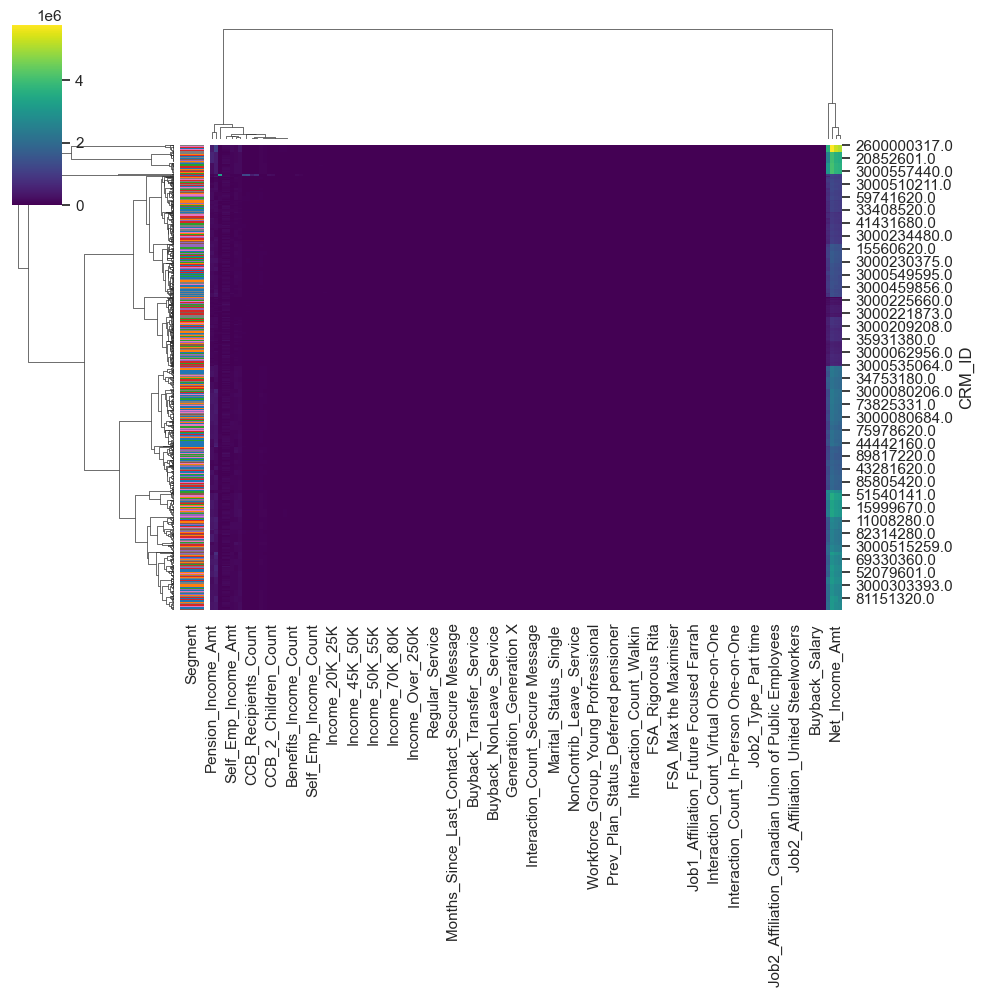

In [15]:
# Create color mapping for the segments
unique_segments = y_segment.unique()
colors = sns.color_palette("tab10", len(unique_segments))
segment_color_map = dict(zip(unique_segments, colors))
row_colors = y_segment.map(segment_color_map)

metric="euclidean"   ##correlation , cosine, jaccard, 
# lut = {'internet_1g': 'green', 'Decline_offer': 'red'}
cmap = "viridis"
snsPlot = sns.clustermap(X_segment
                        ,row_colors=row_colors
                        # ,standard_scale=1   ###Standardize the data within the columns 
                        # ,z_score=1
                        # ,z_score=0          ##Normalize the data within the rows
                        # ,metric=metric
                        # ,row_cluster=True
                        # ,col_cluster=True
                        # , center=df_plot.median().median()  # Center around median
                        # ,vmin=0
                        # ,vmax=df_plot.quantile(0.95).max()
                        ,cmap=cmap    ##The mapping from data values to color space. If not provided, the default will depend on whether center is set.
                        # ,robust=True  ##If True and vmin or vmax are absent, the colormap range is computed with robust quantiles instead of the extreme values.
                        )

## Clustering Data Based on Different Scaling Methods

COMPARING SCALING METHODS

==================== STANDARD ====================

APPLYING STANDARD SCALING
------------------------------

CLUSTERING EVALUATION
-------------------------
k=2: Silhouette Score = 0.157
k=3: Silhouette Score = 0.164
k=4: Silhouette Score = 0.086
k=5: Silhouette Score = 0.087
k=6: Silhouette Score = 0.088
k=7: Silhouette Score = 0.056

Optimal number of clusters: 3 (highest silhouette score: 0.164)

==================== MINMAX ====================

APPLYING MINMAX SCALING
------------------------------

CLUSTERING EVALUATION
-------------------------
k=2: Silhouette Score = 0.147
k=3: Silhouette Score = 0.116
k=4: Silhouette Score = 0.107
k=5: Silhouette Score = 0.106
k=6: Silhouette Score = 0.103
k=7: Silhouette Score = 0.110

Optimal number of clusters: 2 (highest silhouette score: 0.147)

==================== ROBUST ====================

APPLYING ROBUST SCALING
------------------------------

CLUSTERING EVALUATION
-------------------------
k=2: Silhouette

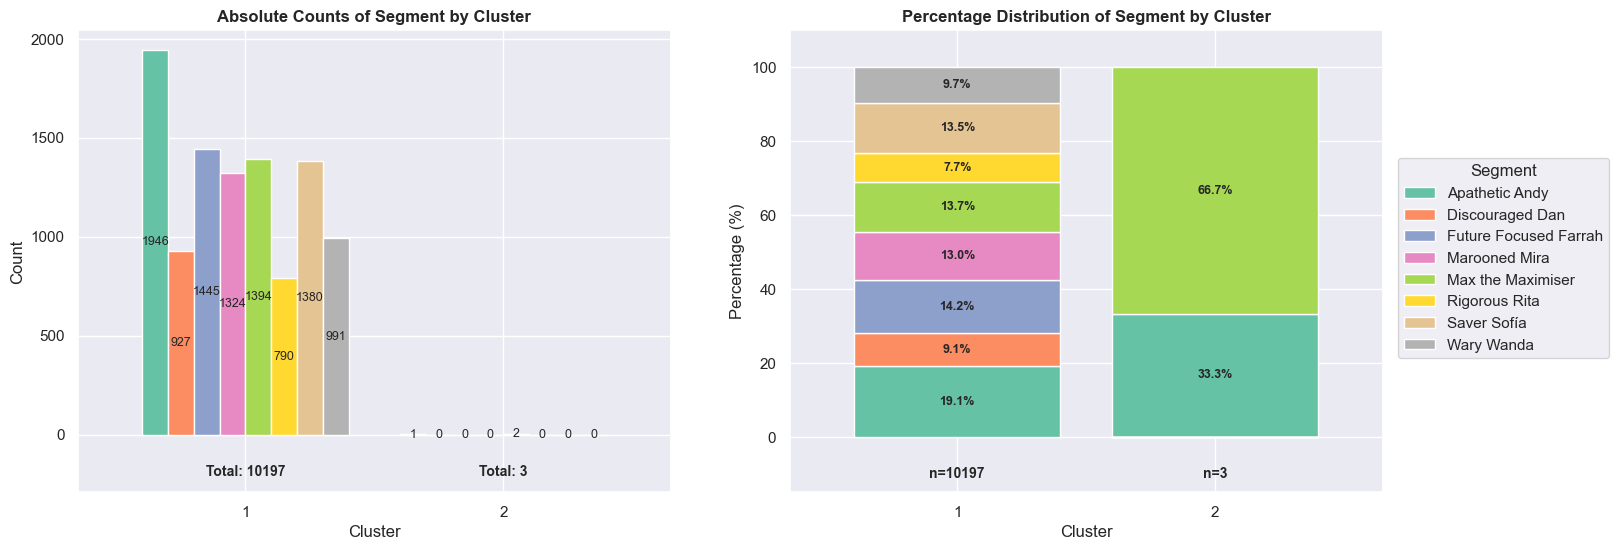

CLUSTER SUMMARY
Cluster 1: 10197 total observations
  Apathetic Andy: 1946 (19.1%)
  Discouraged Dan: 927 (9.1%)
  Future Focused Farrah: 1445 (14.2%)
  Marooned Mira: 1324 (13.0%)
  Max the Maximiser: 1394 (13.7%)
  Rigorous Rita: 790 (7.7%)
  Saver Sofía: 1380 (13.5%)
  Wary Wanda: 991 (9.7%)

Cluster 2: 3 total observations
  Apathetic Andy: 1 (33.3%)
  Max the Maximiser: 2 (66.7%)



In [16]:
# # Determine optimal clusters using silhouette analysis
# print(f"\n4. HIERARCHICAL CLUSTERING ANALYSIS")
# print("-"*40)
# hierarchal_cluster(df_plot)

comparison, summary_df = compare_scaling_methods(X_segment,  K_range = range(2, 8), methods=[ 'standard', 'minmax', 'robust'])

best_method = summary_df.iloc[0]['Method']
best_k = summary_df.iloc[0]['Optimal_K']
# best_k =3

final_results = cluster_analysis(X_segment, K_range=range(best_k, best_k+1), scale_method=best_method)
clusters = final_results['clusters']

X_new_clusters=pd.concat([pd.DataFrame(clusters), X_segment, y_segment], axis=1)
cluster_df = simple_cluster_visualization(X_new_clusters, target_col)

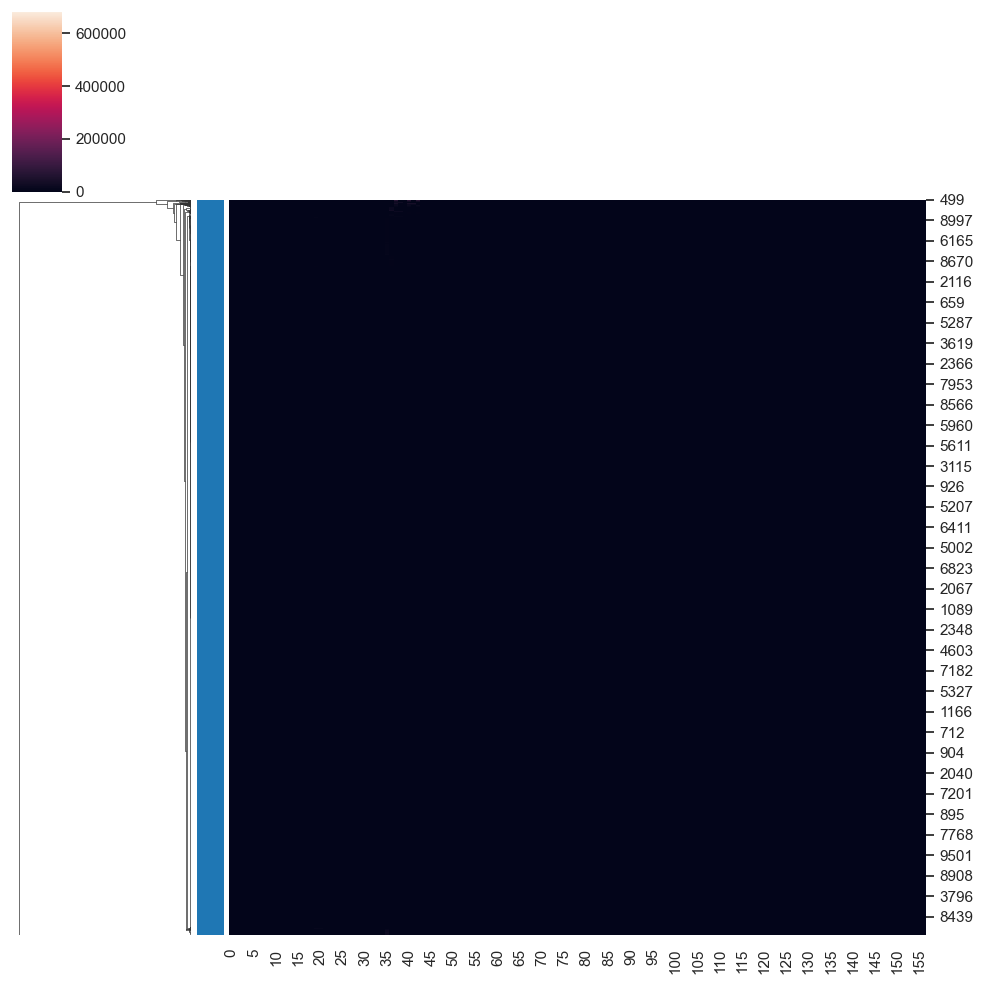

In [17]:
unique_segments = clusters.unique()
colors = sns.color_palette("tab10", len(unique_segments))
segment_color_map = dict(zip(unique_segments, colors))
row_colors = clusters.map(segment_color_map).to_numpy()

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(X_segment)

snsPlot = sns.clustermap(scaled_data
                        ,row_colors=row_colors
                        # ,standard_scale=1   ###Standardize the data within the columns 
                        # ,z_score=1
                        # ,z_score=0          ##Normalize the data within the rows
                        # ,metric=metric
                        ,row_cluster=True
                        ,col_cluster=False
                        # , center=df_plot.median().median()  # Center around median
                        # ,vmin=0
                        # ,vmax=df_plot.quantile(0.95).max()
                        # ,cmap=cmap    ##The mapping from data values to color space. If not provided, the default will depend on whether center is set.
                        # ,robust=True  ##If True and vmin or vmax are absent, the colormap range is computed with robust quantiles instead of the extreme values.
                        )

## Statisical test univarite VS target

### Categorical Variables 

Index(['Generation', 'Marital_Status', 'FSA', 'Workforce_Group', 'Job1_Type',
       'Job1_Sector', 'Job1_Affiliation', 'Job2_Type', 'Job2_Sector',
       'Job2_Affiliation', 'Plan_Status', 'Sub_Status', 'Prev_Plan_Status',
       'Segment'],
      dtype='object')

Contingency Table:
Segment                      Apathetic Andy  Discouraged Dan  \
Prev_Plan_Status                                               
Active                                   47               27   
Deferred pensioner                       86               31   
Terminated without benefits             130               63   
Transfer agreement                      146               65   

Segment                      Future Focused Farrah  Marooned Mira  \
Prev_Plan_Status                                                    
Active                                          24             31   
Deferred pensioner                              48             53   
Terminated without benefits                    113    

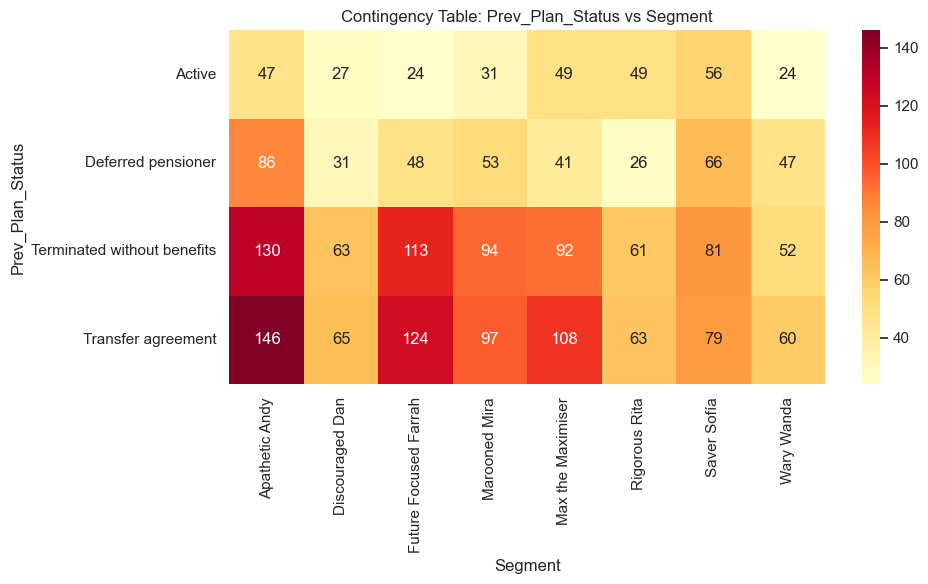

In [18]:
reload(cfuncs)
object_columns = profile_df.select_dtypes(include=['object']).columns
print(object_columns)

# Perform analysis
cat_col='Prev_Plan_Status'
results = cfuncs.analyze_categorical_data(profile_df, cat_col, target_col)

# Print results
print("\nContingency Table:")
print(results['contingency_table'])
print("\nChi-square statistic:", results['chi_square_statistic'])
print("P-value:", results['p_value'])
print("Cramer's V:", results['cramers_v'])
print("\nInterpretation:")
print(results['interpretation'])

### Numerical Variables 

In [19]:
num_columns = profile_df.select_dtypes(exclude=['object']).columns
print(num_columns)

num_col='Current_Age'
# Custom configuration
config = cfuncs.PlotConfig(
                    height=1000,
                    width=1400,
                    theme='dark',
                    bins=30,
                    kde_points=200,
                    boxpoints=False,
                    violin_points=False,
                    # first_plot='violin'
                )
fig= cfuncs.plot_distributions(profile_df, num_col, target_col, config=config)
fig.show()

Index(['CRM_ID', 'Current_Age', 'Job_Duration', 'Job1_Duration',
       'Job2_Duration', 'Job1_Duration_per', 'Job2_Duration_per',
       'Total_Service', 'Regular_Service', 'Buyback_Service',
       ...
       'Months_Since_First_Contact_Phone',
       'Months_Since_First_Contact_Secure Message',
       'Months_Since_First_Contact_Virtual One-on-One',
       'Months_Since_First_Contact_Walkin', 'Months_Since_Last_Contact_Email',
       'Months_Since_Last_Contact_In-Person One-on-One',
       'Months_Since_Last_Contact_Phone',
       'Months_Since_Last_Contact_Secure Message',
       'Months_Since_Last_Contact_Virtual One-on-One',
       'Months_Since_Last_Contact_Walkin'],
      dtype='object', length=101)


## Correlation

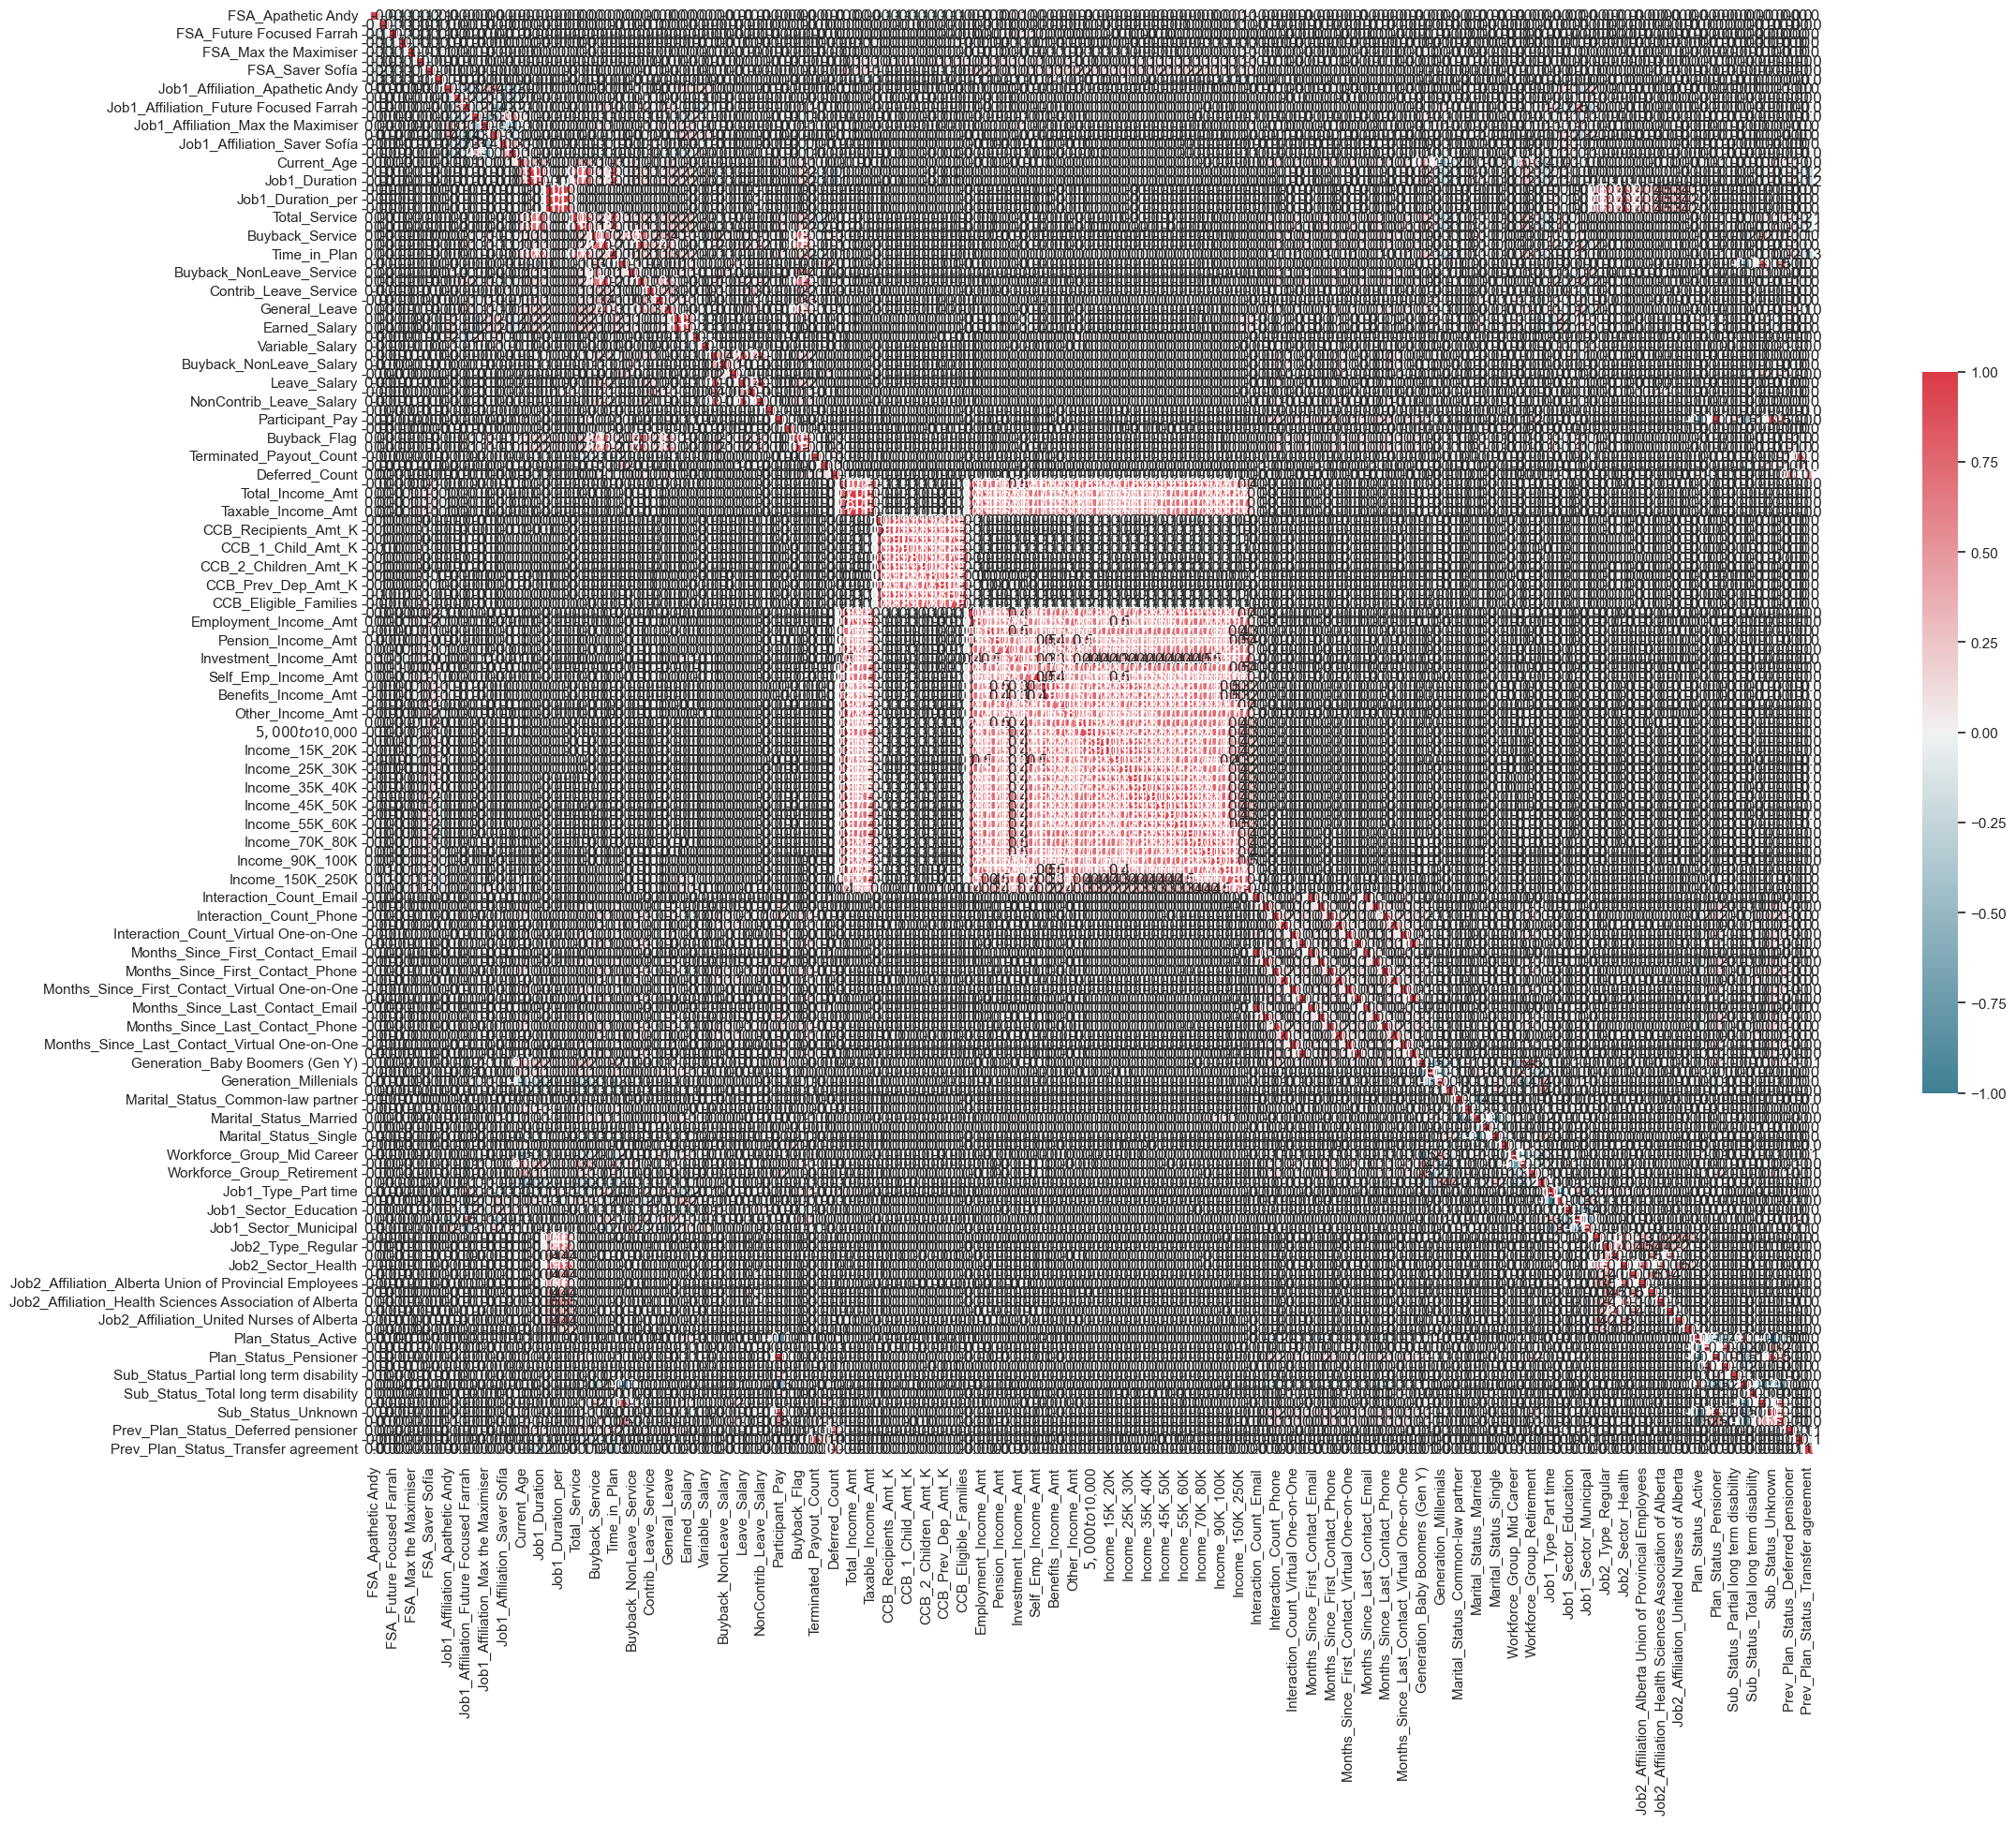

FSA_Apathetic Andy  \
FSA_Apathetic Andy                                      1.000000   
FSA_Discouraged Dan                                    -0.031388   
FSA_Future Focused Farrah                              -0.149631   
FSA_Marooned Mira                                      -0.068212   
FSA_Max the Maximiser                                  -0.098345   
...                                                          ...   
Sub_Status_Unknown                                     -0.007218   
Prev_Plan_Status_Active                                 0.003800   
Prev_Plan_Status_Deferred pensioner                     0.022546   
Prev_Plan_Status_Terminated without benefits           -0.013384   
Prev_Plan_Status_Transfer agreement                     0.008670   

                                              FSA_Discouraged Dan  \
FSA_Apathetic Andy                                      -0.031388   
FSA_Discouraged Dan                                      1.000000   
FSA_Future Focused Farrah                               -0.055215   
FSA_Marooned Mira                                       -0.082070   
FSA_Max the Maximiser                                   -0.119068   
...                                                           ...   
Sub_Status_Unknown                                       0.007717   
Prev_Plan_Status_Active                                 -0.007960   
Prev_Plan_Status_Deferred pensioner                      0.000908   
Prev_Plan_Status_Terminated without benefits            -0.006771   
Prev_Plan_Status_Transfer agreement                     -0.006932   

                                              FSA_Future Focused Farrah  \
FSA_Apathetic Andy                                            -0.149631   
FSA_Discouraged Dan                                           -0.055215   
FSA_Future Focused Farrah                                      1.000000   
FSA_Marooned Mira                                             -0.139704   
FSA_Max the Maximiser                                         -0.092979   
...                                                                 ...   
Sub_Status_Unknown                                            -0.002926   
Prev_Plan_Status_Active                                        0.000604   
Prev_Plan_Status_Deferred pensioner                            0.011728   
Prev_Plan_Status_Terminated without benefits                   0.005390   
Prev_Plan_Status_Transfer agreement                            0.002196   

                                              FSA_Marooned Mira  \
FSA_Apathetic Andy                                    -0.068212   
FSA_Discouraged Dan                                   -0.082070   
FSA_Future Focused Farrah                             -0.139704   
FSA_Marooned Mira                                      1.000000   
FSA_Max the Maximiser                                 -0.097397   
...                                                         ...   
Sub_Status_Unknown                                    -0.008917   
Prev_Plan_Status_Active                                0.003501   
Prev_Plan_Status_Deferred pensioner                   -0.005157   
Prev_Plan_Status_Terminated without benefits           0.011607   
Prev_Plan_Status_Transfer agreement                    0.005102   

                                              FSA_Max the Maximiser  \
FSA_Apathetic Andy                                        -0.098345   
FSA_Discouraged Dan                                       -0.119068   
FSA_Future Focused Farrah                                 -0.092979   
FSA_Marooned Mira                                         -0.097397   
FSA_Max the Maximiser                                      1.000000   
...                                                             ...   
Sub_Status_Unknown                                         0.011134   
Prev_Plan_Status_Active                                    0.005199   
Prev_Plan_Status_Deferred pensioner                    

In [20]:
corr, figure=cfuncs.corrmap(X_segment, method='kendall', diagonal_plot=False)
corr

## Canonical Correlation analysis 

They will try to find the multidimensional direction in the X space that explains the maximum multidimensional variance direction in the Y space. In other words, PLS projects both X and Y into a lower-dimensional subspace such that the covariance between transformed(X) and transformed(Y) is maximal.

PLS draws similarities with Principal Component Regression (PCR), where the samples are first projected into a lower-dimensional subspace, and the targets y are predicted using transformed(X). One issue with PCR is that the dimensionality reduction is unsupervised, and may lose some important variables: PCR would keep the features with the most variance, but it’s possible that features with a small variances are relevant from predicting the target. In a way, PLS allows for the same kind of dimensionality reduction, but by taking into account the targets y

In statistics, canonical-correlation analysis (CCA), also called canonical variates analysis, is a way of inferring information from cross-covariance matrices. If we have two vectors X = (X1, ..., Xn) and Y = (Y1, ..., Ym) of random variables, and there are correlations among the variables, then canonical-correlation analysis will find linear combinations of X and Y which have maximum correlation with each other.[1]

In [21]:
X1=pd.concat([X_segment, y_segment], axis=1).set_index([target_col])
X2=df_segment.set_index([target_col])

results = cca_analysis(X2, X1, n_comp=3, scaler_type='standard',  cluster_rows=True, cluster_cols=True)

# Access individual components
correlations = results['correlations']
coefficients = results['coefficients']
normalized_coef = results['coefficients_normalized']

# Display plots when you want
results['fig_correlations'].show()
results['fig_heatmap'].show()

# Or save them
# results['fig_correlations'].write_html("correlations.html")
# results['fig_heatmap'].write_image("heatmap.png")

# uplot=sns.clustermap(
#                     data=tmp,
#                     cmap=cmap,
#                     # annot=True,
#                     # fmt="g",
#                     row_cluster=True, 
#                     col_cluster=True,
#                     )
# uplot.fig.suptitle(f'Relationship between {tmp.index.name} and {tmp.columns.name} \n (Canonical correlations: {str(np.round(comp_corr[:2].values,1))})')


Your CCA Results Interpretation:

CC1 = 0.388 (38.8% correlation)

Moderate-weak relationship between your first canonical variates
This is the strongest possible linear combination relationship between your X1 and X2 datasets
About 15% shared variance (0.388² = 0.15) between the datasets through this component

CC2 = 0.297 (29.7% correlation)

Weak relationship for the second canonical component
This captures the next strongest orthogonal relationship
Only about 9% shared variance (0.297² = 0.09)

CC3 = 0.202 (20.2% correlation)

Very weak relationship
Only about 4% shared variance (0.202² = 0.04)
Likely not practically meaningful

What This Suggests:
Overall Assessment:

Your datasets have modest linear relationships at best
The relationships are not very strong compared to typical successful CCA analyses
You might want to consider:

Different variable selection
Non-linear relationships (CCA only captures linear)
Data preprocessing (different scaling, transformations)
Whether CCA is the right technique for your data



Practical Meaning:

Focus on CC1 only - the other components are probably noise
Look at your heatmap to see which specific variables contribute most to that 38.8% correlation
Consider that your datasets might be measuring quite different underlying phenomena

Comparison:

Strong CCA: correlations > 0.7
Moderate CCA: correlations 0.5-0.7
Weak CCA: correlations < 0.5 ← Your results

## Detecting Multicollinearity with VIF 

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in a dataset.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        DataFrame containing the features to analyze for multicollinearity
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with feature names and their corresponding VIF values
    """
    # Prepare features
    X_processed = X.copy()
    
    # Get feature names
    features = X_processed.columns
    
    # Initialize dictionary to store VIF values
    vif_dict = {}
    
    # Calculate VIF for each feature
    for feature in features:
        # Create a copy of features excluding the current one
        other_features = [f for f in features if f != feature]
        
        # Extract X and y for the auxiliary regression
        y = X_processed[feature]
        X_others = X_processed[other_features]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_others, y)
        
        # Calculate R-squared
        y_pred = model.predict(X_others)
        r_squared = np.corrcoef(y, y_pred)[0,1]**2
        
        # Calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[feature] = vif
    
    # Create DataFrame with results
    vif_df = pd.DataFrame({
        'Feature': list(vif_dict.keys()),
        'VIF': list(vif_dict.values())
    })
    
    # Sort by VIF value in descending order
    vif_df = vif_df.sort_values('VIF', ascending=False)
    
    return vif_df

def detect_multicollinearity(X, vif_threshold=5):
    """
    Detect multicollinearity in a dataset using VIF and provide recommendations.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        DataFrame containing the features to analyze
    vif_threshold : float, default=5
        Threshold for VIF values above which multicollinearity is considered problematic
        
    Returns:
    --------
    tuple
        (vif_df, problematic_features, recommendations)
        - vif_df: DataFrame with VIF values for each feature
        - problematic_features: list of features with high VIF values
        - recommendations: string with suggested actions
    """
    # Calculate VIF values
    vif_df = calculate_vif(X)
    
    # Identify problematic features
    problematic_features = vif_df[vif_df['VIF'] > vif_threshold]['Feature'].tolist()
    
    # Generate recommendations
    if len(problematic_features) == 0:
        recommendations = "No significant multicollinearity detected in the dataset."
    else:
        recommendations = f"""
        Multicollinearity detected in the following features: {', '.join(problematic_features)}
        
        Recommended actions:
        1. Consider removing one or more of the highly correlated features
        2. Combine correlated features using dimensionality reduction techniques (e.g., PCA)
        3. Create interaction terms or polynomial features instead of using raw features
        4. Collect additional data if possible
        5. Use regularization techniques (Ridge, Lasso, or Elastic Net) in your model
        
        Note: For categorical variables that were one-hot encoded, consider:
        - Using fewer categories by combining similar ones
        - Using ordinal encoding if categories have a natural order
        - Applying dimensionality reduction specifically to categorical features
        """
    
    return vif_df, problematic_features, recommendations

vif_results, problem_features, recommendations = detect_multicollinearity(X_segment, vif_threshold=5)
 
# Print results
print("VIF Analysis Results:")
print("-" * 40)
print(vif_results)
print("\nProblematic Features:")
print("-" * 40)
print(problem_features)
print("\nRecommendations:")
print("-" * 40)
print(recommendations)

VIF Analysis Results:
----------------------------------------
                                               Feature       VIF
120                             Marital_Status_Married       inf
18                                       Job1_Duration       inf
33                                        Total_Salary       inf
138  Job2_Affiliation_Alberta Union of Provincial E...       inf
37                                      Buyback_Salary       inf
..                                                 ...       ...
35                                        Retro_Salary  1.286608
49                           Terminated_Transfer_Count  1.172706
36                                     Variable_Salary  1.087803
45                                          Spouse_Pay  1.033987
43                                     Beneficiary_Pay  1.015128

[157 rows x 2 columns]

Problematic Features:
----------------------------------------
['Marital_Status_Married', 'Job1_Duration', 'Total_Salary', 'Job2_Aff

## Univariate feature Selection

mutual_info_classif
f_classif


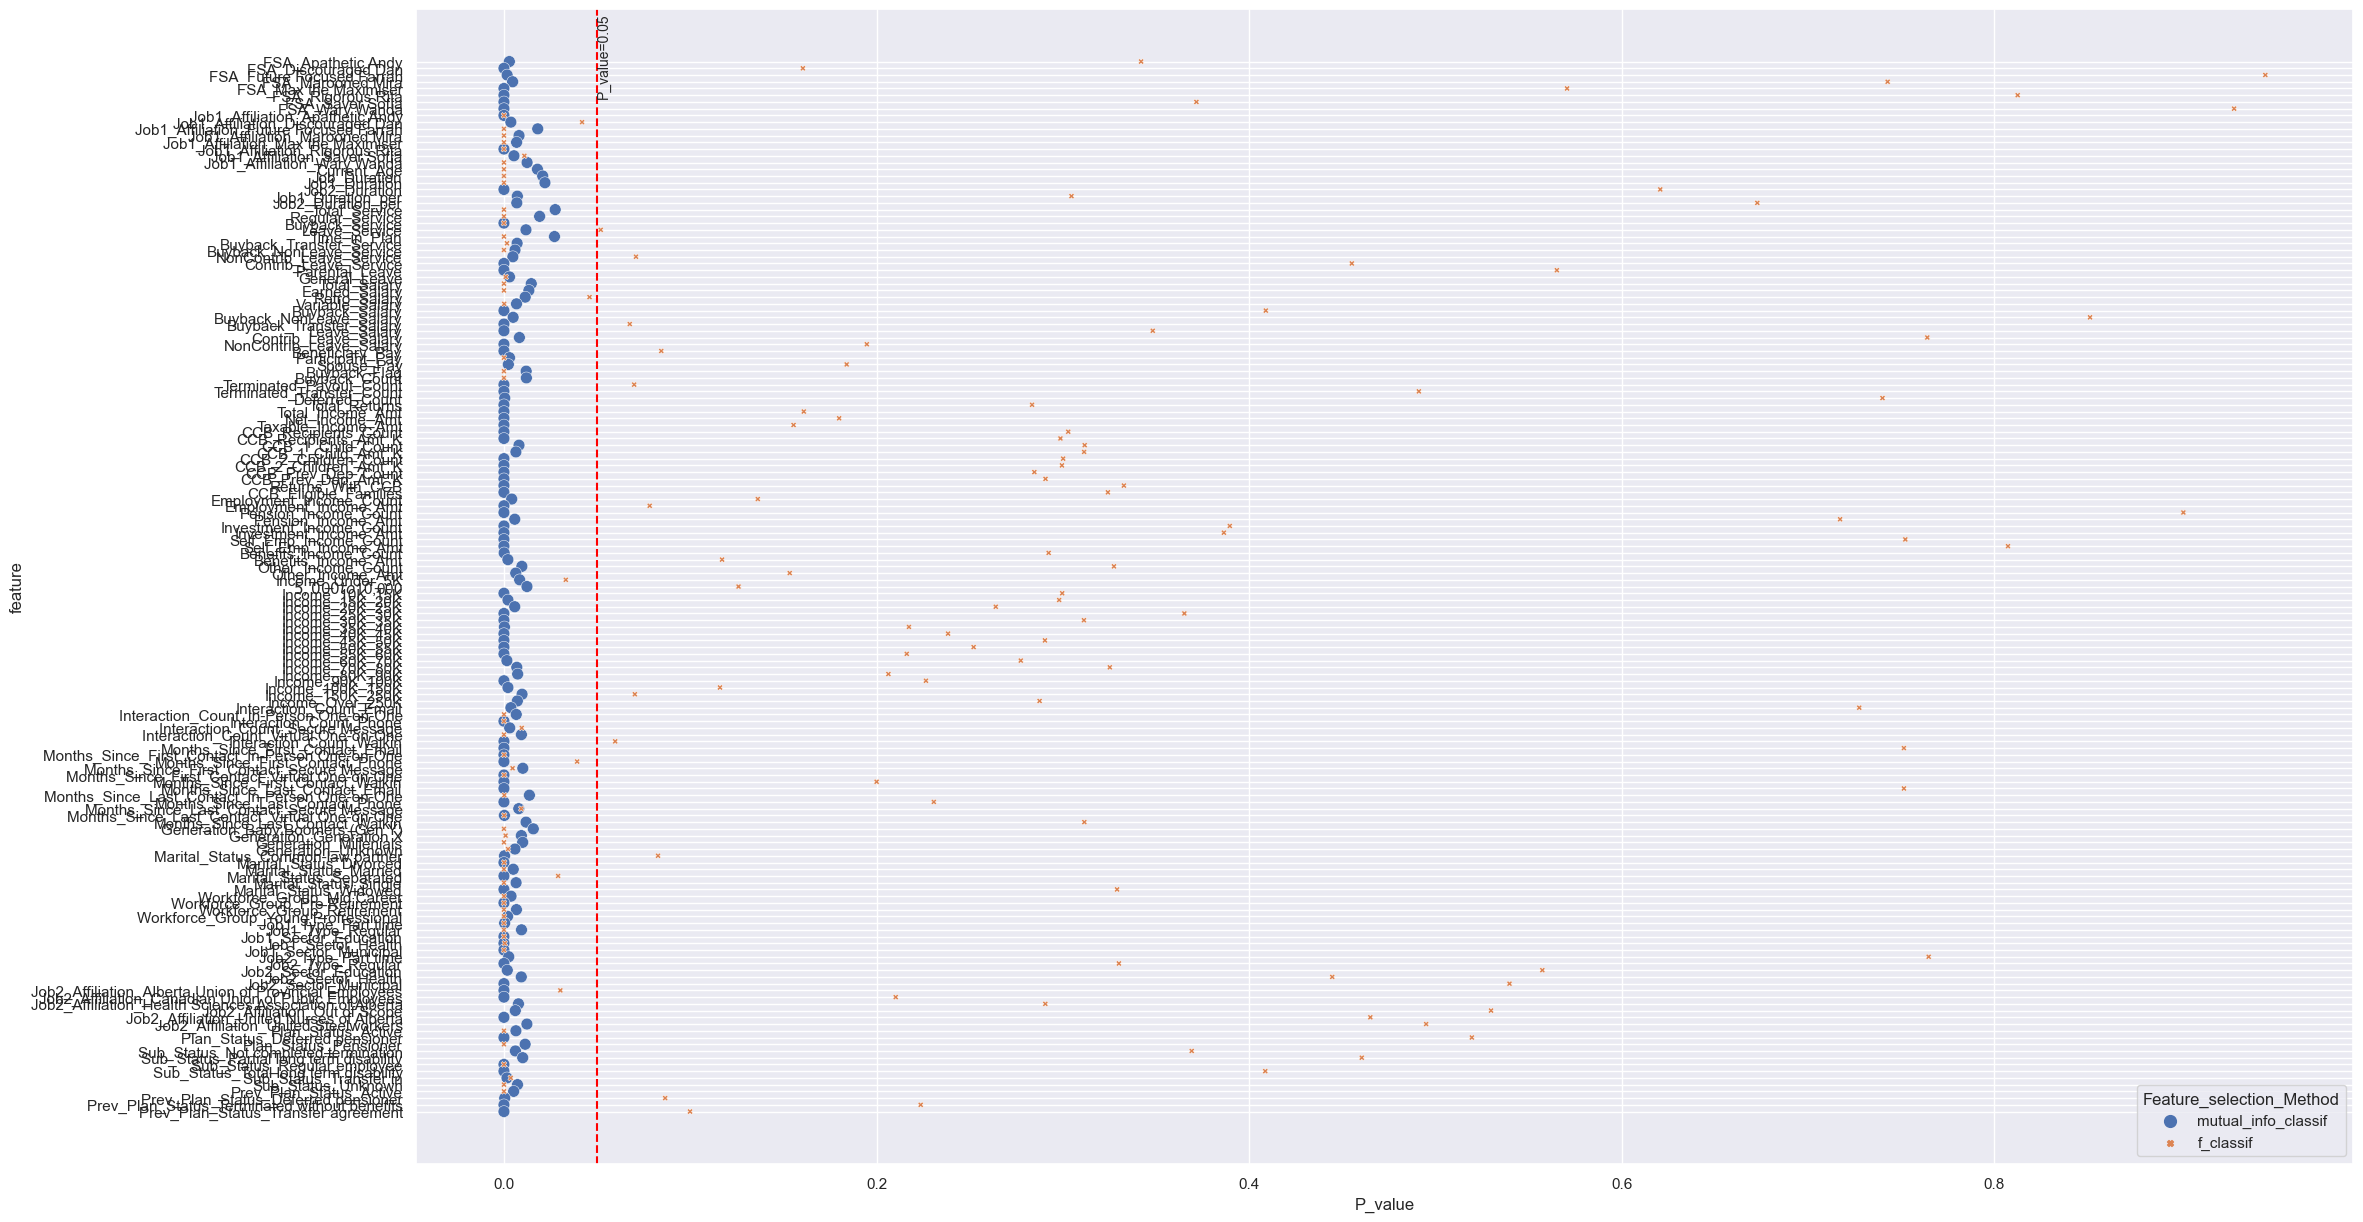

                                     mutual_info_classif     f_classif
Prev_Plan_Status_Transfer agreement             0.000000  9.987223e-02
Months_Since_First_Contact_Email                0.000000  7.514160e-01
CCB_Recipients_Amt_K                            0.000000  2.986975e-01
CCB_Recipients_Count                            0.000000  3.028821e-01
Taxable_Income_Amt                              0.000000  1.554515e-01
...                                                  ...           ...
Regular_Service                                 0.019152  1.209603e-70
Job_Duration                                    0.020808  6.868080e-41
Job1_Duration                                   0.022013  9.605755e-40
Time_in_Plan                                    0.027127  8.709584e-59
Total_Service                                   0.027514  7.004314e-77

[157 rows x 2 columns]
['FSA_Apathetic Andy', 'FSA_Discouraged Dan', 'FSA_Future Focused Farrah', 'FSA_Marooned Mira', 'FSA_Max the Maximiser', 'FS

In [23]:
univar_fea_lst=[
                'mutual_info_classif',
                # 'mutual_info_regression',
                # 'chi2',
                # 'SelectPercentile',
                # 'SelectFpr',
                # 'SelectFdr',
                # 'SelectFwe',
                'f_classif',
                ]
univar_feature_selection=cfuncs.compare_univar_fea(X_segment,
                                                    y_segment,
                                                    univar_fea_lst
                                                   )

print(univar_feature_selection.sort_values(by=['mutual_info_classif']))

univar_feature_removed=univar_feature_selection[univar_feature_selection['f_classif']>.05].index.tolist()
print(univar_feature_removed)

# ML Model

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
reload(ml_funcs)

# profile_df = pd.read_csv(training_file_cleaned)

with open(training_file_cleaned_pickle, 'rb') as f:
    profile_df = pickle.load(f)    

fsa_channel_analytics=[
 'Census_year',
 'Total_Returns',
 'Total_Income_Amt',
 'Net_Income_Amt',
 'Taxable_Income_Amt',
 'CCB_Recipients_Count',
 'CCB_Recipients_Amt_K',
 'CCB_1_Child_Count',
 'CCB_1_Child_Amt_K',
 'CCB_2_Children_Count',
 'CCB_2_Children_Amt_K',
 'CCB_Prev_Dep_Count',
 'CCB_Prev_Dep_Amt_K',
 'Returns_With_CCB',
 'CCB_Eligible_Families',
 'Employment_Income_Count',
 'Employment_Income_Amt',
 'Pension_Income_Count',
 'Pension_Income_Amt',
 'Investment_Income_Count',
 'Investment_Income_Amt',
 'Self_Emp_Income_Count',
 'Self_Emp_Income_Amt',
 'Benefits_Income_Count',
 'Benefits_Income_Amt',
 'Other_Income_Count',
 'Other_Income_Amt',
 'Income_Under_5K',
 '$5,000  to $10,000',
 'Income_10K_15K',
 'Income_15K_20K',
 'Income_20K_25K',
 'Income_25K_30K',
 'Income_30K_35K',
 'Income_35K_40K',
 'Income_40K_45K',
 'Income_45K_50K',
 'Income_50K_55K',
 'Income_55K_60K',
 'Income_60K_70K',
 'Income_70K_80K',
 'Income_80K_90K',
 'Income_90K_100K',
 'Income_100K_150K',
 'Income_150K_250K',
 'Income_Over_250K',
 
 'Interaction_Count_Email',
 'Interaction_Count_In-Person One-on-One',
 'Interaction_Count_Phone',
 'Interaction_Count_Secure Message',
 'Interaction_Count_Virtual One-on-One',
 'Interaction_Count_Walkin',
 'Months_Since_First_Contact_Email',
 'Months_Since_First_Contact_In-Person One-on-One',
 'Months_Since_First_Contact_Phone',
 'Months_Since_First_Contact_Secure Message',
 'Months_Since_First_Contact_Virtual One-on-One',
 'Months_Since_First_Contact_Walkin',
 'Months_Since_Last_Contact_Email',
 'Months_Since_Last_Contact_In-Person One-on-One',
 'Months_Since_Last_Contact_Phone',
 'Months_Since_Last_Contact_Secure Message',
 'Months_Since_Last_Contact_Virtual One-on-One',
 'Months_Since_Last_Contact_Walkin']

# profile_df=profile_df.drop(fsa_channel_analytics, axis=1)

####conversion cat to dummies 
object_columns = [i for i in profile_df.select_dtypes(include=['object']).columns if i not in ['FSA','Job1_Affiliation', 'Job2_Affiliation', target_col]]
print("Columns to hotencode:", object_columns)
profile_cat_df= pd.get_dummies(profile_df, columns=object_columns)

display(profile_df.select_dtypes(include=['object']).nunique().sort_values(ascending=False))

X=profile_cat_df.drop(target_col, axis=1).set_index(['CRM_ID'])
y= profile_cat_df[target_col]
un_splits=10

imputer_strategy='mean'
pc_n_components=5

scores_names=[
            "recall",
            "precision",
            "accuracy",
            # "auc_weighted",
            # 'balanced_accuracy',
            # 'roc_auc',
            # 'aucpr',
            "f1",
            "kappa",
            "mcc",
            ]

segment_freq = profile_df[target_col].value_counts().sort_values(ascending=False)
segment_freq

Columns to hotencode: ['Generation', 'Marital_Status', 'Workforce_Group', 'Job1_Type', 'Job1_Sector', 'Job2_Type', 'Job2_Sector', 'Plan_Status', 'Sub_Status', 'Prev_Plan_Status']


FSA                 170
Job1_Affiliation     27
Segment               8
Marital_Status        6
Job2_Affiliation      6
Sub_Status            6
Generation            4
Workforce_Group       4
Prev_Plan_Status      4
Job1_Sector           3
Job2_Sector           3
Plan_Status           3
Job1_Type             2
Job2_Type             2
dtype: int64

Apathetic Andy           1947
Future Focused Farrah    1445
Max the Maximiser        1396
Saver Sofía              1380
Marooned Mira            1324
Wary Wanda                991
Discouraged Dan           927
Rigorous Rita             790
Name: Segment, dtype: int64

### Differnet MLs and  report Peformance of a ML model

In [11]:
import os
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def run_ml_classification(X, y, output_folder, 
                         segment_type='all',
                         imputer_strategy='mean', pc_n_components=5,
                         un_splits=None, scores_names=None, plot=False):
    """
    Run ML classification with different segment configurations
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target variable (profile_cat_df[target_col])
    output_folder : str
        Path to output folder for saving results
    segment_type : str, default='all'
        Type of segmentation: 'all', 'merged_with_dan', 'merged_without_dan'
    imputer_strategy : str, default='mean'
        Strategy for imputing missing values
    pc_n_components : int, default=5
        Number of principal components
    un_splits : object, default=None
        Cross-validation splits
    scores_names : list, default=None
        List of scoring metrics
    plot : bool, default=False
        Whether to plot results
        
    Returns:
    --------
    dict : Dictionary containing results and model performance
    """
    
    # Define X2 and y_class2 based on segment_type
    if segment_type == 'all':
        X2 = X
        y_class2 = y
        output_file_mls = os.path.join(output_folder, f'different_MLS_comparsion.pkl')
        output_file_conf_mat = os.path.join(output_folder, 'confusion_matrix_all_segments.jpg')
        
    elif segment_type == 'merged_with_dan':
        X2 = X
        y_class2 = y.replace({
            'Apathetic Andy': 'Larry_Mira_Dan',
            'Marooned Mira': 'Larry_Mira_Dan',
            'Discouraged Dan': 'Larry_Mira_Dan',
            'Future Focused Farrah': 'Farrah_Wanda',
            'Wary Wanda': 'Farrah_Wanda',
            'Max the Maximiser': 'Rita_Max_Sofia',
            'Saver Sofía': 'Rita_Max_Sofia',
            'Rigorous Rita': 'Rita_Max_Sofia',
        })
        output_file_mls = os.path.join(output_folder, f'different_MLS_comparsion_merged__Merged_Dan.pkl')
        output_file_conf_mat = os.path.join(output_folder, 'confusion_matrix_merged__Merged_Dan.jpg')
        
    elif segment_type == 'merged_without_dan':
        mask = y != 'Discouraged Dan'
        X2 = X.iloc[mask.values, :]
        y_class2 = y.replace({
            'Apathetic Andy': 'Larry_Mira',
            'Marooned Mira': 'Larry_Mira',
            'Future Focused Farrah': 'Farrah_Wanda',
            'Wary Wanda': 'Farrah_Wanda',
            'Max the Maximiser': 'Rita_Max_Sofia',
            'Saver Sofía': 'Rita_Max_Sofia',
            'Rigorous Rita': 'Rita_Max_Sofia',
        })[mask]
        output_file_mls = os.path.join(output_folder, f'different_MLS_comparsion_merged_without_Dan.pkl')
        output_file_conf_mat = os.path.join(output_folder, 'confusion_matrix_merged_without_Dan.jpg')
        
    else:
        raise ValueError("segment_type must be 'all', 'merged_with_dan', or 'merged_without_dan'")
    
    # Label encoding
    le = LabelEncoder()
    y_class_num = pd.Series(le.fit_transform(y_class2))
    map_lbls = dict(enumerate(le.classes_))
    
    # Update classifiers (assuming this function exists)
    classifiers2 = update_classifier(X2, y_class_num, 
                                   imputer_strategy=imputer_strategy,
                                   pc_n_components=pc_n_components, 
                                   target_type='multiclass')


    # Check if output file already exists
    if os.path.exists(output_file_mls):
        print(f"Output file {output_file_mls} already exists. Loading existing results...")
        # Load existing results
        with open(output_file_mls, 'rb') as f:
            output_different_mls = pickle.load(f)
    else:
        print(f"Output file {output_file_mls} does not exist. Running classification...")    
        # Run classifier batch comparison (assuming this function exists)
        df_ml_comparison_classifiers, summary = classifiers_batch(
            X2, y_class_num, 
            classifiers2,
            un_splits=un_splits,
            plot=plot,
            scores_names=scores_names
        )
    
        # Prepare output dictionary
        output_different_mls = {
            'df_ml_comparison_classifiers': df_ml_comparison_classifiers,
            'summary': summary,
        }
    
        # Save results
        with open(output_file_mls, 'wb') as f:
            pickle.dump(output_different_mls, f)

    ### Get best model
    model_comparison = output_different_mls['summary'].sort_values(by=['f1'], ascending=False)
    best_model = model_comparison['model'].iloc[0]
    best_f1_score = model_comparison['f1'].iloc[0]
    
    print(f"Best model: {best_model} with f1 score of {best_f1_score}")
    
    # Get best classifier and run detailed evaluation
    uclassifier = classifiers2[best_model]
    
    # Score classifier with cross-validation (assuming this function exists)
    scores, conf_mats, y_model_xval, _ = classifier_score_cf(
        uclassifier, map_lbls, X2, y_class_num, 
        un_splits=un_splits,
        scores_names=scores_names,
        average='macro',
        outputFile=output_file_conf_mat
    )
    
    # Prepare predictions for multi-label evaluation
    y_pred = y_model_xval.drop(['y_pred', 'y_true', 'CV_Iteration'], axis=1).apply(
        lambda row: (row == row.max()).astype(int), axis=1
    )
    y_true = pd.get_dummies(y_model_xval['y_true']) * 1
    
    # Evaluate multi-label performance (assuming ml_funcs.evaluate_multiLabel exists)
    model_performance, y_model = ml_funcs.evaluate_multiLabel(
        y_pred, y_true, 
        scores_names=scores_names, 
        average_op='binary'
    )
    
    display(scores)
    display(model_performance['yScore'])

    # Return comprehensive results
    return {
        'output_different_mls': output_different_mls,
        'model_comparison': model_comparison,
        'best_model': best_model,
        'best_f1_score': best_f1_score,
        'scores': scores,
        'conf_mats': conf_mats,
        'model_performance': model_performance,
        'y_model_xval': y_model_xval,
        'y_model': y_model,
        'map_lbls': map_lbls,
        'X2': X2,
        'y_class2': y_class2,
        'y_class_num': y_class_num
    }

# Example usage:
# For all segments
results_all = run_ml_classification(
    X=X, 
    y=y, 
    output_folder=output_Folder,
    segment_type='all',
    un_splits=un_splits,
    scores_names=scores_names
)

# For merged segments with Dan
results_merged_dan = run_ml_classification(
    X=X, 
    y=y, 
    output_folder=output_Folder,
    segment_type='merged_with_dan',
    un_splits=un_splits,
    scores_names=scores_names
)

# For merged segments without Dan
results_merged_no_dan = run_ml_classification(
    X=X, 
    y=y, 
    output_folder=output_Folder,
    segment_type='merged_without_dan',
    un_splits=un_splits,
    scores_names=scores_names
)


Output file c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\data\output\different_MLS_comparsion.pkl already exists. Loading existing results...
Best model: MLPClassifier1 with f1 score of 0.15514988311968594
Accuracy Score of selecting entire sets of tags:  0.1875


CV    recall  precision  accuracy        f1     kappa  \
0                0  0.164358   0.178025  0.189216  0.158751  0.048757   
1                1  0.165526   0.176082  0.195098  0.158679  0.050765   
2                2  0.158569   0.161993  0.180392  0.150995  0.040826   
3                3  0.165879   0.173927  0.193137  0.156697  0.050137   
4                4  0.162049   0.162140  0.187255  0.155154  0.046581   
5                5  0.147996   0.153687  0.174510  0.140056  0.028792   
6                6  0.163810   0.160593  0.187255  0.157594  0.047624   
7                7  0.153815   0.153836  0.189216  0.140494  0.041382   
8                8  0.162396   0.169781  0.191176  0.153935  0.049510   
9                9  0.160800   0.172262  0.188235  0.152326  0.043787   
10  CV_scores_Mean  0.160520   0.166232  0.187549  0.152468  0.044816   
11   CV_scores_STD  0.005685   0.008955  0.006044  0.006922  0.006648   
12      scores_all  0.160515   0.164825  0.187549  0.153421  0.044807   

         mcc  
0   0.049447  
1   0.052187  
2   0.041452  
3   0.051200  
4   0.047203  
5   0.029314  
6   0.048169  
7   0.042992  
8   0.050383  
9   0.044767  
10  0.045711  
11  0.006761  
12  0.045582

recall  precision  accuracy        f1     kappa  \
Saver Sofía            0.233333   0.231156  0.791275  0.232239  0.111462   
Future Focused Farrah  0.222837   0.182643  0.748627  0.200748  0.053345   
Marooned Mira          0.171450   0.172361  0.785588  0.171905  0.048757   
Rigorous Rita          0.043038   0.134387  0.904412  0.065197  0.028700   
Max the Maximiser      0.169054   0.165382  0.769510  0.167198  0.033462   
Wary Wanda             0.075681   0.138632  0.864510  0.097911  0.031451   
Apathetic Andy         0.348228   0.206079  0.619510  0.258927  0.025118   
Discouraged Dan        0.020496   0.087963  0.891667  0.033246 -0.001143   
macro_avg              0.160515   0.164825  0.796887  0.153421  0.041394   
macro_avg_STD          0.110336   0.044716  0.092441  0.080554  0.032741   
micro_avg              0.187549   0.187549  0.796887  0.187549  0.071485   
weighted_avg           0.187549   0.173365  0.773731  0.172065  0.043515   

                            mcc  Support_number  
Saver Sofía            0.111464            1380  
Future Focused Farrah  0.053716            1445  
Marooned Mira          0.048757            1324  
Rigorous Rita          0.033970             790  
Max the Maximiser      0.033465            1396  
Wary Wanda             0.033142             991  
Apathetic Andy         0.026682            1947  
Discouraged Dan       -0.001494             927  
macro_avg              0.042463           10200  
macro_avg_STD          0.032400           10200  
micro_avg              0.071485           10200  
weighted_avg           0.044407           10200

Output file c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\data\output\different_MLS_comparsion_merged__Merged_Dan.pkl already exists. Loading existing results...
Best model: Xgboost_n200 with f1 score of 0.35808576959184524
Accuracy Score of selecting entire sets of tags:  0.3961


CV    recall  precision  accuracy        f1     kappa  \
0                0  0.345390   0.343612  0.379412  0.338291  0.021540   
1                1  0.347817   0.346085  0.384314  0.339713  0.026370   
2                2  0.364042   0.367532  0.398039  0.357796  0.049471   
3                3  0.352059   0.351787  0.391176  0.342210  0.032786   
4                4  0.380306   0.390931  0.414706  0.375656  0.073433   
5                5  0.371663   0.374137  0.406863  0.365165  0.063456   
6                6  0.356535   0.358678  0.391176  0.349597  0.038618   
7                7  0.378176   0.379139  0.418627  0.366863  0.076132   
8                8  0.351997   0.352396  0.387255  0.344575  0.031464   
9                9  0.349751   0.348446  0.389216  0.337832  0.029484   
10  CV_scores_Mean  0.359774   0.361274  0.396078  0.351770  0.044275   
11   CV_scores_STD  0.012912   0.015938  0.013186  0.013676  0.020123   
12      scores_all  0.359769   0.361212  0.396078  0.351921  0.044259   

         mcc  
0   0.021879  
1   0.026934  
2   0.050345  
3   0.033802  
4   0.075215  
5   0.064638  
6   0.039329  
7   0.078306  
8   0.032145  
9   0.030345  
10  0.045294  
11  0.020640  
12  0.045231

recall  precision  accuracy        f1     kappa       mcc  \
Rita_Max_Sofia  0.395681   0.397577  0.579118  0.396627  0.073483  0.073484   
Larry_Mira_Dan  0.546927   0.428518  0.513333  0.480536  0.035298  0.036231   
Farrah_Wanda    0.136700   0.257541  0.699706  0.178600  0.015556  0.016726   
macro_avg       0.359769   0.361212  0.597386  0.351921  0.041446  0.042147   
macro_avg_STD   0.207458   0.091105  0.094520  0.155853  0.029449  0.028838   
micro_avg       0.396078   0.396078  0.597386  0.396078  0.094118  0.094118   
weighted_avg    0.396078   0.376867  0.580842  0.379091  0.043933  0.044596   

                Support_number  
Rita_Max_Sofia            3566  
Larry_Mira_Dan            4198  
Farrah_Wanda              2436  
macro_avg                10200  
macro_avg_STD            10200  
micro_avg                10200  
weighted_avg             10200

Output file c:\Users\rnourzadeh\OneDrive - Alberta Pensions Services Corporation\main_folder\codes\01_pivotal_research\data\output\different_MLS_comparsion_merged_without_Dan.pkl already exists. Loading existing results...
Best model: Xgboost_n200_dp10 with f1 score of 0.3724539554606273
Accuracy Score of selecting entire sets of tags:  0.3827


CV    recall  precision  accuracy        f1     kappa  \
0                0  0.384530   0.384036  0.405172  0.379964  0.083503   
1                1  0.351679   0.347543  0.371767  0.346557  0.034188   
2                2  0.371496   0.367467  0.392241  0.366944  0.066009   
3                3  0.354939   0.352349  0.374326  0.351065  0.037807   
4                4  0.342068   0.340459  0.361381  0.337569  0.015691   
5                5  0.372849   0.370791  0.391586  0.369925  0.066305   
6                6  0.374460   0.375095  0.393743  0.370956  0.066033   
7                7  0.360222   0.359884  0.375405  0.358701  0.043611   
8                8  0.349750   0.351398  0.368932  0.344987  0.025625   
9                9  0.372469   0.375058  0.392665  0.367511  0.062331   
10  CV_scores_Mean  0.363446   0.362408  0.382722  0.359418  0.050110   
11   CV_scores_STD  0.013607   0.014205  0.014076  0.013781  0.021767   
12      scores_all  0.363445   0.362147  0.382724  0.359574  0.050110   

         mcc  
0   0.084404  
1   0.034459  
2   0.066430  
3   0.038070  
4   0.015838  
5   0.066621  
6   0.066654  
7   0.043756  
8   0.025955  
9   0.063147  
10  0.050533  
11  0.021973  
12  0.050501

recall  precision  accuracy        f1     kappa       mcc  \
Rita_Max_Sofia  0.493831   0.429094  0.552680  0.459192  0.080990  0.081572   
Larry_Mira      0.401101   0.379959  0.557856  0.390244  0.043831  0.043871   
Farrah_Wanda    0.195402   0.277389  0.654912  0.229287  0.015512  0.015907   
macro_avg       0.363445   0.362147  0.588483  0.359574  0.046778  0.047117   
macro_avg_STD   0.152736   0.077405  0.057588  0.117981  0.032838  0.032952   
micro_avg       0.382724   0.382724  0.588483  0.382724  0.074086  0.074086   
weighted_avg    0.382724   0.371909  0.581362  0.374475  0.050682  0.051023   

                Support_number  
Rita_Max_Sofia            3566  
Larry_Mira                3271  
Farrah_Wanda              2436  
macro_avg                 9273  
macro_avg_STD             9273  
micro_avg                 9273  
weighted_avg              9273

Macro-average calculates the metric for each class separately, then takes the simple average across all classes.

Macro Precision = (Precision_A + Precision_B + ... + Precision_N) ÷ N
Macro Recall = (Recall_A + Recall_B + ... + Recall_N) ÷ N

-----------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------
Micro-average pools all the true positives, false positives, and false negatives across all classes, then calculates the metric globally.

Micro Precision = (TP_A + TP_B + ... + TP_N) ÷ (TP_A + FP_A + TP_B + FP_B + ... + TP_N + FP_N)
Micro Recall = (TP_A + TP_B + ... + TP_N) ÷ (TP_A + FN_A + TP_B + FN_B + ... + TP_N + FN_N)

Key Differences
When to use macro-average:

When you want equal treatment of all classes
When class imbalance exists but you care about minority class performance
When all classes are equally important to your problem

When to use micro-average:

When larger classes are more important
When you want an overall performance measure that reflects the total number of correct predictions
In balanced datasets, micro and macro averages will be similar

Note: In multi-class problems, micro-averaged precision and recall are always equal to accuracy, since the numerators and denominators represent the same values when summed across all classes.

In [12]:
idx = ['macro_avg_STD', 'micro_avg', 'weighted_avg']

print("All Segments Model Performance:")
print(f"the best model: {results_all['best_model']}")
print(results_all['model_performance']['yScore'][['f1','accuracy','Support_number']].drop(idx).round(3))
print("-"*150)

print("\nMerged Segments without Dan Segment Performance:")
print(f"the best model: {results_merged_no_dan['best_model']}")
print(results_merged_no_dan['model_performance']['yScore'][['f1','accuracy','Support_number']].drop(idx).round(3))
print("-"*150)

print("\nMerged Segments with Dan Segment Performance:")
print(f"the best model: {results_merged_dan['best_model']}")
print(results_merged_dan['model_performance']['yScore'][['f1','accuracy','Support_number']].drop(idx).round(3))
print("-"*150)

All Segments Model Performance:
the best model: MLPClassifier1
                          f1  accuracy  Support_number
Saver Sofía            0.232     0.791            1380
Future Focused Farrah  0.201     0.749            1445
Marooned Mira          0.172     0.786            1324
Rigorous Rita          0.065     0.904             790
Max the Maximiser      0.167     0.770            1396
Wary Wanda             0.098     0.865             991
Apathetic Andy         0.259     0.620            1947
Discouraged Dan        0.033     0.892             927
macro_avg              0.153     0.797           10200
------------------------------------------------------------------------------------------------------------------------------------------------------

Merged Segments without Dan Segment Performance:
the best model: Xgboost_n200_dp10
                   f1  accuracy  Support_number
Rita_Max_Sofia  0.459     0.553            3566
Larry_Mira      0.390     0.558            3271
Farrah_W

### One VS All

In [26]:
model_performance=pd.DataFrame()
y_model=pd.DataFrame()
scores=pd.DataFrame()

for segment in segment_freq.index[::-1]:
    print(f'{segment} vs Rest...')

    y_class2=pd.Series(np.where(profile_cat_df[target_col]==segment, 1,0))
    map_lbls2={0:'Rest', 1:segment}

    classifiers3=update_classifier(X, y_class2, imputer_strategy='mean', pc_n_components=5, target_type='binary')
    uclassifier_binary=classifiers3['logReg_mode_l1']

    scores_tmp, confMats, y_model_Xval, _ = classifier_score_cf(uclassifier_binary, map_lbls2, X, y_class2, un_splits=un_splits, 
                                        scores_names=scores_names,
                                        # average=None,   
                                        outputFile=os.path.join(output_Folder, f'confusion_matrix_merged_{segment}.jpg')
                                        )

    # y_pred=y_model_Xval.drop(['y_pred','y_true','CV_Iteration'],axis=1).apply(lambda row: (row == row.max()).astype(int), axis=1)
    # y_true = pd.get_dummies(y_model_Xval['y_true'])
    # model_performance_tmp, y_model_tmp = ml_funcs.evaluate_multiLabel(y_pred, y_true, scores_names=scores_names, average_op='binary')
    # model_performance_tmp['yScore']['Segment']=segment
    # y_model_tmp['Segment']=segment
    # model_performance=pd.concat([model_performance, model_performance_tmp['yScore'] ],axis=0)
    # y_model=pd.concat([y_model, y_model_tmp],axis=1)

    scores_tmp['Segment']=segment
    scores=pd.concat([scores, scores_tmp],axis=0)
    # display(scores)
    # display(model_performance_tmp['yScore'])

display(scores[scores['CV'].isin(['CV_scores_Mean',
                                #   'CV_scores_STD',
                                #   'scores_all'
                                  ])])

Rigorous Rita vs Rest...
Discouraged Dan vs Rest...
Wary Wanda vs Rest...
Marooned Mira vs Rest...
Saver Sofía vs Rest...
Max the Maximiser vs Rest...
Future Focused Farrah vs Rest...
Apathetic Andy vs Rest...


CV    recall  precision  accuracy        f1     kappa  \
10  CV_scores_Mean  0.501421   0.540543  0.921961  0.483366  0.005098   
10  CV_scores_Mean  0.499946   0.454554  0.909020  0.476171 -0.000194   
10  CV_scores_Mean  0.500451   0.501461  0.902843  0.475468  0.001615   
10  CV_scores_Mean  0.500094   0.460109  0.869804  0.465922  0.000322   
10  CV_scores_Mean  0.503236   0.612495  0.863431  0.472388  0.010900   
10  CV_scores_Mean  0.499846   0.448217  0.862353  0.463740 -0.000536   
10  CV_scores_Mean  0.500116   0.479181  0.858039  0.462479  0.000397   
10  CV_scores_Mean  0.500422   0.479624  0.808529  0.449069  0.001355   

         mcc                Segment  
10  0.016962          Rigorous Rita  
10 -0.000992        Discouraged Dan  
10  0.008528             Wary Wanda  
10  0.000733          Marooned Mira  
10  0.035642            Saver Sofía  
10 -0.004905      Max the Maximiser  
10  0.002605  Future Focused Farrah  
10  0.005729         Apathetic Andy

### Feedforward Selection

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# X2, y_class2=X.iloc[:1000,:10], y[:1000]
X2, y_class2=X, y

le = LabelEncoder()
y_class2_num = pd.Series(le.fit_transform(y_class2))
map_lbls = dict(enumerate(le.classes_))

classifiers2=update_classifier(X2, y_class2_num, imputer_strategy='mean' ,pc_n_components=5, target_type='multiclass')
umodel=classifiers2['MLPClassifier_early_stopping']

# Map back to original feature names
def map_to_original_features(transformed_feature_names, original_columns):
    """
    Map transformed feature names back to original column names
    """
    original_features = set()
    
    for trans_feat in transformed_feature_names:
        # Handle different preprocessing patterns
        if '__' in trans_feat:
            # Extract base feature name (remove preprocessing prefix)
            base_name = trans_feat.split('__')[1]
            
            # Remove numeric suffixes from one-hot encoding
            # e.g., 'FSA_0', 'FSA_1' -> 'FSA'
            if '_' in base_name and base_name.split('_')[-1].isdigit():
                base_name = '_'.join(base_name.split('_')[:-1])
            
            # Check if this base name exists in original columns
            if base_name in original_columns:
                original_features.add(base_name)
            else:
                # Sometimes the mapping is more complex, try partial matching
                for orig_col in original_columns:
                    if orig_col in base_name or base_name.startswith(orig_col):
                        original_features.add(orig_col)
                        break
        else:
            # Direct mapping (no preprocessing prefix)
            if trans_feat in original_columns:
                original_features.add(trans_feat)
    
    return sorted(list(original_features))

def run_feature_selection_pipeline(X, y_class, umodel, map_lbls,
                                output_Folder, 
                                un_splits=10, 
                                random_state=RANDOM_STATE, scores_names=None):

    # Data preparation

    features = X.columns
    
    # Create cross-validation strategy
    sk_fold = StratifiedKFold(n_splits=un_splits, shuffle=True, random_state=random_state)

    classifier=umodel[-1]
    # Sequential feature selection
    sfs1 = SFS(
        classifier,
        n_features_to_select='auto',
        direction="forward",
        scoring='f1'
    )    

    existing_steps = umodel.steps[:-1]
    new_steps = existing_steps+[('sfs', sfs1)]
    complete_pipeline  = Pipeline(steps=new_steps)
    
    complete_pipeline.fit(X, y_class)

    # Get information about selected features
    feature_names_after_preprocessing = complete_pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_feature_mask = complete_pipeline.named_steps['sfs'].get_support()
    selected_transformed_features  = feature_names_after_preprocessing[selected_feature_mask]
    # Map selected features back to original column names
    selected_original_features = map_to_original_features(selected_transformed_features, X.columns)
    
    print(f"Selected {len(selected_transformed_features)} features out of {len(feature_names_after_preprocessing)}")
    print(f"Selected features: {selected_transformed_features}...")
    print(f"Selected original features: {selected_original_features}")

    # Save feature selection results
    ffs_details = {
        'complete_pipeline': complete_pipeline,
        'selected_original_features': selected_original_features,  # Original column names
        'selected_transformed_features': selected_transformed_features,  # Transformed names
        'feature_selector_mask': selected_feature_mask
    }
    
    model_name = classifier.__class__.__name__
    outputFile_ffs = os.path.join(output_Folder, f'selected_cols_feedforward_selection_{model_name}.pkl')
    
    with open(outputFile_ffs, 'wb') as f:
        pickle.dump(ffs_details, f)
    
    classifiers2=update_classifier(X[selected_original_features], y_class, imputer_strategy='mean' ,pc_n_components=5, target_type='multiclass')
    umodel=classifiers2['MLPClassifier_early_stopping']

    scores, confMats, y_model_Xval, _ = classifier_score_cf(
        umodel, 
        map_lbls, 
        X[selected_original_features],
        y_class, 
        un_splits=un_splits,
        scores_names=scores_names,
        average='macro',
        outputFile=os.path.join(output_Folder, 'confusion_matrix_ff.jpg')
    )

    return scores, confMats, y_model_Xval, ffs_details

# Execute the pipeline
scores, confMats, y_model_Xval, ffs_details = run_feature_selection_pipeline(
    X2, y_class2_num,
    umodel,
    map_lbls,
    output_Folder, 
    random_state=RANDOM_STATE,
    scores_names=scores_names
)

Selected 80 features out of 161
Selected features: ['target_enc__FSA_0' 'target_enc__FSA_1' 'target_enc__FSA_2'
 'target_enc__FSA_3' 'target_enc__FSA_4' 'target_enc__FSA_5'
 'target_enc__FSA_6' 'target_enc__FSA_7' 'target_enc__Job1_Affiliation_0'
 'target_enc__Job1_Affiliation_1' 'target_enc__Job1_Affiliation_2'
 'target_enc__Job1_Affiliation_3' 'target_enc__Job1_Affiliation_4'
 'target_enc__Job1_Affiliation_5' 'target_enc__Job1_Affiliation_6'
 'target_enc__Job1_Affiliation_7' 'target_enc__Job2_Affiliation_0'
 'target_enc__Job2_Affiliation_1' 'target_enc__Job2_Affiliation_2'
 'target_enc__Job2_Affiliation_3' 'target_enc__Job2_Affiliation_4'
 'target_enc__Job2_Affiliation_5' 'target_enc__Job2_Affiliation_6'
 'target_enc__Job2_Affiliation_7' 'passthrough__Current_Age'
 'passthrough__Job_Duration' 'passthrough__Job1_Duration'
 'passthrough__Job2_Duration' 'passthrough__Job1_Duration_per'
 'passthrough__Job2_Duration_per' 'passthrough__Total_Service'
 'passthrough__Regular_Service' 'passth

# Draft:

In [ ]:
# ###for all segments:
# X2=X
# y_class2=profile_cat_df[target_col]
# #### outputFile_MLs = os.path.join(output_Folder, f'different_MLS_comparsion__oldFeatures.pkl')
# outputFile_MLs = os.path.join(output_Folder, f'different_MLS_comparsion__NewFeatures.pkl')
# outputFile_confMat=os.path.join(output_Folder, 'confusion_matrix_all_segments.jpg')

# ###Merge segments to improve performance
# ####WITH Dan merged
# X2=X
# y_class2=.replace({
#                                             'Apathetic Andy':'Larry_Mira_Dan',
#                                             'Marooned Mira':'Larry_Mira_Dan',
#                                             'Discouraged Dan': 'Larry_Mira_Dan'  ,  

#                                             'Future Focused Farrah':'Farrah_Wanda',
#                                             'Wary Wanda':'Farrah_Wanda',

#                                             'Max the Maximiser':'Rita_Max_Sofia',
#                                             'Saver Sofía':'Rita_Max_Sofia',
#                                             'Rigorous Rita':'Rita_Max_Sofia',
#                                             })
# outputFile_MLs = os.path.join(output_Folder, f'different_MLS_comparsion__NewFeatures_merged__Merged_Dan.pkl')
# outputFile_confMat=os.path.join(output_Folder, 'confusion_matrix_merged__Merged_Dan.jpg')

# ####WITHOUT Dan
# mask = profile_cat_df[target_col] != 'Discouraged Dan'
# X2 = X.iloc[mask.values, :]
# y_class2=profile_cat_df[target_col].replace({
#                                             'Apathetic Andy':'Larry_Mira',
#                                             'Marooned Mira':'Larry_Mira',

#                                             'Future Focused Farrah':'Farrah_Wanda',
#                                             'Wary Wanda':'Farrah_Wanda',


#                                             'Max the Maximiser':'Rita_Max_Sofia',
#                                             'Saver Sofía':'Rita_Max_Sofia',
#                                             'Rigorous Rita':'Rita_Max_Sofia',
#                                             })[mask]
# outputFile_MLs = os.path.join(output_Folder, f'different_MLS_comparsion__NewFeatures_merged_without_Dan.pkl')
# outputFile_confMat=os.path.join(output_Folder, 'confusion_matrix_merged_without_Dan.jpg')

# ###-------------------------------------------------------------------------------------
# ###-------------------------------------------------------------------------------------
# ###-------------------------------------------------------------------------------------
# le = LabelEncoder()
# y_class_num = pd.Series(le.fit_transform(y_class2))
# map_lbls = dict(enumerate(le.classes_))

# classifiers2=update_classifier(X2, y_class_num, imputer_strategy='mean' ,pc_n_components=5, target_type='multiclass')

# df_ml_comparison_classifiers, summary=classifiers_batch(X2, y_class_num, 
#                                                          classifiers2,
#                                                          un_splits=un_splits,
#                                                          plot=False,
#                                                          scores_names=scores_names
#                                                         )

# output_different_MLS={'df_ml_comparison_classifiers': df_ml_comparison_classifiers,
#                       'summary':summary,
#                         }

# with open(outputFile_MLs, 'wb') as f:
#     pickle.dump(output_different_MLS, f)

# with open(outputFile_MLs, 'rb') as f:
#     output_different_MLS = pickle.load(f)    

# model_comparsion=output_different_MLS['summary'].sort_values(by=['f1'], ascending=False)

# best_model= model_comparsion['model'].iloc[0]
# print(f"Best model: {best_model} with f1 score of {model_comparsion['f1'].iloc[0]}")
# display(model_comparsion)
# display(output_different_MLS['df_ml_comparison_classifiers'][output_different_MLS['df_ml_comparison_classifiers']['model']==best_model])

# uclassifier=classifiers2[best_model]
# scores, confMats, y_model_Xval,_=classifier_score_cf(uclassifier, map_lbls, X, y_class_num, un_splits=un_splits,
#                                     scores_names=scores_names,
#                                      average='macro',  
#                                     outputFile=outputFile_confMat
#                                       )

# y_pred=y_model_Xval.drop(['y_pred','y_true','CV_Iteration'],axis=1).apply(lambda row: (row == row.max()).astype(int), axis=1)
# y_true = pd.get_dummies(y_model_Xval['y_true'])*1
# model_performance, y_model = ml_funcs.evaluate_multiLabel(y_pred, y_true, scores_names=scores_names, average_op='binary')

# display(scores)
# display(model_performance['yScore'])

In [ ]:
### Adjust thershold for logistic regression
# from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=42)

# # Train a logistic regression model
# lr = LogisticRegression()
# lr.fit(X_train, y_train)

# # Calculate the predicted probabilities for the test set
# probs = lr.predict_proba(X_test)

# # Set a custom threshold value
# custom_threshold = 0.55

# # Generate the predicted classes based on the custom threshold
# preds = (probs[:,1] >= custom_threshold).astype(int)

# # Evaluate the performance of the model using the custom threshold
# accuracy = (preds == y_test).mean()
# print(f"Accuracy with custom threshold: {accuracy:.2f}")

In [ ]:
### Lasso(L1) HyperParameter Tuning
####under edition: it takes forever, unable to find bug
# import optuna
# import numpy as np
# import pandas as pd
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.datasets import make_classification
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import warnings
# warnings.filterwarnings('ignore')

# # Example 1: Logistic Regression with L1 penalty
# def objective_logistic(trial):
#     # Suggest hyperparameters
#     C = trial.suggest_float('C', 1e-4, 1e2, log=True)
#     solver = trial.suggest_categorical('solver', ['liblinear','saga'])
#     max_iter = trial.suggest_int('max_iter', 100, 5000)
    
#     # Create model
#     uclassifier = LogisticRegression(
#         penalty='l1',
#         C=C,
#         solver=solver,
#         max_iter=max_iter,
#         random_state=RANDOM_STATE
#     )
    
#     model=Pipeline(steps=[('target_encoder', TargetEncoder()),
#                           # ("imputer", SimpleImputer(strategy=imputer_strategy)),
#                           ("scaler", StandardScaler()),
#                           # ("reduce_dims", PCA(n_components=pc_n_components)),
#                           ('classifier', uclassifier)]
#                     )

#     # Cross-validation
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#     scores = cross_val_score(model, X, y_class, cv=cv, scoring='f1', n_jobs=-1)
#     return scores.mean()

# def run_optimization():
#     """Run hyperparameter optimization examples"""
    
#     print("=== Logistic Regression Optimization ===")
#     study_lr = optuna.create_study(direction='maximize')
#     study_lr.optimize(objective_logistic, n_trials=50)
    
#     print(f"Best F1 Score: {study_lr.best_value:.4f}")
#     print(f"Best Parameters: {study_lr.best_params}")
#     print()

#     return study_lr

# # Additional utility functions
# def analyze_study(study, top_n=5):
#     """Analyze optimization results"""
#     print(f"\n=== Study Analysis ===")
#     print(f"Number of finished trials: {len(study.trials)}")
#     print(f"Best trial value: {study.best_value:.4f}")
    
#     # Get top N trials
#     top_trials = sorted(study.trials, key=lambda t: t.value if t.value else 0, reverse=True)[:top_n]
    
#     print(f"\nTop {top_n} trials:")
#     for i, trial in enumerate(top_trials):
#         print(f"{i+1}. Value: {trial.value:.4f}, Params: {trial.params}")

# def plot_optimization_history(study):
#     """Plot optimization history (requires plotly)"""
#     try:
#         import plotly
#         fig = optuna.visualization.plot_optimization_history(study)
#         fig.show()
#     except ImportError:
#         print("Install plotly to visualize optimization history: pip install plotly")

# def plot_param_importances(study):
#     """Plot parameter importances (requires plotly)"""
#     try:
#         import plotly
#         fig = optuna.visualization.plot_param_importances(study)
#         fig.show()
#     except ImportError:
#         print("Install plotly to visualize parameter importances: pip install plotly")

# # Custom sampler example
# def run_with_custom_sampler():
#     """Example with custom sampler"""
#     # sampler = optuna.samplers.TPESampler(seed=42)
#     study = optuna.create_study(direction='maximize',
#                                 #  sampler=sampler
#                                  )
#     study.optimize(objective_logistic, n_trials=50)
    
#     print(f"Custom sampler - Best score: {study.best_value:.4f}")
#     return study

# # Run all optimization examples
# studies = run_optimization()

# outputFile_hyperParm = os.path.join(output_Folder, f'hyperParameter_tuning_lasso.pkl')
# with open(outputFile_hyperParm, 'wb') as f:
#     pickle.dump(studies, f)

# # Analyz study
# # analyze_study(studies)

# # # Uncomment to plot results (requires plotly)
# # plot_optimization_history(studies)
# # plot_param_importances(studies)

In [ ]:
# high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
# low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
# mixed_encoded_preprocessor = ColumnTransformer(
#     [
#         ("numerical", "passthrough", numerical_features),
#         (
#             "high_cardinality",
#             TargetEncoder(target_type="continuous"),
#             high_cardinality_features,
#         ),
#         (
#             "low_cardinality",
#             OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
#             low_cardinality_features,
#         ),
#     ],
#     verbose_feature_names_out=False,
# )

# # The output of the of the preprocessor must be set to pandas so the
# # gradient boosting model can detect the low cardinality features.
# mixed_encoded_preprocessor.set_output(transform="pandas")
# mixed_pipe = make_pipeline(
#     mixed_encoded_preprocessor,
#     HistGradientBoostingRegressor(
#         random_state=0, max_iter=max_iter, categorical_features=low_cardinality_features
#     ),
# )
# mixed_pipe

In [ ]:
####comparing two excel sheets:
# training_file  = os.path.join(project_root , 'data','All collected Data with all the demographics.xlsx')
# profile_df0 = pd.read_excel(training_file,
#                         sheet_name=0,
#                         # na_values=['NaN'],
#                         keep_default_na = False,
#                         # header=[3, 4, 5],
#                         # skiprows=[0,1,2],
#                         # parse_dates=["Enter today's date:"],
#                         verbose=False
#                         )
# training_file  = os.path.join(project_root , 'data','Active_Member_List.xlsx')
# profile_new_df0=pd.read_excel(training_file,
#                         sheet_name=0,
#                         # na_values=['NaN'],
#                         keep_default_na = False,
#                         # skiprows=[0,1,2],
#                         # parse_dates=["Enter today's date:"],
#                         verbose=False
#                         )

# comapare_out, summary, venn_fig=cfuncs.compare_lists(profile_df0.columns.tolist(),profile_new_df0.columns.tolist(), 
#                                             similarity_threshold=90,
#                                             create_venn=True,
#                                             listA_name='List_old', listB_name='List_new',
#                                             save_venn_path=os.path.join(project_root , 'data','venn_diagram.png'))
# print(summary)